In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training_methods import *
from helpers.visualizations_methods import *
from helpers.preprocessing_methods import *
from helpers.aequitas_methods import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import warnings
from sklearn.preprocessing import MinMaxScaler
from helpers.mitigation_methods import *
from aequitas import Audit
import math
warnings.filterwarnings(action='ignore')

pip install 'aif360[inFairness]'


In [9]:
ml_ds = openml.datasets.get_dataset(46356)
df, * _ = ml_ds.get_data()
df
df['target'] = np.where(df['target']==2,0,1)

In [10]:
def categorize_age(age):
    if age<30:
        return '<=30'
    if age>=30:
        return '>30'
df['age'] = df['age'].apply(categorize_age).astype(object)
df['age'].value_counts()

protected_attributes = ["housing","gender","num_people_maintenance"]
target = 'target'
df["housing"] = np.where(df['housing']=="own","own","not own")

In [11]:
"""
num_people_maintenance: Number of people being liable to provide maintenance for
housing: Type of housing, either owning or not (free & rent attributes are combined together)
"""

df_intersect = df.copy()

df_intersect["num_people_maintenance/gender"] = df_intersect["num_people_maintenance"].astype(str)+ "-" + df_intersect["gender"]
df_intersect["gender/housing"] = df_intersect["gender"] + "-" + df_intersect["housing"]
df_intersect["num_people_maintenance/housing"] = df_intersect["num_people_maintenance"].astype(str) + "-" + df_intersect["housing"]

df_intersect.drop(protected_attributes, axis=1, inplace=True)

protected_attributes_int = ["num_people_maintenance/gender","gender/housing","num_people_maintenance/housing"]
df["num_people_maintenance"] = df["num_people_maintenance"].astype(int)


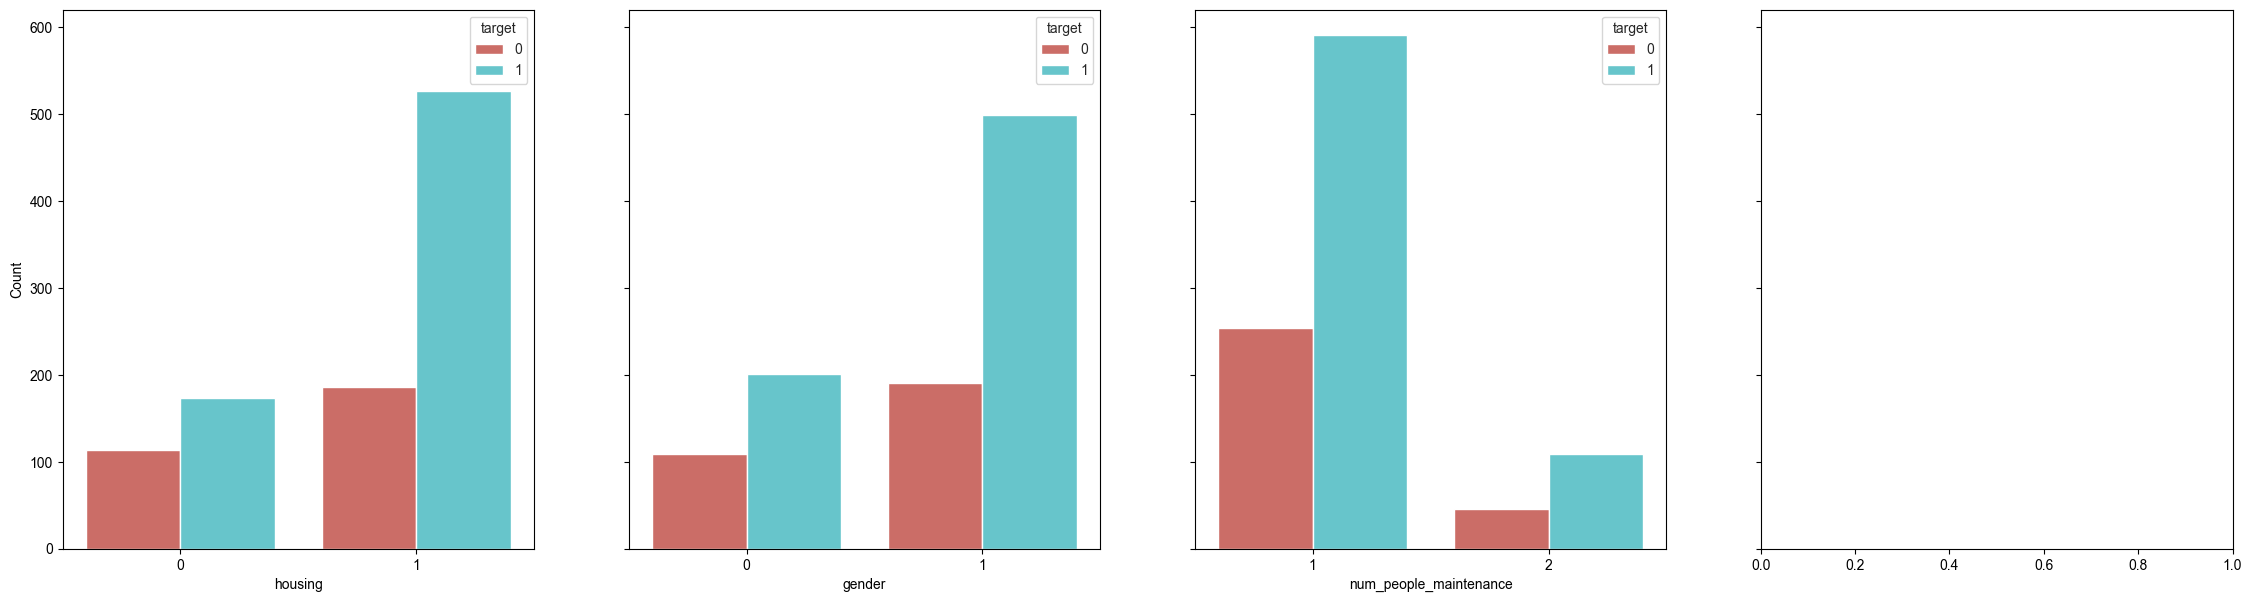

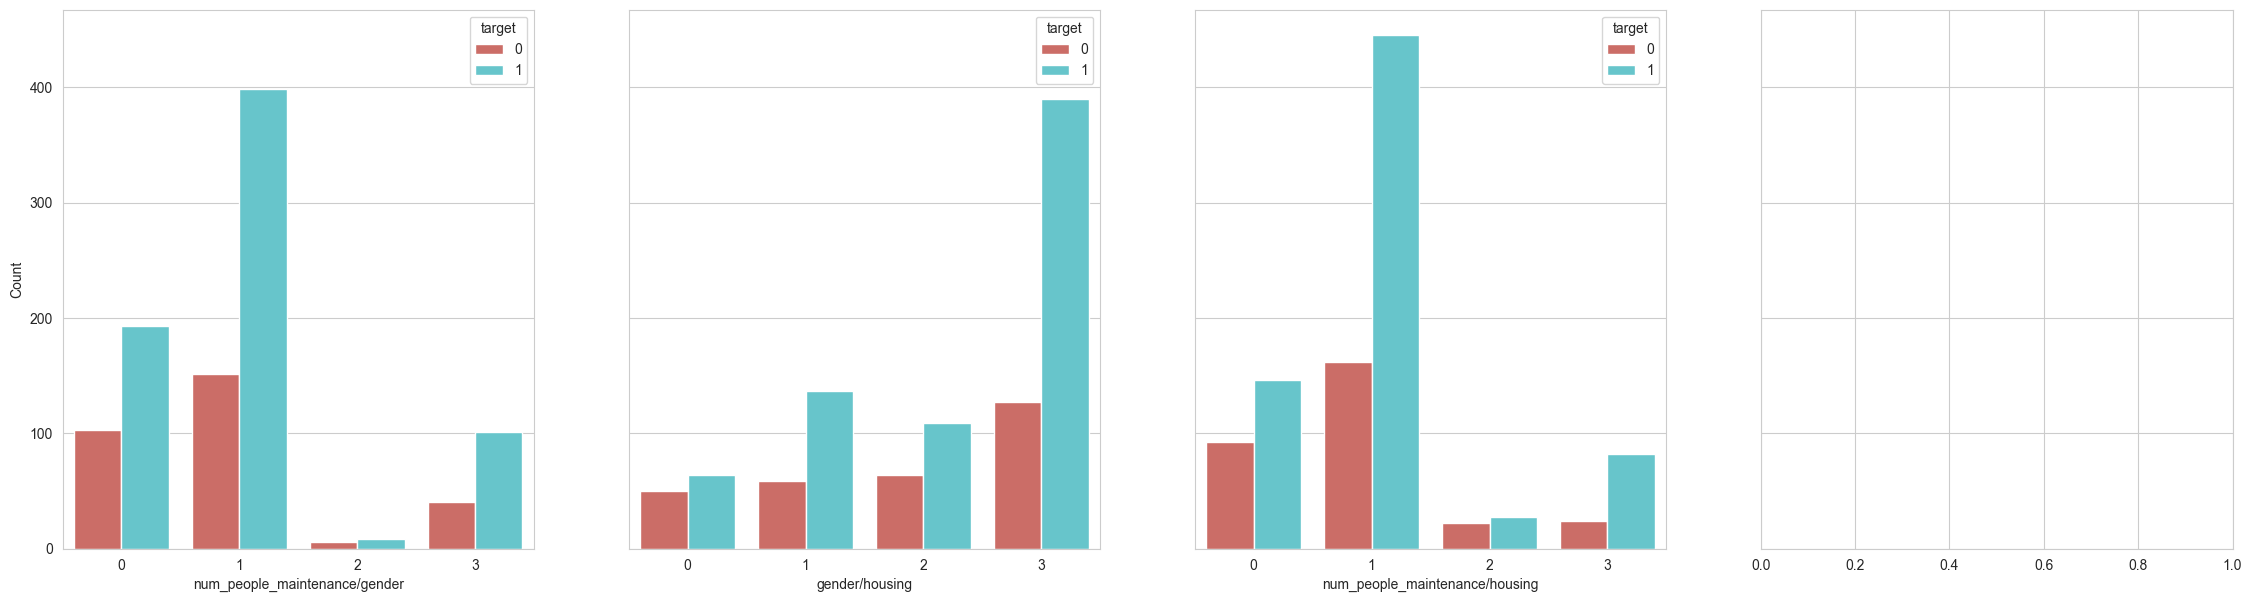

In [7]:
plot_attributes(df,protected_attributes,target=target, num_rows=2, num_cols=3)
plot_attributes(df_intersect, protected_attributes_int, target=target, num_rows=1, num_cols=4)

In [14]:
attr_to_encode = ["acc_status","purpose","credit_history","property","job","employment_time","savings_acc"]

In [15]:
list_of_disparities = ["fnr_disparity","for_disparity","fpr_disparity"]
priv, unpriv = get_priv_and_unpriv_groups(data=df_intersect, protected_attribute=protected_attributes_int)
priv_orig, unpriv_orig = get_priv_and_unpriv_groups(data=df, protected_attribute=protected_attributes)

In [24]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df,protected_attributes,target,attr_to_encode)

['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'gender', 'other_debtors', 'property', 'age', 'installment_plans', 'housing', 'job', 'phone', 'foreigner']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: other_debtors
{'co-applicant': 0, 'guarantor': 1, 'none

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr  \
0                 housing         not own      0.62  0.77  0.43  0.41  0.36   
1                 housing             own      0.73  0.84  0.35  0.63  0.17   
2                  gender          female      0.67  0.79  0.39  0.56  0.25   
3                  gender            male      0.72  0.84  0.39  0.55  0.20   
4  num_people_maintenance               1      0.71  0.83  0.38  0.55  0.22   
5  num_people_maintenance               2      0.70  0.80  0.43  0.57  0.20   

    fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.57  0.23  0.59       0.64  0.24   0.68  0.57  
1  0.65  0.16  0.37       0.83  0.76   0.80  0.79  
2  0.61  0.21  0.44       0.75  0.29   0.73  0.70  
3  0.61  0.16  0.45       0.80  0.71   0.78  0.74  
4  0.62  0.17  0.45       0.78  0.87   0.77  0.73  
5  0.57  0.20  0.43       0.80  0.13   0.74  0.74

Majority class for:  housing  is: own
Majority class for:  gender  is: male
Majority class for:  num_people_maintenance  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0                 housing         not own           2.11           1.42   
1                 housing             own           1.00           1.00   
2                  gender          female           1.24           1.31   
3                  gender            male           1.00           1.00   
4  num_people_maintenance               1           1.00           1.00   
5  num_people_maintenance               2           0.92           1.15   

   for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.65           0.88           1.60           0.31   
1           1.00           1.00           1.00           1.00   
2           1.03           1.00           0.97           0.40   
3           1.00           1.00           1.00           1.00   
4           1.00           1.00           1.00           1.00   
5           1.04           0.93           0.95           0.15   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             0.85                 0.77           1.23           0.92  
1             1.00                 1.00           1.00           1.00  
2             0.94                 0.94           1.00           0.94  
3             1.00                 1.00           1.00           1.00  
4             1.00                 1.00           1.00           1.00  
5             0.96                 1.02           1.12           0.97

dict_keys(['housing', 'gender', 'num_people_maintenance'])
                        fnr_disparity  for_disparity  fpr_disparity
housing                          1.42           0.65           0.88
gender                           1.31           1.03           1.00
num_people_maintenance           1.15           1.04           0.93
Overall average for fnr_disparity:  1.293
Overall average for for_disparity:  0.907
Overall average for fpr_disparity:  0.937


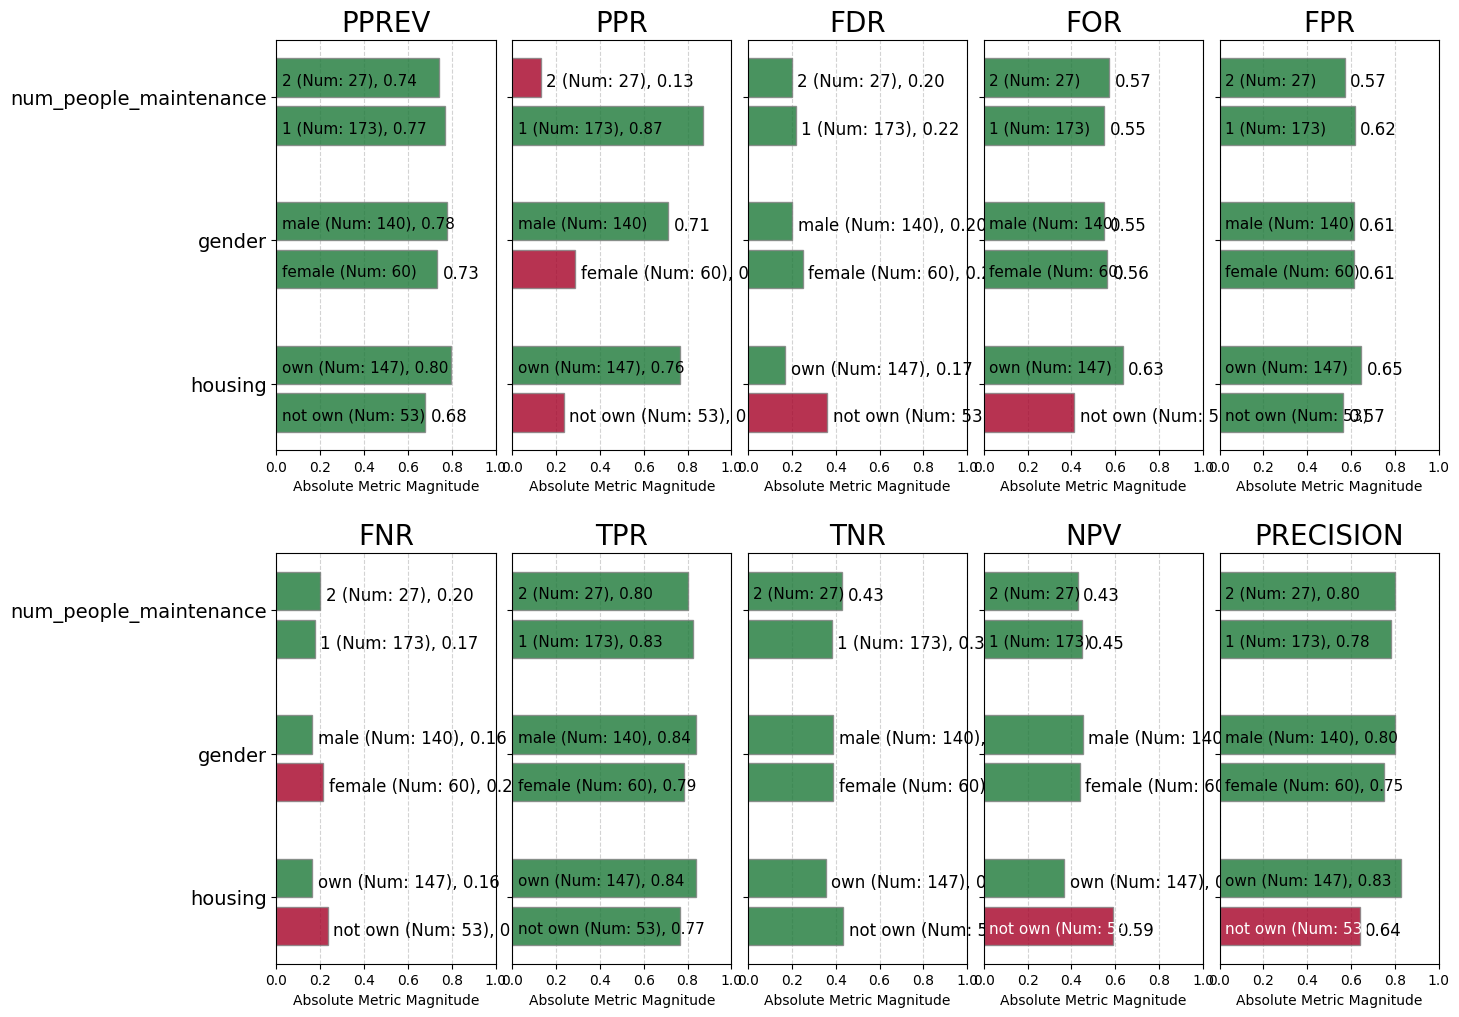

<Figure size 640x480 with 0 Axes>

In [34]:
df_test= calc_fairness_report(x_test, y_test, y_predicted_dict['LogisticRegression'], target, protected_attributes, list_of_disparities,priv_orig,display_disp=True)

['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'other_debtors', 'property', 'age', 'installment_plans', 'job', 'phone', 'foreigner', 'num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: other_debtors
{'co-applicant': 0, 

attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender        1-female      0.65  0.72  0.47   
1    num_people_maintenance/gender          1-male      0.73  0.86  0.37   
2    num_people_maintenance/gender        2-female      1.00  1.00  1.00   
3    num_people_maintenance/gender          2-male      0.71  0.78  0.50   
4                   gender/housing  female-not own      0.65  0.64  0.67   
5                   gender/housing      female-own      0.68  0.77  0.33   
6                   gender/housing    male-not own      0.61  0.79  0.36   
7                   gender/housing        male-own      0.77  0.86  0.41   
8   num_people_maintenance/housing       1-not own      0.60  0.70  0.45   
9   num_people_maintenance/housing           1-own      0.75  0.85  0.37   
10  num_people_maintenance/housing       2-not own      0.83  1.00  0.67   
11  num_people_maintenance/housing           2-own      0.71  0.76  0.50   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.58  0.24  0.53  0.28  0.42       0.76  0.25   0.67  0.70  
1   0.52  0.20  0.63  0.14  0.48       0.80  0.62   0.80  0.74  
2   0.00  0.00  0.00  0.00  1.00       1.00  0.01   0.67  0.67  
3   0.57  0.18  0.50  0.22  0.43       0.82  0.11   0.71  0.75  
4   0.40  0.30  0.33  0.36  0.60       0.70  0.07   0.50  0.55  
5   0.70  0.20  0.67  0.23  0.30       0.80  0.20   0.75  0.78  
6   0.44  0.38  0.64  0.21  0.56       0.62  0.16   0.73  0.58  
7   0.57  0.15  0.59  0.14  0.43       0.85  0.57   0.80  0.79  
8   0.47  0.37  0.55  0.30  0.53       0.63  0.20   0.64  0.57  
9   0.60  0.17  0.63  0.15  0.40       0.83  0.67   0.80  0.79  
10  0.00  0.25  0.33  0.00  1.00       0.75  0.03   0.67  0.50  
11  0.67  0.13  0.50  0.24  0.33       0.87  0.10   0.71  0.81

Majority class for:  num_people_maintenance/gender  is: 1-male
Majority class for:  gender/housing  is: male-own
Majority class for:  num_people_maintenance/housing  is: 1-own
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender        1-female           1.16   
1    num_people_maintenance/gender          1-male           1.00   
2    num_people_maintenance/gender        2-female           0.00   
3    num_people_maintenance/gender          2-male           0.86   
4                   gender/housing  female-not own           1.98   
5                   gender/housing      female-own           1.32   
6                   gender/housing    male-not own           2.48   
7                   gender/housing        male-own           1.00   
8   num_people_maintenance/housing       1-not own           2.18   
9   num_people_maintenance/housing           1-own           1.00   
10  num_people_maintenance/housing       2-not own           1.49   
11  num_people_maintenance/housing           2-own           0.79   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.97           1.11           0.84           0.88           0.41   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00           0.00           0.00           2.09           0.02   
3            1.59           1.10           0.79           0.90           0.18   
4            2.58           0.70           0.56           1.40           0.12   
5            1.60           1.23           1.13           0.70           0.35   
6            1.49           0.78           1.09           1.30           0.28   
7            1.00           1.00           1.00           1.00           1.00   
8            1.96           0.78           0.87           1.32           0.30   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00           0.00           0.53           2.50           0.04   
11           1.55           1.11           0.79           0.83           0.15   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.83                 0.96           1.28           0.84  
1              1.00                 1.00           1.00           1.00  
2              0.83                 1.26           2.73           1.16  
3              0.88                 1.03           1.36           0.90  
4              0.62                 0.82           1.63           0.74  
5              0.93                 0.94           0.81           0.90  
6              0.90                 0.74           0.87           0.92  
7              1.00                 1.00           1.00           1.00  
8              0.80                 0.76           1.22           0.83  
9              1.00                 1.00           1.00           1.00  
10             0.83                 0.90           1.80           1.18  
11             0.89                 1.04           1.35           0.90

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        1.186667       0.736667       0.543333
gender/housing                       1.890000       0.903333       0.926667
num_people_maintenance/housing       1.170000       0.630000       0.730000
Overall average for fnr_disparity:  1.416
Overall average for for_disparity:  0.757
Overall average for fpr_disparity:  0.733


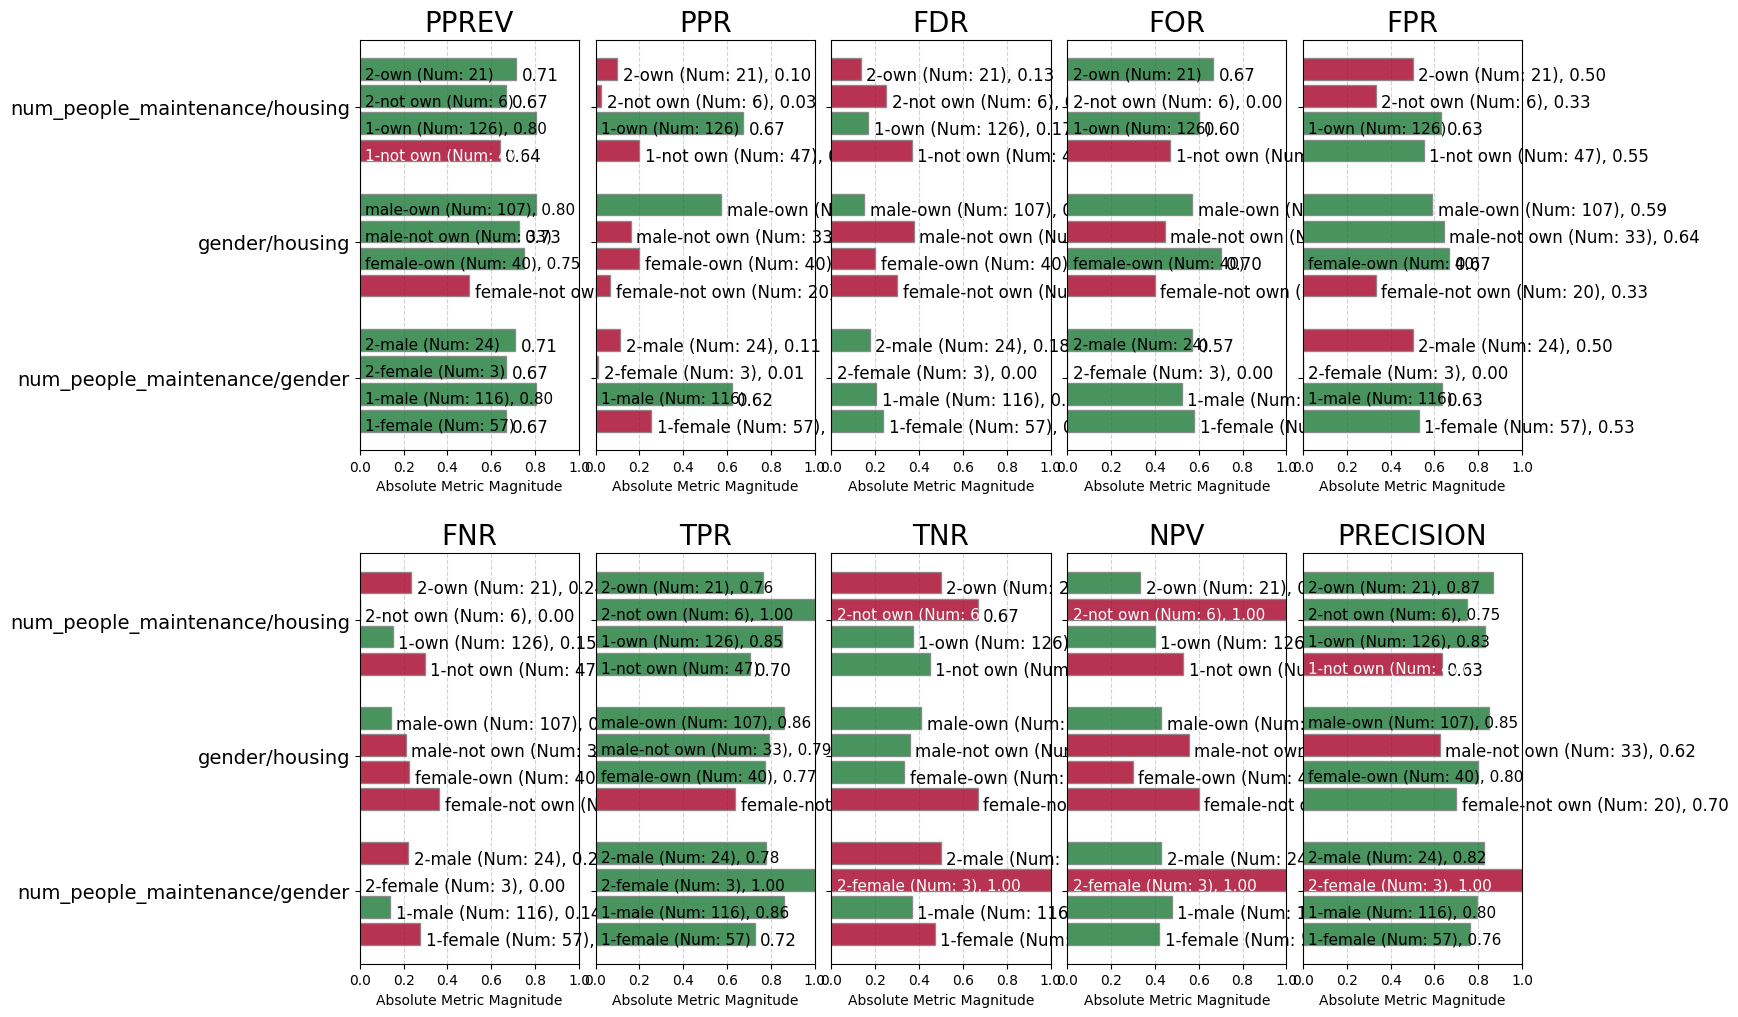

<Figure size 640x480 with 0 Axes>

In [35]:
to_encode = protected_attributes_int+attr_to_encode
"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_intersect,protected_attributes_int,target,to_encode)
df_test_int= calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['LogisticRegression'], target, protected_attributes_int, list_of_disparities,priv, display_disp=True)    

In [ ]:
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)

---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.81, random_state=42, solver='liblinear')
Accuracy score training:
0.7825
Accuracy score test:
0.7550
----------------------------------------



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.77  0.90  0.40   
1    num_people_maintenance/gender               1      0.76  0.89  0.49   
2    num_people_maintenance/gender               2      0.67  0.67   NaN   
3    num_people_maintenance/gender               3      0.71  0.83  0.33   
4                   gender/housing               0      0.70  0.79  0.50   
5                   gender/housing               1      0.80  0.94  0.33   
6                   gender/housing               2      0.70  0.90  0.38   
7                   gender/housing               3      0.77  0.87  0.50   
8   num_people_maintenance/housing               0      0.70  0.83  0.47   
9   num_people_maintenance/housing               1      0.79  0.91  0.46   
10  num_people_maintenance/housing               2      0.67  1.00  0.00   
11  num_people_maintenance/housing               3      0.71  0.76  0.50   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.40  0.19  0.60  0.10  0.60       0.81  0.30   0.82  0.74  
1   0.33  0.21  0.51  0.11  0.67       0.79  0.57   0.77  0.68  
2   1.00  0.00   NaN  0.33  0.00       1.00  0.01   0.67  1.00  
3   0.60  0.21  0.67  0.17  0.40       0.79  0.12   0.79  0.75  
4   0.50  0.21  0.50  0.21  0.50       0.79  0.09   0.70  0.70  
5   0.40  0.17  0.67  0.06  0.60       0.83  0.22   0.88  0.78  
6   0.29  0.31  0.62  0.10  0.71       0.69  0.17   0.79  0.61  
7   0.40  0.18  0.50  0.13  0.60       0.82  0.52   0.77  0.72  
8   0.38  0.26  0.53  0.17  0.62       0.74  0.22   0.72  0.64  
9   0.33  0.19  0.54  0.09  0.67       0.81  0.65   0.81  0.72  
10   NaN  0.33  1.00  0.00   NaN       0.67  0.04   1.00  0.67  
11  0.67  0.13  0.50  0.24  0.33       0.87  0.10   0.71  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.90   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           0.00   
3    num_people_maintenance/gender               3           0.99   
4                   gender/housing               0           1.17   
5                   gender/housing               1           0.94   
6                   gender/housing               2           1.68   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.42   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           1.79   
11  num_people_maintenance/housing               3           0.72   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.84           1.20           1.17           0.90           0.53   
1            1.00           1.00           1.00           1.00           1.00   
2            2.93           3.00            NaN           0.00           0.02   
3            1.46           1.80           1.30           0.60           0.21   
4            1.65           1.25           1.00           0.83           0.17   
5            0.50           1.00           1.33           1.00           0.43   
6            0.77           0.71           1.23           1.19           0.32   
7            1.00           1.00           1.00           1.00           1.00   
8            1.90           1.15           0.98           0.92           0.33   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00            NaN           1.84            NaN           0.06   
11           2.68           2.00           0.92           0.50           0.15   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.07                 1.03           0.82           1.02  
1              1.00                 1.00           1.00           1.00  
2              0.87                 1.27            NaN           0.75  
3              1.03                 1.00           0.69           0.94  
4              0.91                 0.96           1.00           0.90  
5              1.14                 1.01           0.67           1.08  
6              1.03                 0.85           0.77           1.03  
7              1.00                 1.00           1.00           1.00  
8              0.89                 0.90           1.03           0.91  
9              1.00                 1.00           1.00           1.00  
10             1.24                 0.82           0.00           1.10  
11             0.88                 1.07           1.09           0.84

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        1.743333       2.000000       1.235000
gender/housing                       0.973333       0.986667       1.186667
num_people_maintenance/housing       1.526667       1.575000       1.246667
Overall average for fnr_disparity:  1.414
Overall average for for_disparity:  1.521
Overall average for fpr_disparity:  1.223


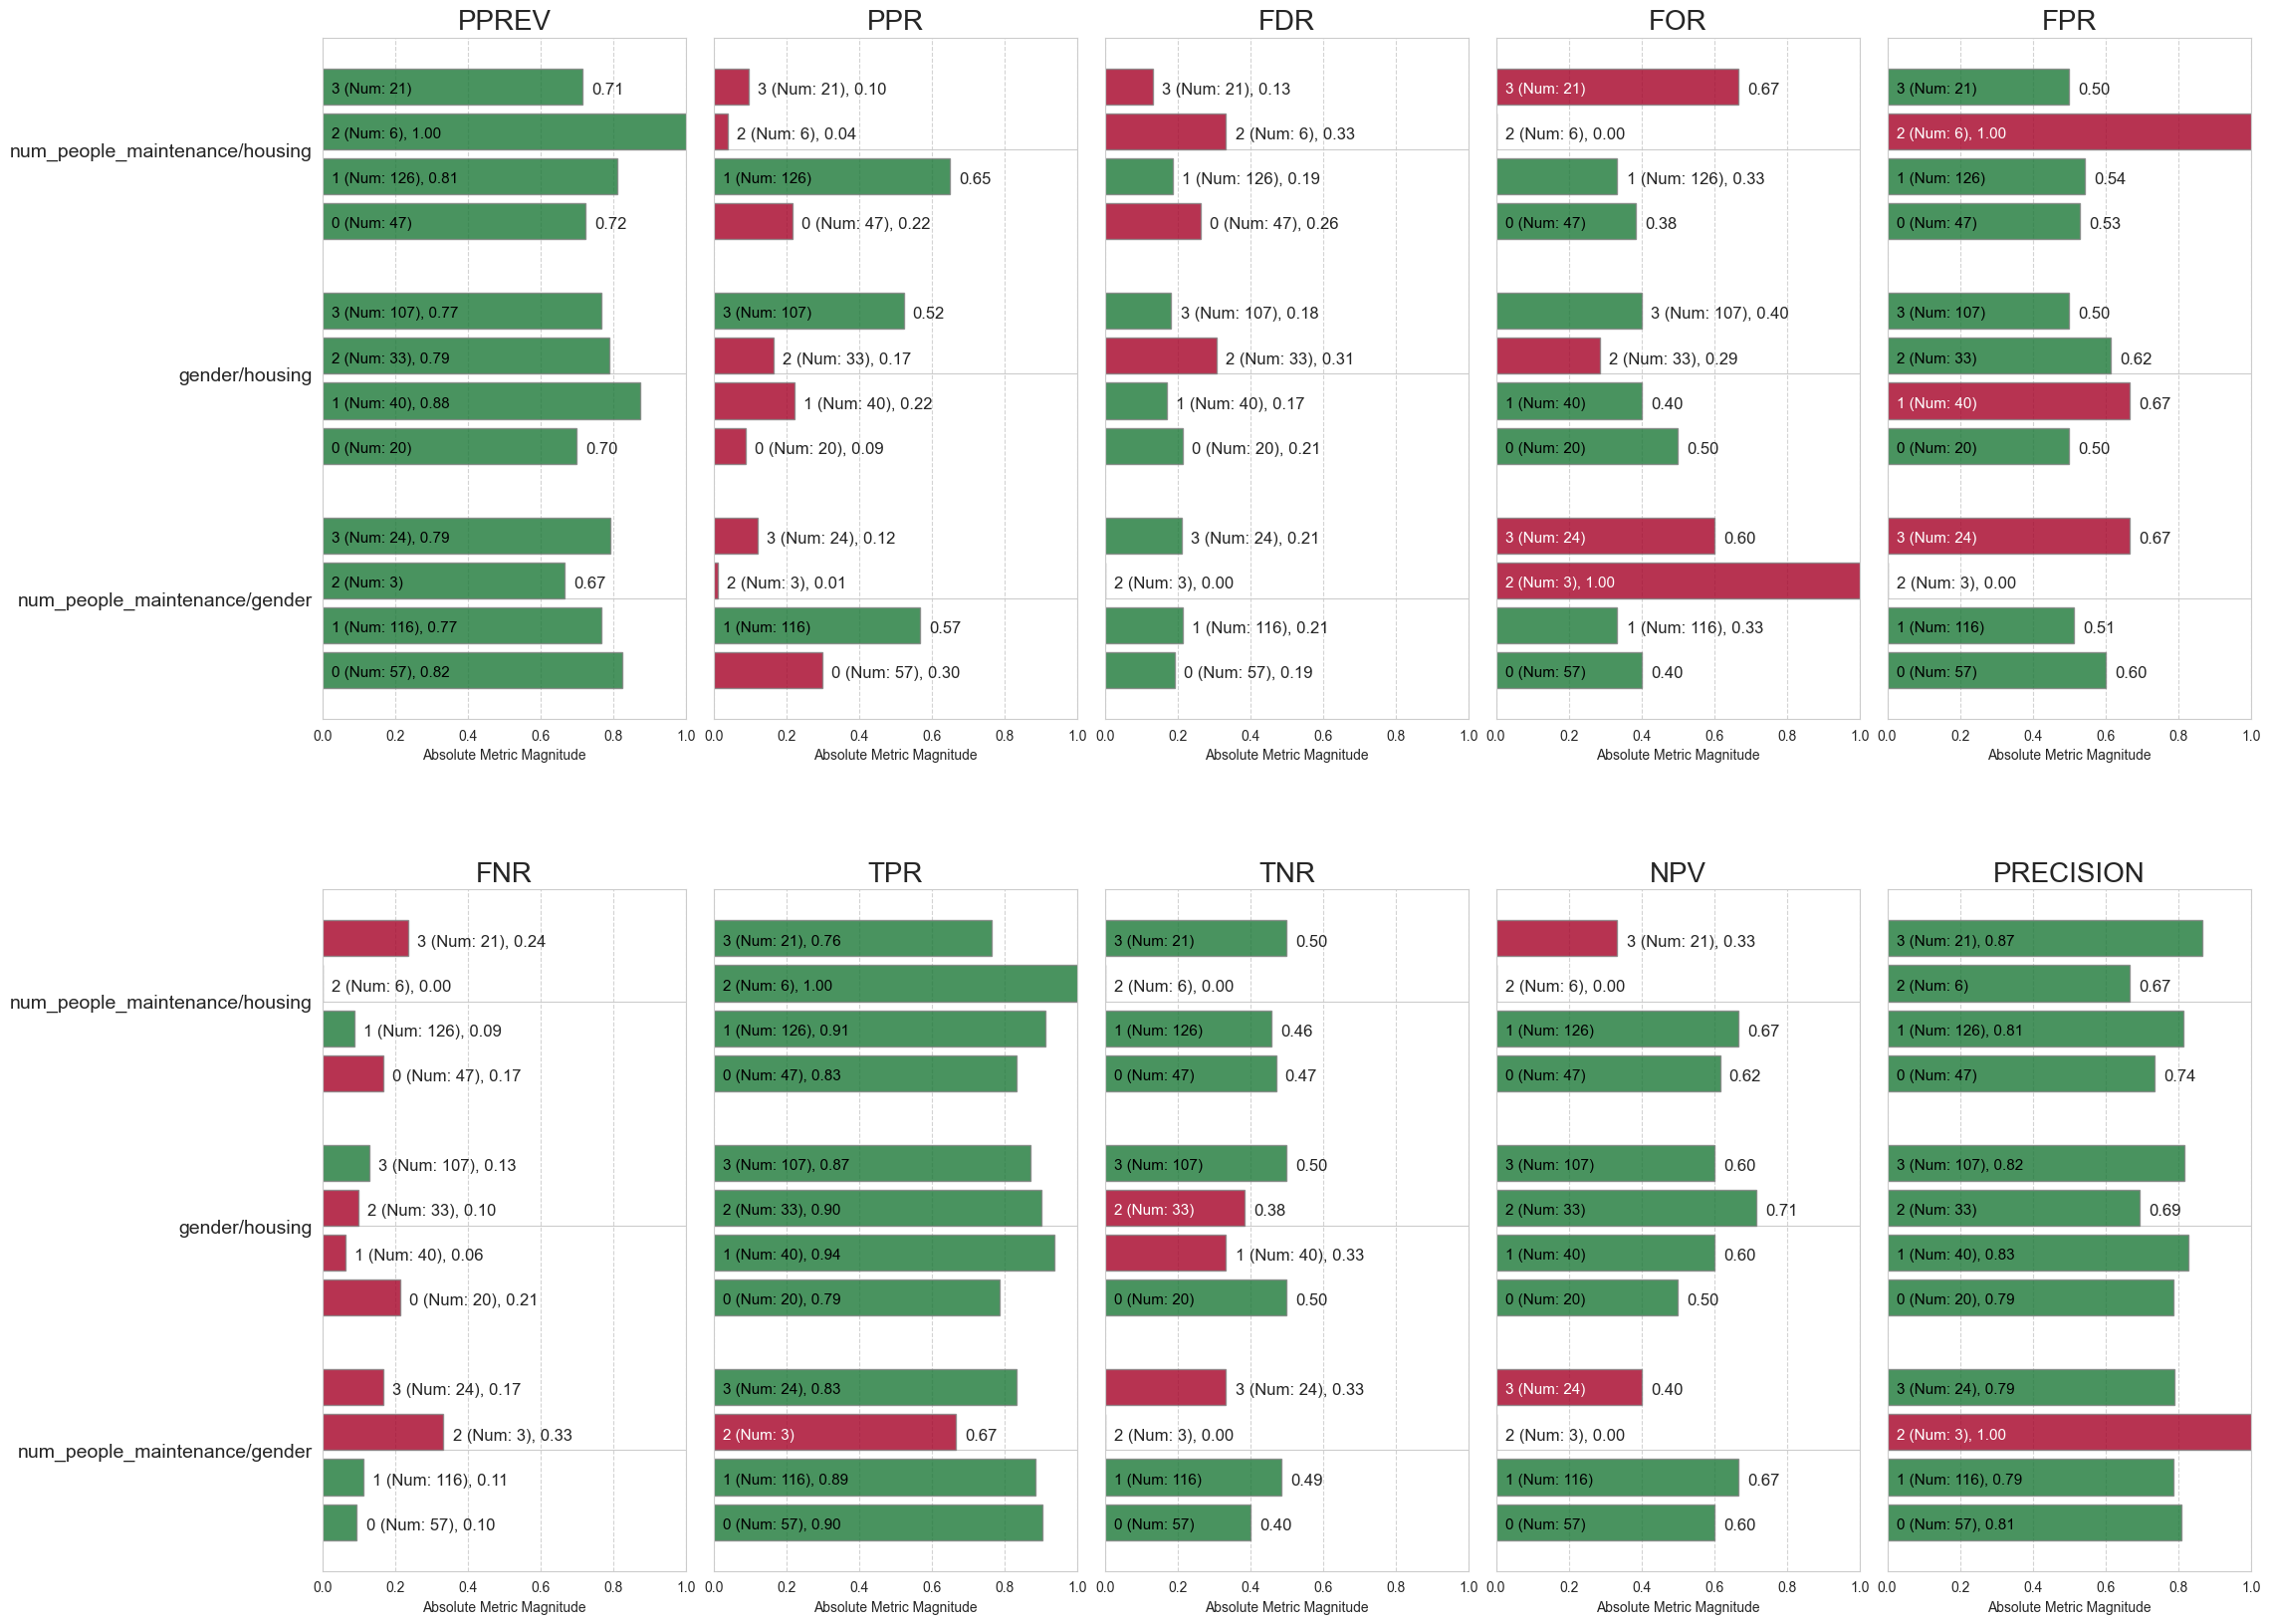

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False        True              True   
1       False       False       False       False             False   
2       False        True       False       False              True   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [111]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_m = prep_massaging(df_num_int, protected_attributes_int,target)

#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_transformed_m,protected_attributes_int,target,to_encode)
#calculate the fairness report
df_test_transformed=calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["LogisticRegression"],target,protected_attributes_int, list_of_disparities,priv, display_disp=True)

[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 0 size: 296


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 296


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 0 size: 343


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 343


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 1 size: 549


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 549


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 1 size: 569


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 569


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 3 size: 141


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 141


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 3 size: 144


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 144


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 2 size: 14


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 14


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 2 size: 20


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 20


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 1 size: 235


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 235


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 1 size: 251


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 251


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 3 size: 536


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 536


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 3 size: 564


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 564


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 0 size: 128


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 128


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 0 size: 184


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 184


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 2 size: 177


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 177


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 2 size: 227


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 227


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 1 size: 701


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 701


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 1 size: 743


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 743


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 0 size: 351


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 351


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 0 size: 369


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 369


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 2 size: 60


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 60


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 2 size: 90


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 90


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Original group 3 size: 114


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 114


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Final group 3 size: 125


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 125


[INFO] 2024-11-22 18:33:42 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.81, random_state=42, solver='liblinear')
Accuracy score training:
0.7248
Accuracy score test:
0.7030
----------------------------------------



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.72  0.98  0.08   
1    num_people_maintenance/gender               1      0.67  0.88  0.16   
2    num_people_maintenance/gender               2      0.80  1.00  0.00   
3    num_people_maintenance/gender               3      0.79  0.87  0.50   
4                   gender/housing               0      0.61  0.95  0.08   
5                   gender/housing               1      0.79  1.00  0.08   
6                   gender/housing               2      0.72  0.88  0.23   
7                   gender/housing               3      0.68  0.88  0.19   
8   num_people_maintenance/housing               0      0.68  0.90  0.17   
9   num_people_maintenance/housing               1      0.69  0.93  0.11   
10  num_people_maintenance/housing               2      0.67  0.89  0.00   
11  num_people_maintenance/housing               3      0.86  0.89  0.75   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.33  0.28  0.92  0.02  0.67       0.72  0.34   0.96  0.71  
1   0.63  0.28  0.84  0.12  0.37       0.72  0.54   0.87  0.71  
2    NaN  0.20  1.00  0.00   NaN       0.80  0.02   1.00  0.80  
3   0.50  0.13  0.50  0.13  0.50       0.87  0.10   0.79  0.79  
4   0.50  0.39  0.92  0.05  0.50       0.61  0.13   0.94  0.61  
5   0.00  0.21  0.92  0.00  1.00       0.79  0.24   0.98  0.77  
6   0.62  0.22  0.77  0.12  0.38       0.78  0.19   0.85  0.76  
7   0.59  0.28  0.81  0.12  0.41       0.72  0.44   0.86  0.70  
8   0.56  0.29  0.83  0.10  0.44       0.71  0.28   0.88  0.69  
9   0.62  0.28  0.89  0.07  0.38       0.72  0.61   0.92  0.71  
10  1.00  0.27  1.00  0.11  0.00       0.73  0.05   0.92  0.75  
11  0.40  0.06  0.25  0.11  0.60       0.94  0.07   0.77  0.82

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.00   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           0.71   
3    num_people_maintenance/gender               3           0.46   
4                   gender/housing               0           1.40   
5                   gender/housing               1           0.78   
6                   gender/housing               2           0.79   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.04   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           0.98   
11  num_people_maintenance/housing               3           0.21   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.14           0.53           1.10           1.81           0.64   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.19            NaN           0.04   
3            1.13           0.79           0.60           1.36           0.18   
4            0.43           0.85           1.15           1.21           0.30   
5            0.00           0.00           1.15           2.43           0.53   
6            1.05           1.06           0.95           0.91           0.44   
7            1.00           1.00           1.00           1.00           1.00   
8            1.35           0.90           0.93           1.16           0.46   
9            1.00           1.00           1.00           1.00           1.00   
10           1.56           1.62           1.12           0.00           0.08   
11           1.56           0.65           0.28           1.56           0.12   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.11                 1.00           0.49           1.11  
1              1.00                 1.00           1.00           1.00  
2              1.15                 1.11           0.00           1.13  
3              0.91                 1.21           3.07           0.98  
4              1.09                 0.85           0.40           1.08  
5              1.14                 1.09           0.40           1.13  
6              0.99                 1.08           1.19           0.99  
7              1.00                 1.00           1.00           1.00  
8              0.96                 0.99           1.57           0.97  
9              1.00                 1.00           1.00           1.00  
10             1.00                 1.01           0.00           0.96  
11             0.84                 1.30           6.75           0.96

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        0.423333       0.660000       0.963333
gender/housing                       0.493333       0.636667       1.083333
num_people_maintenance/housing       1.490000       1.056667       0.776667
Overall average for fnr_disparity:  0.802
Overall average for for_disparity:  0.784
Overall average for fpr_disparity:  0.941


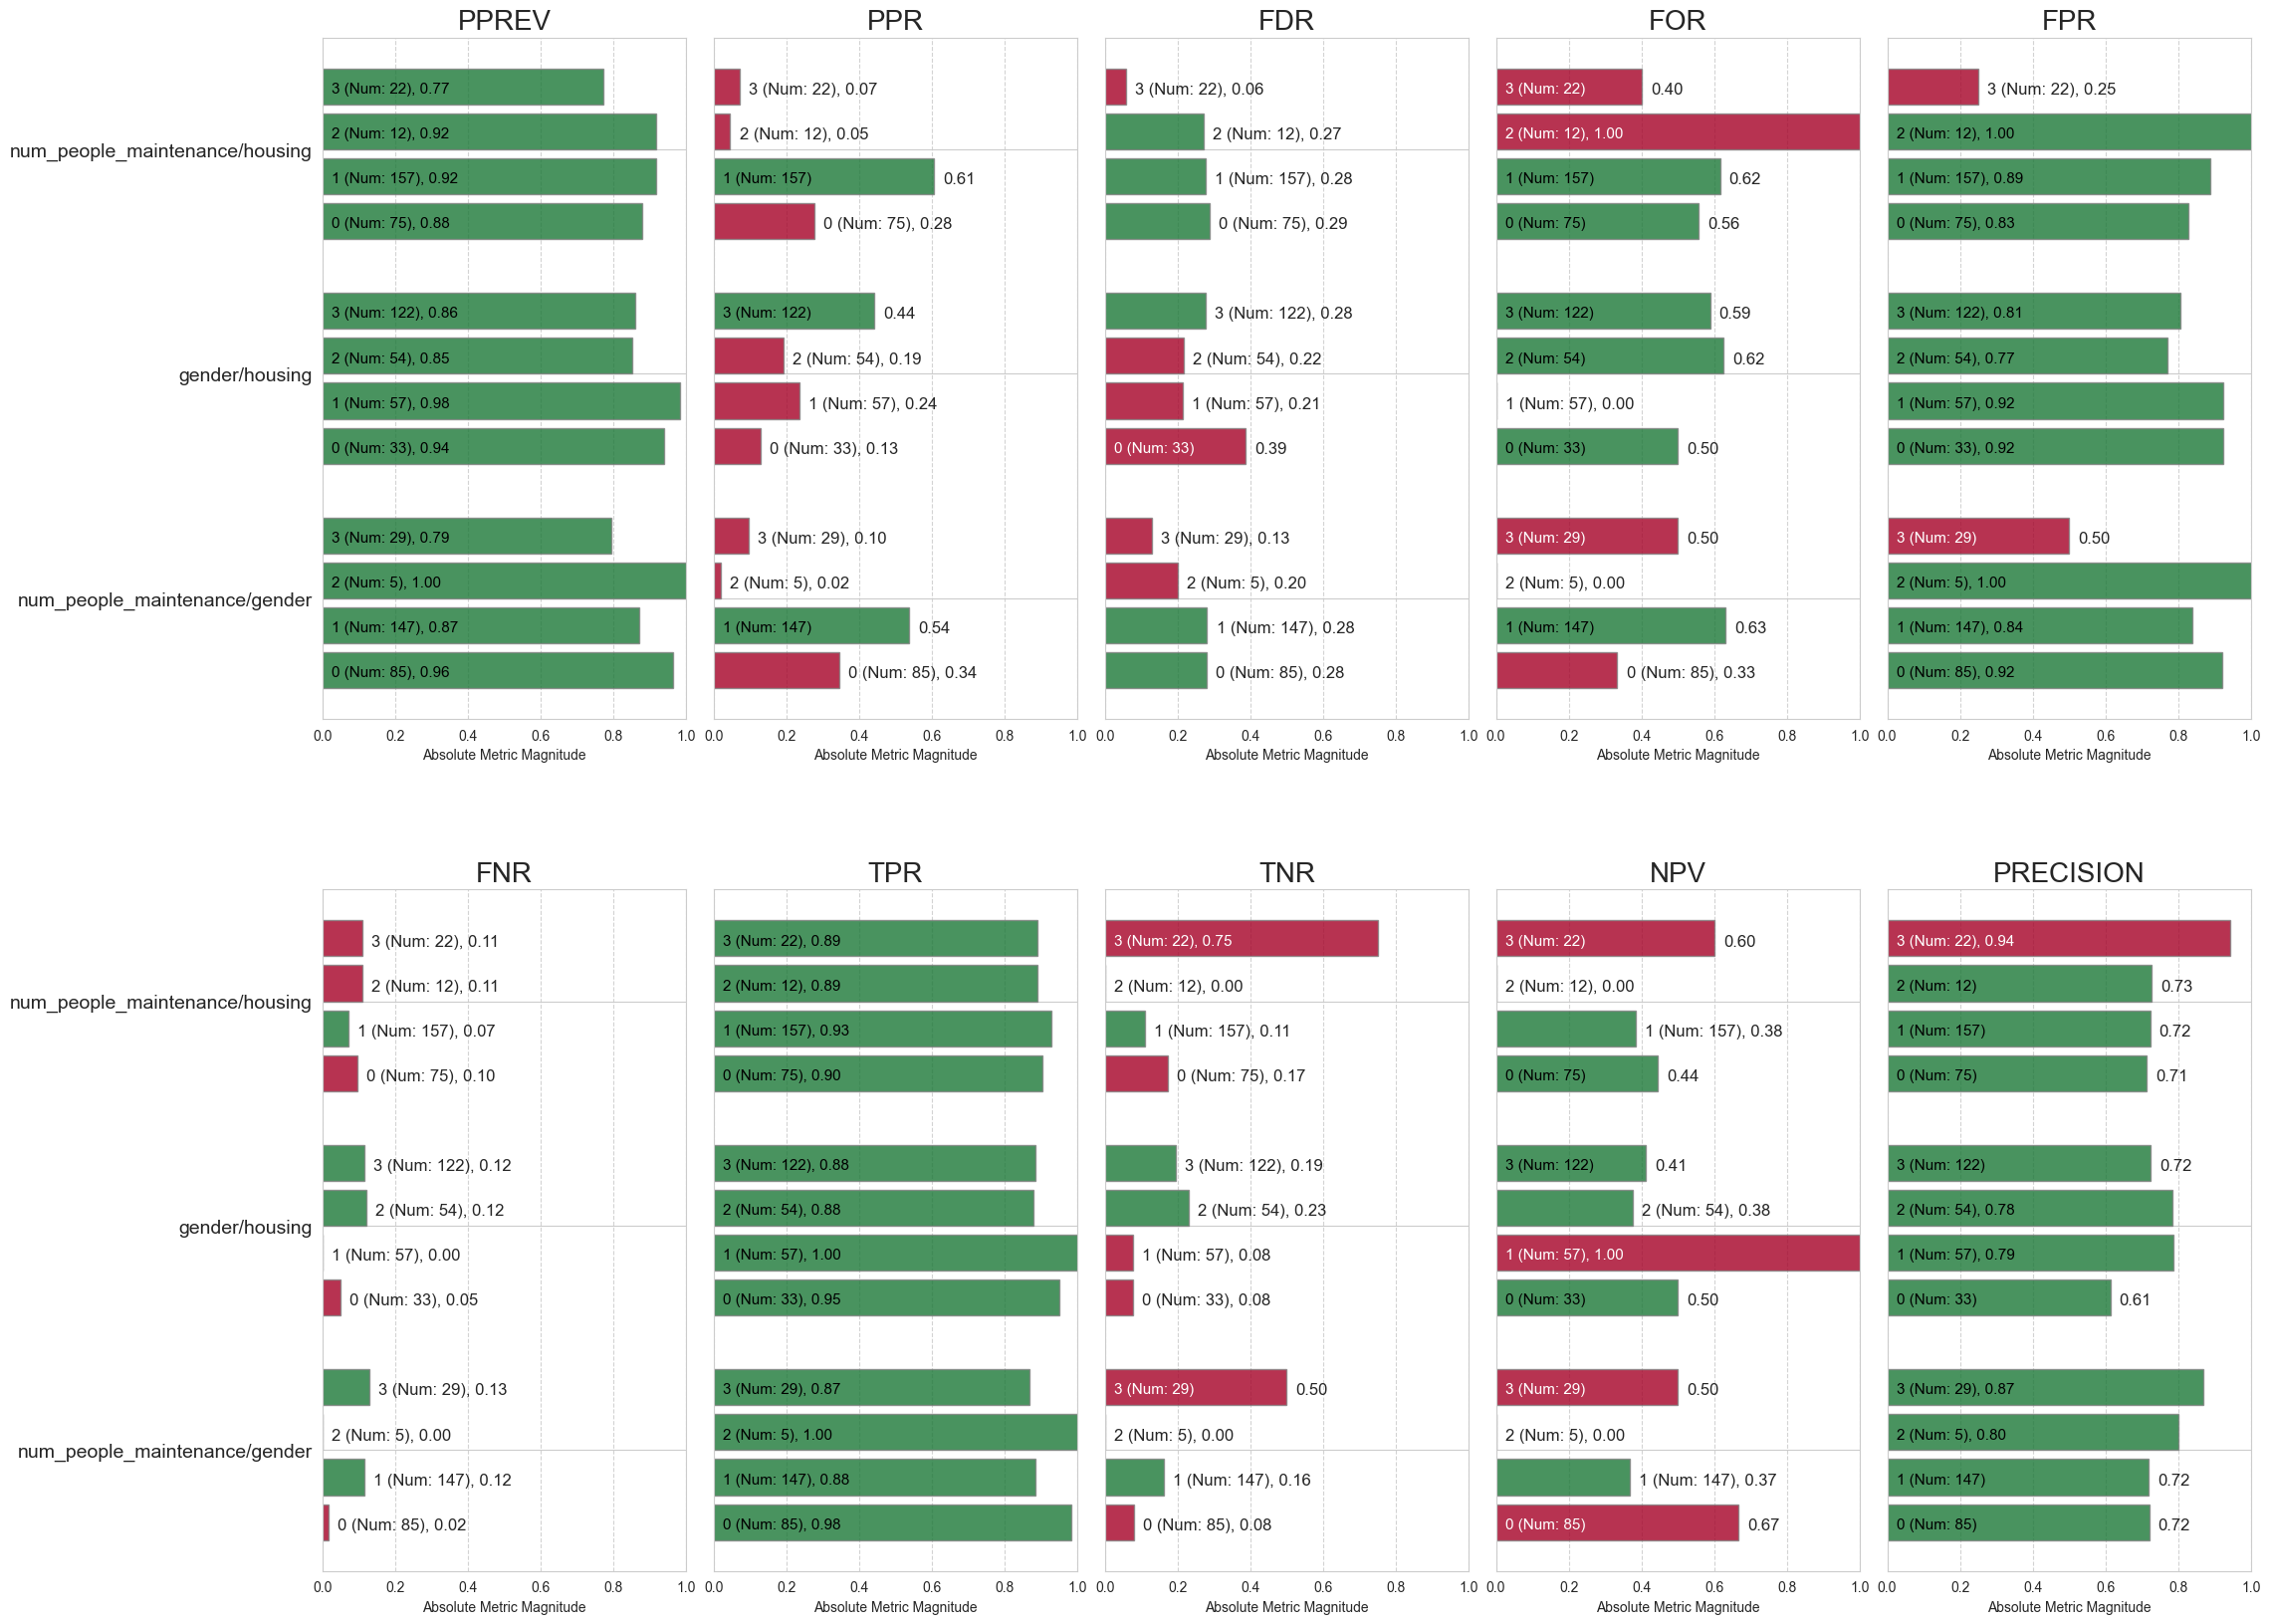

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False        True       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False              True   
1       False        True       False       False              True   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False            True                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [112]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps = prep_prev_sampling(df_num_int, protected_attributes_int,target)

#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps,protected_attributes_int,target)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["LogisticRegression"],target,protected_attributes_int, list_of_disparities,priv, display_disp=True)


---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.7100000000000001, penalty='l1', random_state=42,
                   solver='liblinear')
Accuracy score training:
0.7262
Accuracy score test:
0.7500
----------------------------------------



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.77  0.92  0.41   
1    num_people_maintenance/gender               1      0.74  0.95  0.13   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.75  1.00  0.00   
4                   gender/housing               0      0.70  0.82  0.56   
5                   gender/housing               1      0.80  0.97  0.22   
6                   gender/housing               2      0.55  0.89  0.07   
7                   gender/housing               3      0.80  0.98  0.14   
8   num_people_maintenance/housing               0      0.62  0.85  0.30   
9   num_people_maintenance/housing               1      0.80  0.97  0.19   
10  num_people_maintenance/housing               2      0.50  1.00  0.00   
11  num_people_maintenance/housing               3      0.81  1.00  0.00   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.30  0.21  0.59  0.08  0.70       0.79  0.26   0.82  0.70  
1   0.50  0.24  0.87  0.05  0.50       0.76  0.59   0.93  0.74  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3    NaN  0.25  1.00  0.00   NaN       0.75  0.13   1.00  0.75  
4   0.29  0.31  0.44  0.18  0.71       0.69  0.07   0.65  0.55  
5   0.33  0.19  0.78  0.03  0.67       0.81  0.20   0.92  0.78  
6   0.67  0.43  0.93  0.11  0.33       0.57  0.16   0.91  0.58  
7   0.40  0.19  0.86  0.02  0.60       0.81  0.56   0.95  0.79  
8   0.40  0.38  0.70  0.15  0.60       0.62  0.20   0.79  0.57  
9   0.38  0.19  0.81  0.03  0.62       0.81  0.65   0.94  0.79  
10   NaN  0.50  1.00  0.00   NaN       0.50  0.03   1.00  0.50  
11   NaN  0.19  1.00  0.00   NaN       0.81  0.12   1.00  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.88   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.38   
3    num_people_maintenance/gender               3           1.04   
4                   gender/housing               0           1.65   
5                   gender/housing               1           1.02   
6                   gender/housing               2           2.33   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           2.03   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.68   
11  num_people_maintenance/housing               3           1.02   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.61           0.60           0.68           1.40           0.44   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.15            NaN           0.03   
3            0.00            NaN           1.15            NaN           0.22   
4            7.73           0.71           0.51           1.19           0.13   
5            1.37           0.83           0.90           1.11           0.36   
6            4.47           1.67           1.08           0.56           0.29   
7            1.00           1.00           1.00           1.00           1.00   
8            4.89           1.07           0.86           0.96           0.31   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00            NaN           1.23            NaN           0.05   
11           0.00            NaN           1.23            NaN           0.18   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.89                 1.04           3.09           0.97  
1              1.00                 1.00           1.00           1.00  
2              1.07                 0.88           0.00           1.05  
3              1.07                 0.99           0.00           1.05  
4              0.68                 0.85           4.07           0.84  
5              0.97                 1.00           1.63           0.99  
6              0.95                 0.70           0.52           0.92  
7              1.00                 1.00           1.00           1.00  
8              0.84                 0.76           1.62           0.88  
9              1.00                 1.00           1.00           1.00  
10             1.07                 0.61           0.00           1.03  
11             1.07                 1.00           0.00           1.03

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        0.536667           0.60       0.993333
gender/housing                       4.523333           1.07       0.830000
num_people_maintenance/housing       1.630000           1.07       1.106667
Overall average for fnr_disparity:  2.230
Overall average for for_disparity:  0.913
Overall average for fpr_disparity:  0.977


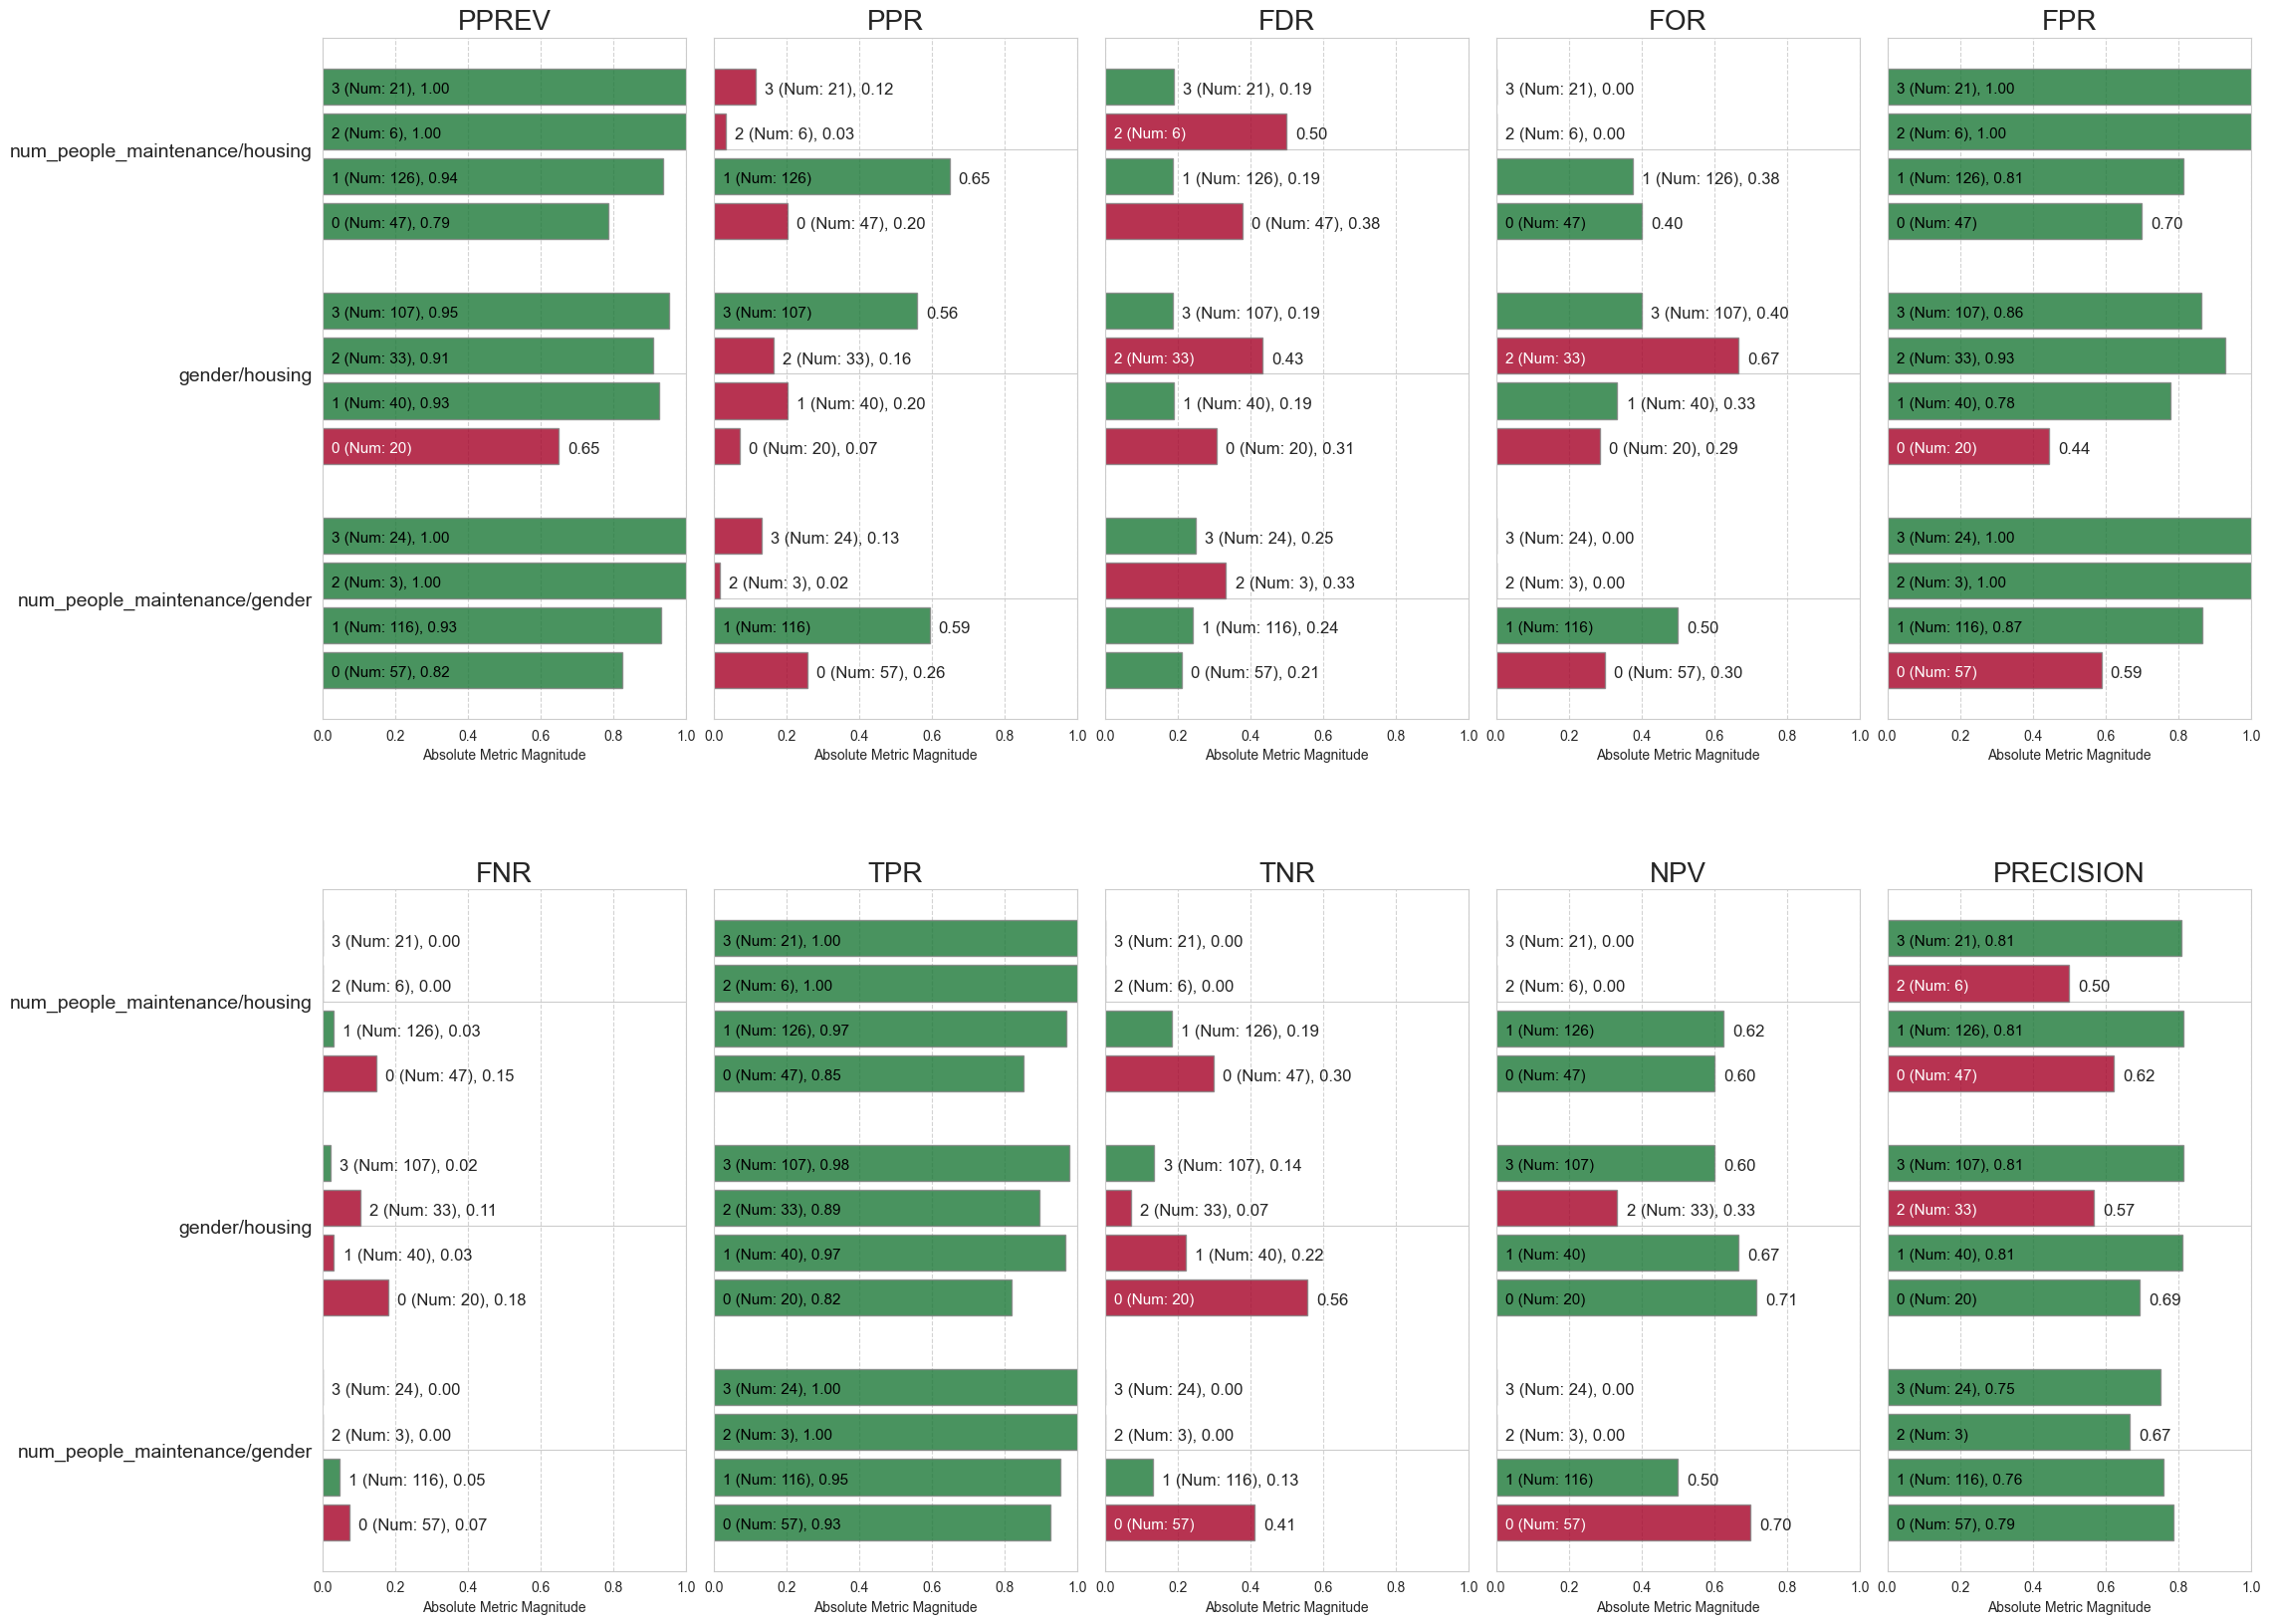

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False           True       False       False       False   
2               False           True       False        True        True   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False        True       False       False              True   
2       False        True       False        True             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False            True                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [113]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''

#transform data
data_to_transform = df_num_int.copy()
data_transformed_dr = prep_data_repairer(df_num_int,protected_attributes_int,target)

#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_transformed_dr,protected_attributes_int,target)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["LogisticRegression"],target,protected_attributes_int,list_of_disparities,priv, display_disp=True)

[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Flipped 13 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 13 instances.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Flipped 32 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 32 instances.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Flipped 32 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 32 instances.


[INFO] 2024-11-22 18:34:51 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.91, random_state=42, solver='liblinear')
Accuracy score training:
0.7600
Accuracy score test:
0.8100
----------------------------------------



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.79  0.93  0.25   
1    num_people_maintenance/gender               1      0.83  0.99  0.21   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.79  0.95  0.20   
4                   gender/housing               0      0.75  0.93  0.20   
5                   gender/housing               1      0.80  0.94  0.25   
6                   gender/housing               2      0.79  1.00  0.22   
7                   gender/housing               3      0.83  0.98  0.20   
8   num_people_maintenance/housing               0      0.79  0.97  0.18   
9   num_people_maintenance/housing               1      0.83  0.97  0.24   
10  num_people_maintenance/housing               2      0.67  1.00  0.33   
11  num_people_maintenance/housing               3      0.81  0.94  0.00   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.50  0.18  0.75  0.07  0.50       0.82  0.27   0.89  0.79  
1   0.17  0.17  0.79  0.01  0.83       0.83  0.59   0.95  0.79  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3   0.50  0.18  0.80  0.05  0.50       0.82  0.12   0.92  0.79  
4   0.50  0.22  0.80  0.07  0.50       0.78  0.10   0.90  0.75  
5   0.50  0.17  0.75  0.06  0.50       0.83  0.19   0.90  0.80  
6   0.00  0.23  0.78  0.00  1.00       0.77  0.17   0.94  0.73  
7   0.33  0.16  0.80  0.02  0.67       0.84  0.54   0.94  0.81  
8   0.33  0.20  0.82  0.03  0.67       0.80  0.24   0.94  0.77  
9   0.33  0.16  0.76  0.03  0.67       0.84  0.63   0.93  0.80  
10  0.00  0.40  0.67  0.00  1.00       0.60  0.03   0.83  0.50  
11  1.00  0.15  1.00  0.06  0.00       0.85  0.11   0.95  0.86

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.02   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.93   
3    num_people_maintenance/gender               3           1.05   
4                   gender/housing               0           1.40   
5                   gender/housing               1           1.05   
6                   gender/housing               2           1.43   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.26   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.46   
11  num_people_maintenance/housing               3           0.92   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            6.13            3.0           0.95           0.60           0.46   
1            1.00            1.0           1.00           1.00           1.00   
2            0.00            NaN           1.26            NaN           0.03   
3            4.84            3.0           1.01           0.60           0.20   
4            2.90            1.5           1.00           0.75           0.18   
5            2.72            1.5           0.94           0.75           0.36   
6            0.00            0.0           0.97           1.50           0.31   
7            1.00            1.0           1.00           1.00           1.00   
8            0.94            1.0           1.08           1.00           0.38   
9            1.00            1.0           1.00           1.00           1.00   
10           0.00            0.0           0.88           1.50           0.04   
11           1.87            3.0           1.32           0.00           0.17   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.94                 1.00           1.20           0.94  
1              1.00                 1.00           1.00           1.00  
2              1.05                 0.81           0.00           1.01  
3              0.97                 0.99           0.96           0.96  
4              0.95                 0.92           1.00           0.96  
5              0.95                 0.99           1.25           0.96  
6              1.00                 0.92           1.11           1.02  
7              1.00                 1.00           1.00           1.00  
8              1.01                 0.95           0.76           1.00  
9              1.00                 1.00           1.00           1.00  
10             0.90                 0.72           1.39           1.03  
11             1.03                 1.01           0.00           0.97

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        3.656667       3.000000       1.073333
gender/housing                       1.873333       1.000000       0.970000
num_people_maintenance/housing       0.936667       1.333333       1.093333
Overall average for fnr_disparity:  2.156
Overall average for for_disparity:  1.778
Overall average for fpr_disparity:  1.046


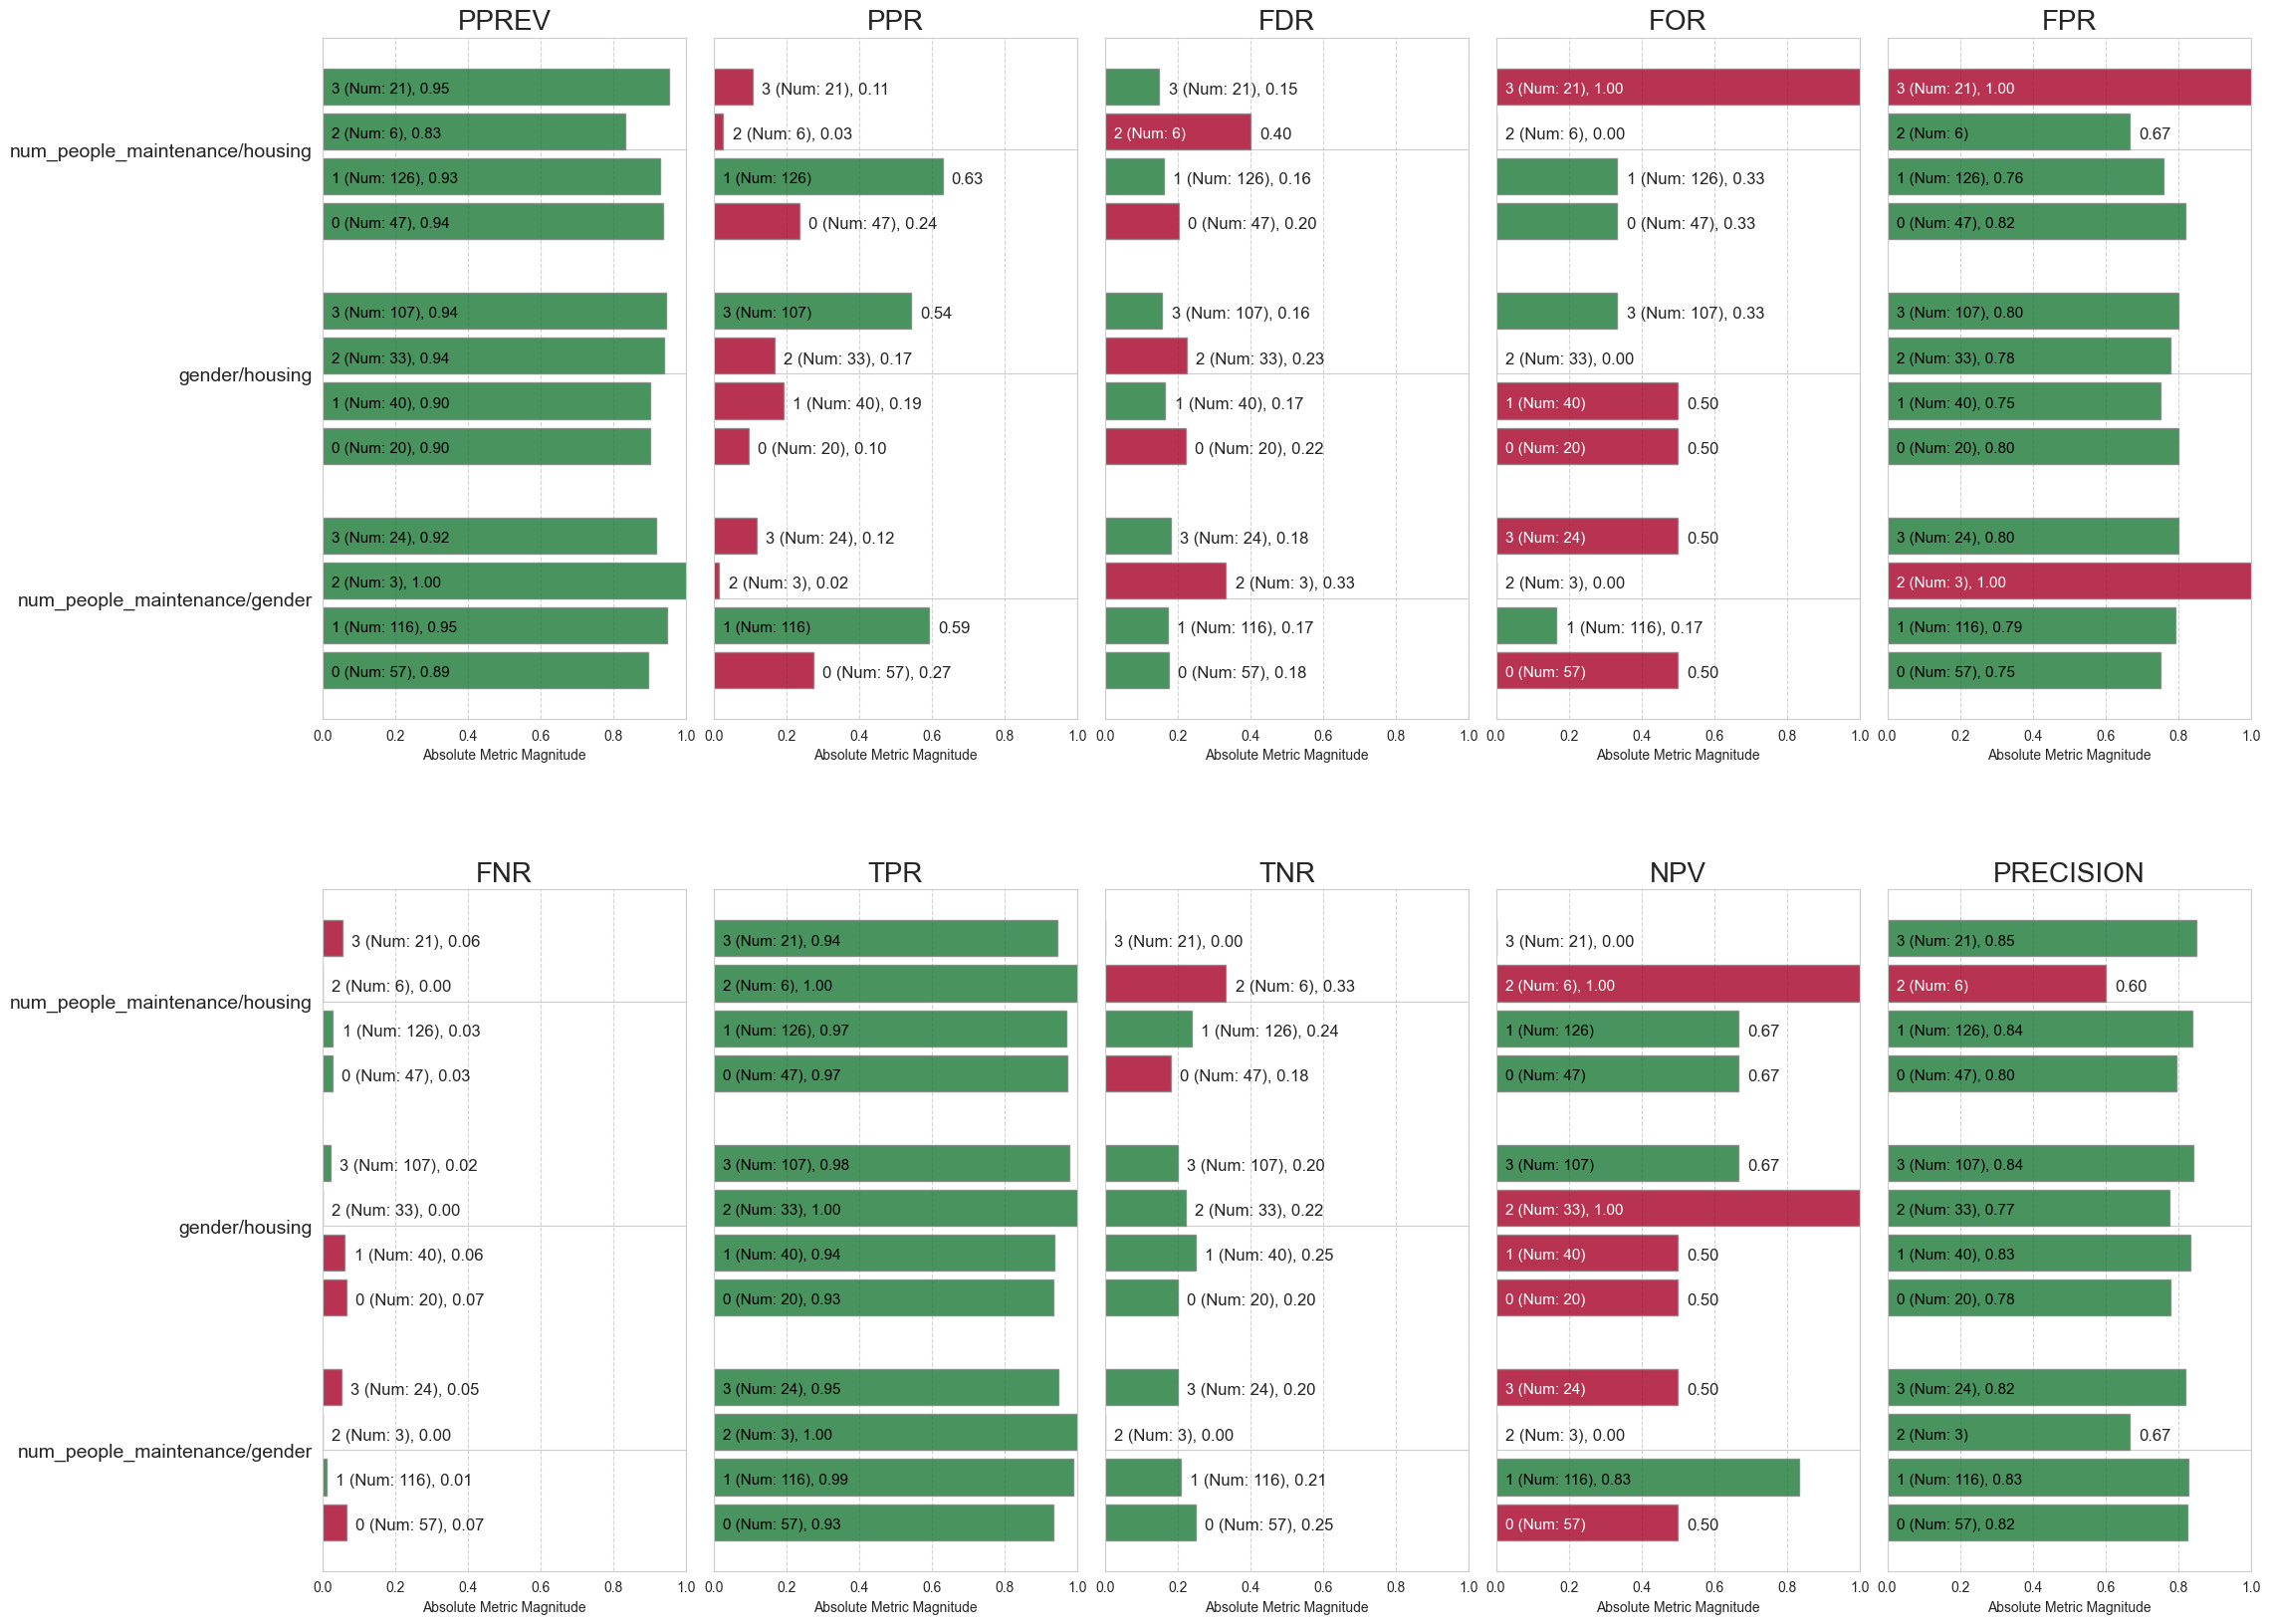

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False        True       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True        True       False              True   
1       False        True       False       False              True   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False            True                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [114]:
'''
4. Label flipping
'''

#transform data
data_to_transform = df_num_int.copy()
data_transformed_lf = prep_label_flipping(df_num_int,protected_attributes_int,target)
#train
x_test_lf, y_test_lf, y_predicted_dict_lf, metrics_lf_dict = split_and_train(data_transformed_lf,
                                                                             protected_attributes_int,target)
#calc metrics
df_test_transformed_lf = calc_fairness_report(x_test_lf, y_test_lf, y_predicted_dict_lf["LogisticRegression"], target,
                                              protected_attributes_int, list_of_disparities,priv, display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_lf, protected_attributes_int)

Accuracy score test:
0.4100


attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender             0.0      0.40  0.11  1.00   
1    num_people_maintenance/gender             1.0      0.46  0.29  0.97   
2    num_people_maintenance/gender             2.0      1.00   NaN  1.00   
3    num_people_maintenance/gender             3.0      0.19  0.08  1.00   
4                   gender/housing             0.0      0.36  0.00  1.00   
5                   gender/housing             1.0      0.46  0.21  1.00   
6                   gender/housing             2.0      0.43  0.11  1.00   
7                   gender/housing             3.0      0.40  0.27  0.96   
8   num_people_maintenance/housing             0.0      0.41  0.07  1.00   
9   num_people_maintenance/housing             1.0      0.45  0.29  0.97   
10  num_people_maintenance/housing             2.0      0.33  0.00  1.00   
11  num_people_maintenance/housing             3.0      0.16  0.11  1.00   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.65  0.00  0.00  0.89  0.35       1.00  0.12   0.08  0.67  
1   0.69  0.04  0.03  0.71  0.31       0.96  0.82   0.22  0.75  
2   0.00   NaN  0.00   NaN  1.00        NaN  0.00   0.00  0.00  
3   0.88  0.00  0.00  0.92  0.12       1.00  0.06   0.07  0.89  
4   0.64   NaN  0.00  1.00  0.36        NaN  0.00   0.00  0.64  
5   0.62  0.00  0.00  0.79  0.38       1.00  0.12   0.14  0.68  
6   0.62  0.00  0.00  0.89  0.38       1.00  0.06   0.07  0.64  
7   0.76  0.04  0.04  0.73  0.24       0.96  0.82   0.23  0.81  
8   0.62  0.00  0.00  0.93  0.38       1.00  0.06   0.05  0.64  
9   0.70  0.03  0.03  0.71  0.30       0.97  0.88   0.23  0.76  
10  0.67   NaN  0.00  1.00  0.33        NaN  0.00   0.00  0.67  
11  0.94  0.00  0.00  0.89  0.06       1.00  0.06   0.11  0.95

Majority class for:  num_people_maintenance/gender  is: 1.0
Majority class for:  gender/housing  is: 3.0
Majority class for:  num_people_maintenance/housing  is: 1.0
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender             0.0            0.0   
1    num_people_maintenance/gender             1.0            1.0   
2    num_people_maintenance/gender             2.0            NaN   
3    num_people_maintenance/gender             3.0            0.0   
4                   gender/housing             0.0            NaN   
5                   gender/housing             1.0            0.0   
6                   gender/housing             2.0            0.0   
7                   gender/housing             3.0            1.0   
8   num_people_maintenance/housing             0.0            0.0   
9   num_people_maintenance/housing             1.0            1.0   
10  num_people_maintenance/housing             2.0            NaN   
11  num_people_maintenance/housing             3.0            0.0   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.25           0.94            0.0           1.14           0.15   
1            1.00           1.00            1.0           1.00           1.00   
2             NaN           0.00            0.0           3.21           0.00   
3            1.29           1.28            0.0           0.38           0.07   
4            1.37           0.84            0.0           1.51           0.00   
5            1.08           0.82            0.0           1.57           0.15   
6            1.22           0.81            0.0           1.61           0.07   
7            1.00           1.00            1.0           1.00           1.00   
8            1.31           0.89            0.0           1.26           0.07   
9            1.00           1.00            1.0           1.00           1.00   
10           1.41           0.96            0.0           1.10           0.00   
11           1.25           1.35            0.0           0.19           0.07   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.34                 1.04           1.03           0.40  
1              1.00                 1.00           1.00           1.00  
2              0.00                  NaN           1.03            NaN  
3              0.33                 1.04           1.03           0.29  
4              0.00                  NaN           1.05           0.00  
5              0.63                 1.04           1.05           0.78  
6              0.31                 1.04           1.05           0.41  
7              1.00                 1.00           1.00           1.00  
8              0.20                 1.04           1.03           0.25  
9              1.00                 1.00           1.00           1.00  
10             0.00                  NaN           1.03           0.00  
11             0.46                 1.04           1.03           0.38

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender          1.1800         0.8050           0.25
gender/housing                         1.1675         0.8675           0.25
num_people_maintenance/housing         1.2425         1.0500           0.25
Overall average for fnr_disparity:  1.197
Overall average for for_disparity:  0.908
Overall average for fpr_disparity:  0.250


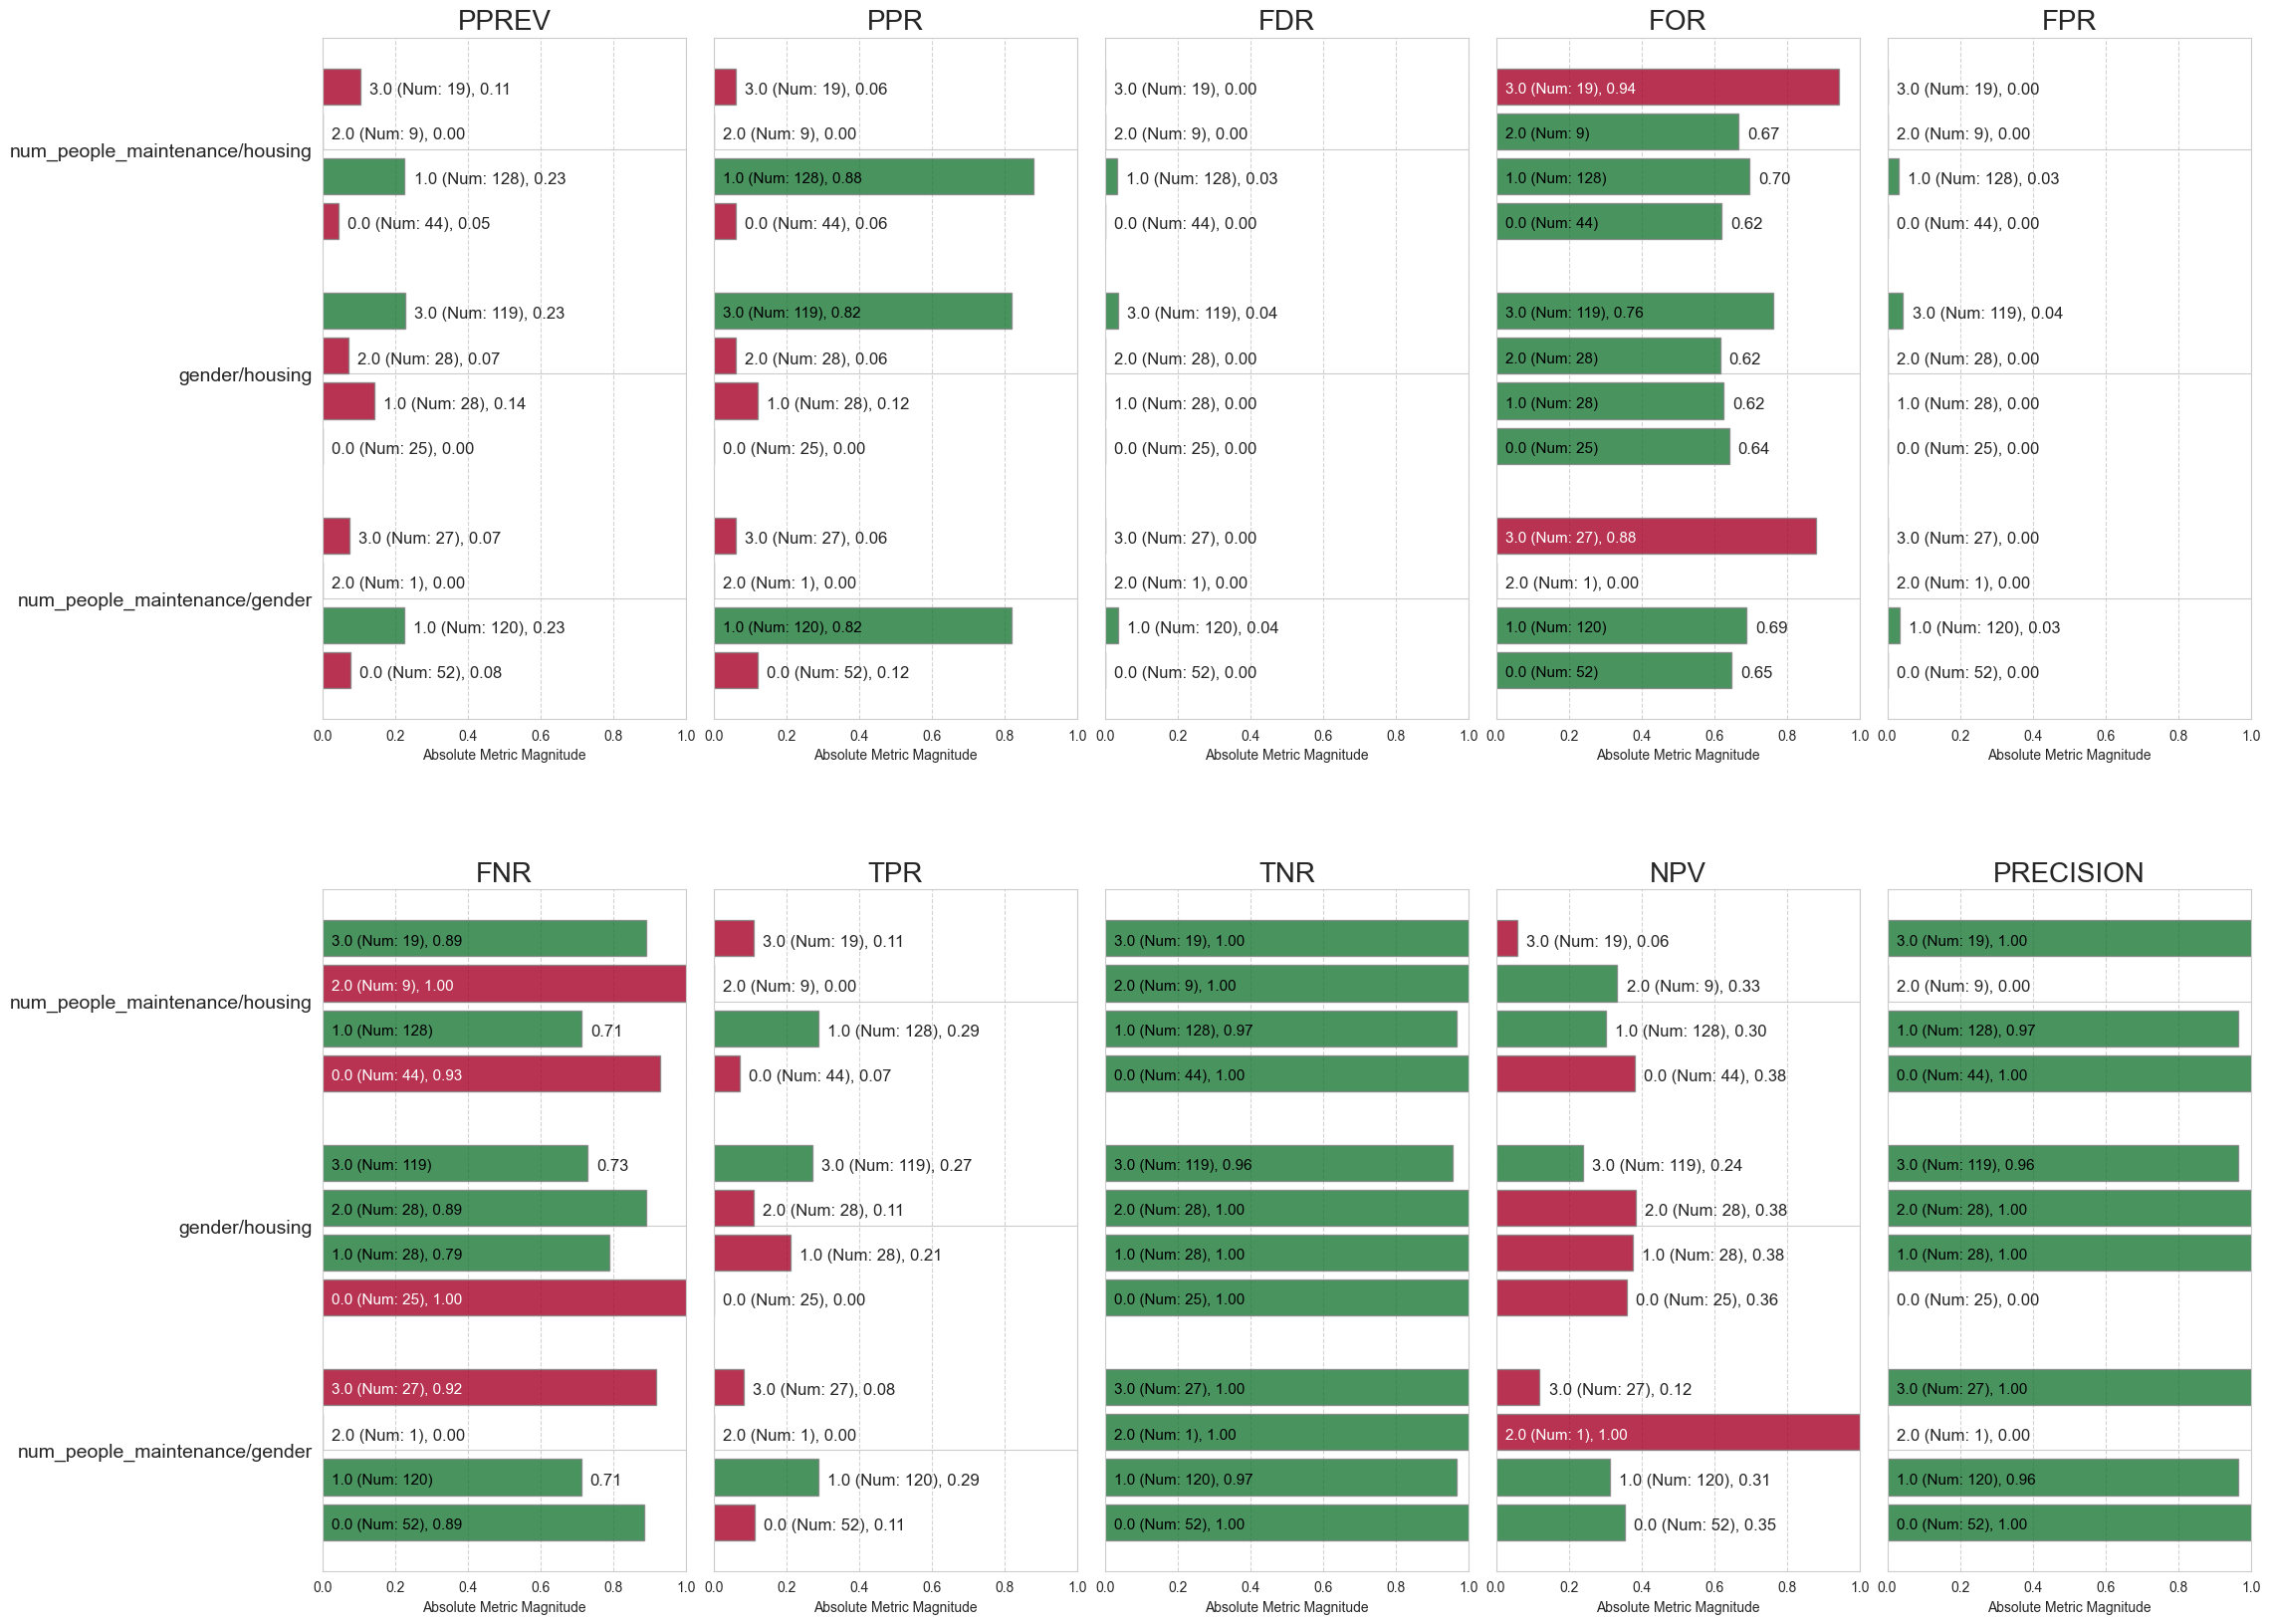

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False        True   
1               False          False       False       False       False   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False        True       False              True   
1       False       False        True       False              True   
2       False       False        True       False              True   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [117]:
"""Gerry fair"""""

maj_1 = get_majority_classes(df_num_int[protected_attributes_int[0]])[0]
maj_2 = get_majority_classes(df_num_int[protected_attributes_int[1]])[0]
maj_3 = get_majority_classes(df_num_int[protected_attributes_int[2]])[0]
maj_classes = [[maj_1],[maj_2],[maj_3]]

x_test_gf,y_test_gf,y_test_pred_gf = in_process_gerryfair(df_num_int,target, protected_attributes_int, maj_classes, len(df_num_int)-len(x_test_int))
df_test_transformed_gf =calc_fairness_report(x_test_gf, y_test_gf, y_test_pred_gf,target,protected_attributes_int,list_of_disparities,priv, display_disp=True)

[INFO] 2024-11-22 18:43:54 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


[INFO] 2024-11-22 18:43:54 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


[INFO] 2024-11-22 18:43:54 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.linear_model.LogisticRegression
Accuracy score training:
0.5988
Accuracy score test:
0.5800
Classification report for model: sklearn.linear_model.LogisticRegression : 
               precision    recall  f1-score   support

           0       0.36      0.69      0.47        54
           1       0.82      0.54      0.65       146

    accuracy                           0.58       200
   macro avg       0.59      0.61      0.56       200
weighted avg       0.70      0.58      0.60       200



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.49  0.32  0.88   
1    num_people_maintenance/gender               1      0.60  0.60  0.60   
2    num_people_maintenance/gender               2      0.33  0.50  0.00   
3    num_people_maintenance/gender               3      0.71  0.72  0.67   
4                   gender/housing               0      0.40  0.09  0.78   
5                   gender/housing               1      0.52  0.42  0.89   
6                   gender/housing               2      0.58  0.47  0.71   
7                   gender/housing               3      0.64  0.66  0.55   
8   num_people_maintenance/housing               0      0.49  0.30  0.75   
9   num_people_maintenance/housing               1      0.60  0.58  0.67   
10  num_people_maintenance/housing               2      0.67  0.67  0.67   
11  num_people_maintenance/housing               3      0.67  0.71  0.50   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.64  0.13  0.12  0.68  0.36       0.87  0.16   0.26  0.70  
1   0.65  0.19  0.40  0.40  0.35       0.81  0.67   0.55  0.74  
2   1.00  0.50  1.00  0.50  0.00       0.50  0.02   0.67  0.67  
3   0.56  0.13  0.33  0.28  0.44       0.87  0.16   0.62  0.75  
4   0.59  0.67  0.22  0.91  0.41       0.33  0.03   0.15  0.55  
5   0.69  0.07  0.11  0.58  0.31       0.93  0.15   0.35  0.78  
6   0.50  0.31  0.29  0.53  0.50       0.69  0.14   0.39  0.58  
7   0.71  0.15  0.45  0.34  0.29       0.85  0.69   0.62  0.79  
8   0.56  0.38  0.25  0.70  0.44       0.62  0.14   0.28  0.57  
9   0.70  0.14  0.33  0.42  0.30       0.86  0.69   0.52  0.79  
10  0.33  0.33  0.33  0.33  0.67       0.67  0.03   0.50  0.50  
11  0.71  0.14  0.50  0.29  0.29       0.86  0.15   0.67  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.71   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           2.67   
3    num_people_maintenance/gender               3           0.71   
4                   gender/housing               0           4.40   
5                   gender/housing               1           0.47   
6                   gender/housing               2           2.03   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           2.82   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.44   
11  num_people_maintenance/housing               3           1.05   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.71           0.98           0.29           1.03           0.23   
1            1.00           1.00           1.00           1.00           1.00   
2            1.26           1.53           2.50           0.00           0.03   
3            0.70           0.85           0.83           1.28           0.23   
4            2.66           0.83           0.49           1.41           0.05   
5            1.70           0.98           0.24           1.05           0.21   
6            1.54           0.71           0.63           1.71           0.20   
7            1.00           1.00           1.00           1.00           1.00   
8            1.66           0.80           0.75           1.47           0.20   
9            1.00           1.00           1.00           1.00           1.00   
10           0.79           0.48           1.00           2.22           0.05   
11           0.69           1.02           1.50           0.95           0.21   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.48                 1.07           1.47           0.54  
1              1.00                 1.00           1.00           1.00  
2              1.21                 0.62           0.00           0.83  
3              1.13                 1.07           1.11           1.19  
4              0.24                 0.39           1.43           0.14  
5              0.57                 1.09           1.63           0.64  
6              0.64                 0.82           1.31           0.72  
7              1.00                 1.00           1.00           1.00  
8              0.53                 0.71           1.12           0.51  
9              1.00                 1.00           1.00           1.00  
10             0.95                 0.77           1.00           1.16  
11             1.27                 0.99           0.75           1.23

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        1.223333       1.120000       1.206667
gender/housing                       1.966667       0.840000       0.453333
num_people_maintenance/housing       1.046667       0.766667       1.083333
Overall average for fnr_disparity:  1.412
Overall average for for_disparity:  0.909
Overall average for fpr_disparity:  0.914


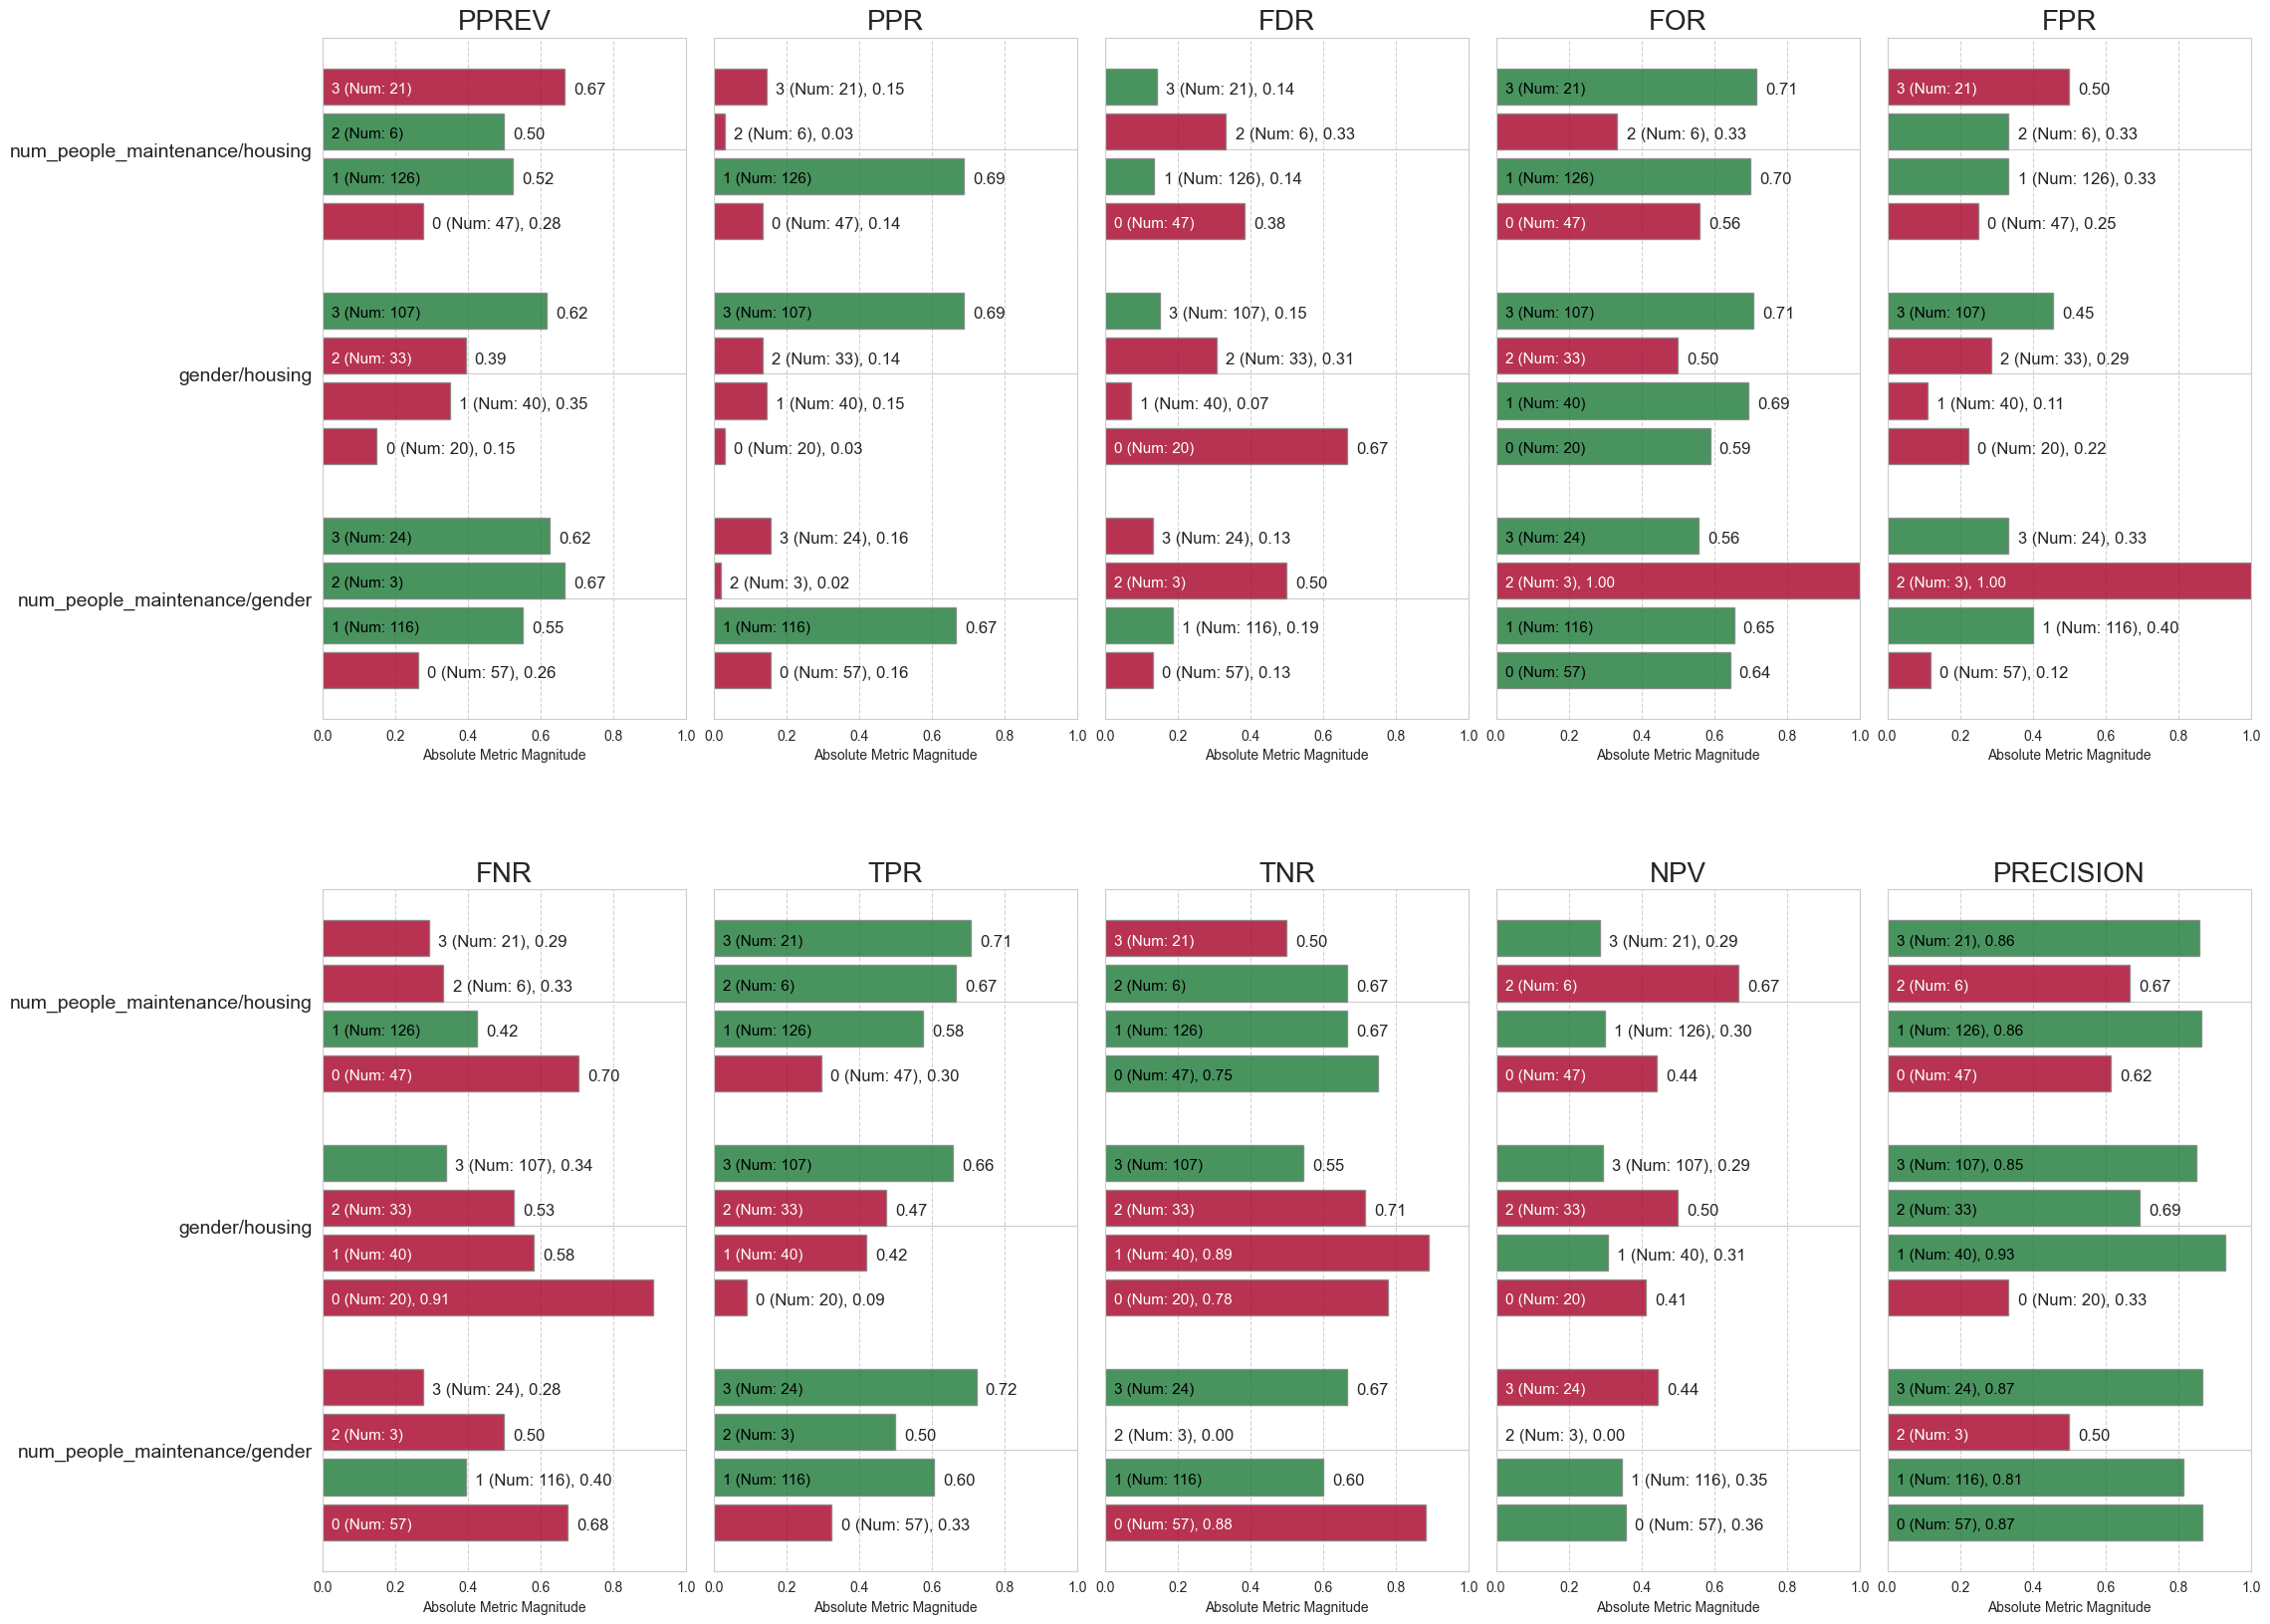

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False          False       False       False       False   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False       False       False             False   
1       False       False       False       False             False   
2       False       False       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

[INFO] 2024-11-22 18:43:57 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


[INFO] 2024-11-22 18:43:57 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


[INFO] 2024-11-22 18:43:57 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.linear_model.LogisticRegression
Accuracy score training:
0.7137
Accuracy score test:
0.6800
Classification report for model: sklearn.linear_model.LogisticRegression : 
               precision    recall  f1-score   support

           0       0.39      0.33      0.36        54
           1       0.77      0.81      0.79       146

    accuracy                           0.68       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.67      0.68      0.67       200



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.68  0.75  0.53   
1    num_people_maintenance/gender               1      0.67  0.81  0.27   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.71  0.89  0.17   
4                   gender/housing               0      0.75  0.91  0.56   
5                   gender/housing               1      0.65  0.71  0.44   
6                   gender/housing               2      0.61  0.89  0.21   
7                   gender/housing               3      0.70  0.81  0.27   
8   num_people_maintenance/housing               0      0.68  0.89  0.40   
9   num_people_maintenance/housing               1      0.67  0.77  0.33   
10  num_people_maintenance/housing               2      0.50  1.00  0.00   
11  num_people_maintenance/housing               3      0.76  0.88  0.25   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.53  0.21  0.47  0.25  0.47       0.79  0.25   0.67  0.70  
1   0.67  0.24  0.73  0.19  0.33       0.76  0.60   0.79  0.74  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3   0.67  0.24  0.83  0.11  0.33       0.76  0.14   0.88  0.75  
4   0.17  0.29  0.44  0.09  0.83       0.71  0.09   0.70  0.55  
5   0.69  0.19  0.56  0.29  0.31       0.81  0.18   0.68  0.78  
6   0.40  0.39  0.79  0.11  0.60       0.61  0.18   0.85  0.58  
7   0.73  0.19  0.73  0.19  0.27       0.81  0.55   0.79  0.79  
8   0.27  0.33  0.60  0.11  0.73       0.67  0.23   0.77  0.57  
9   0.72  0.19  0.67  0.23  0.28       0.81  0.61   0.75  0.79  
10   NaN  0.50  1.00  0.00   NaN       0.50  0.04   1.00  0.50  
11  0.67  0.17  0.75  0.12  0.33       0.83  0.12   0.86  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.88   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.39   
3    num_people_maintenance/gender               3           1.00   
4                   gender/housing               0           1.52   
5                   gender/housing               1           0.98   
6                   gender/housing               2           2.09   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.74   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.61   
11  num_people_maintenance/housing               3           0.87   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.34           0.79           0.64           1.42           0.41   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.36            NaN           0.03   
3            0.60           1.00           1.14           1.00           0.23   
4            0.48           0.23           0.61           3.06           0.16   
5            1.54           0.95           0.76           1.13           0.32   
6            0.56           0.55           1.08           2.20           0.33   
7            1.00           1.00           1.00           1.00           1.00   
8            0.48           0.38           0.90           2.59           0.38   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00            NaN           1.50            NaN           0.06   
11           0.51           0.93           1.12           1.19           0.19   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.84                 1.04           1.99           0.92  
1              1.00                 1.00           1.00           1.00  
2              1.26                 0.88           0.00           1.23  
3              1.10                 1.00           0.62           1.09  
4              0.88                 0.88           2.04           1.12  
5              0.85                 1.00           1.63           0.87  
6              1.07                 0.75           0.79           1.10  
7              1.00                 1.00           1.00           1.00  
8              1.03                 0.82           1.20           1.16  
9              1.00                 1.00           1.00           1.00  
10             1.34                 0.62           0.00           1.30  
11             1.15                 1.03           0.75           1.15

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        0.646667       0.895000       1.046667
gender/housing                       0.860000       0.576667       0.816667
num_people_maintenance/housing       0.330000       0.655000       1.173333
Overall average for fnr_disparity:  0.612
Overall average for for_disparity:  0.709
Overall average for fpr_disparity:  1.012


<Figure size 640x480 with 0 Axes>

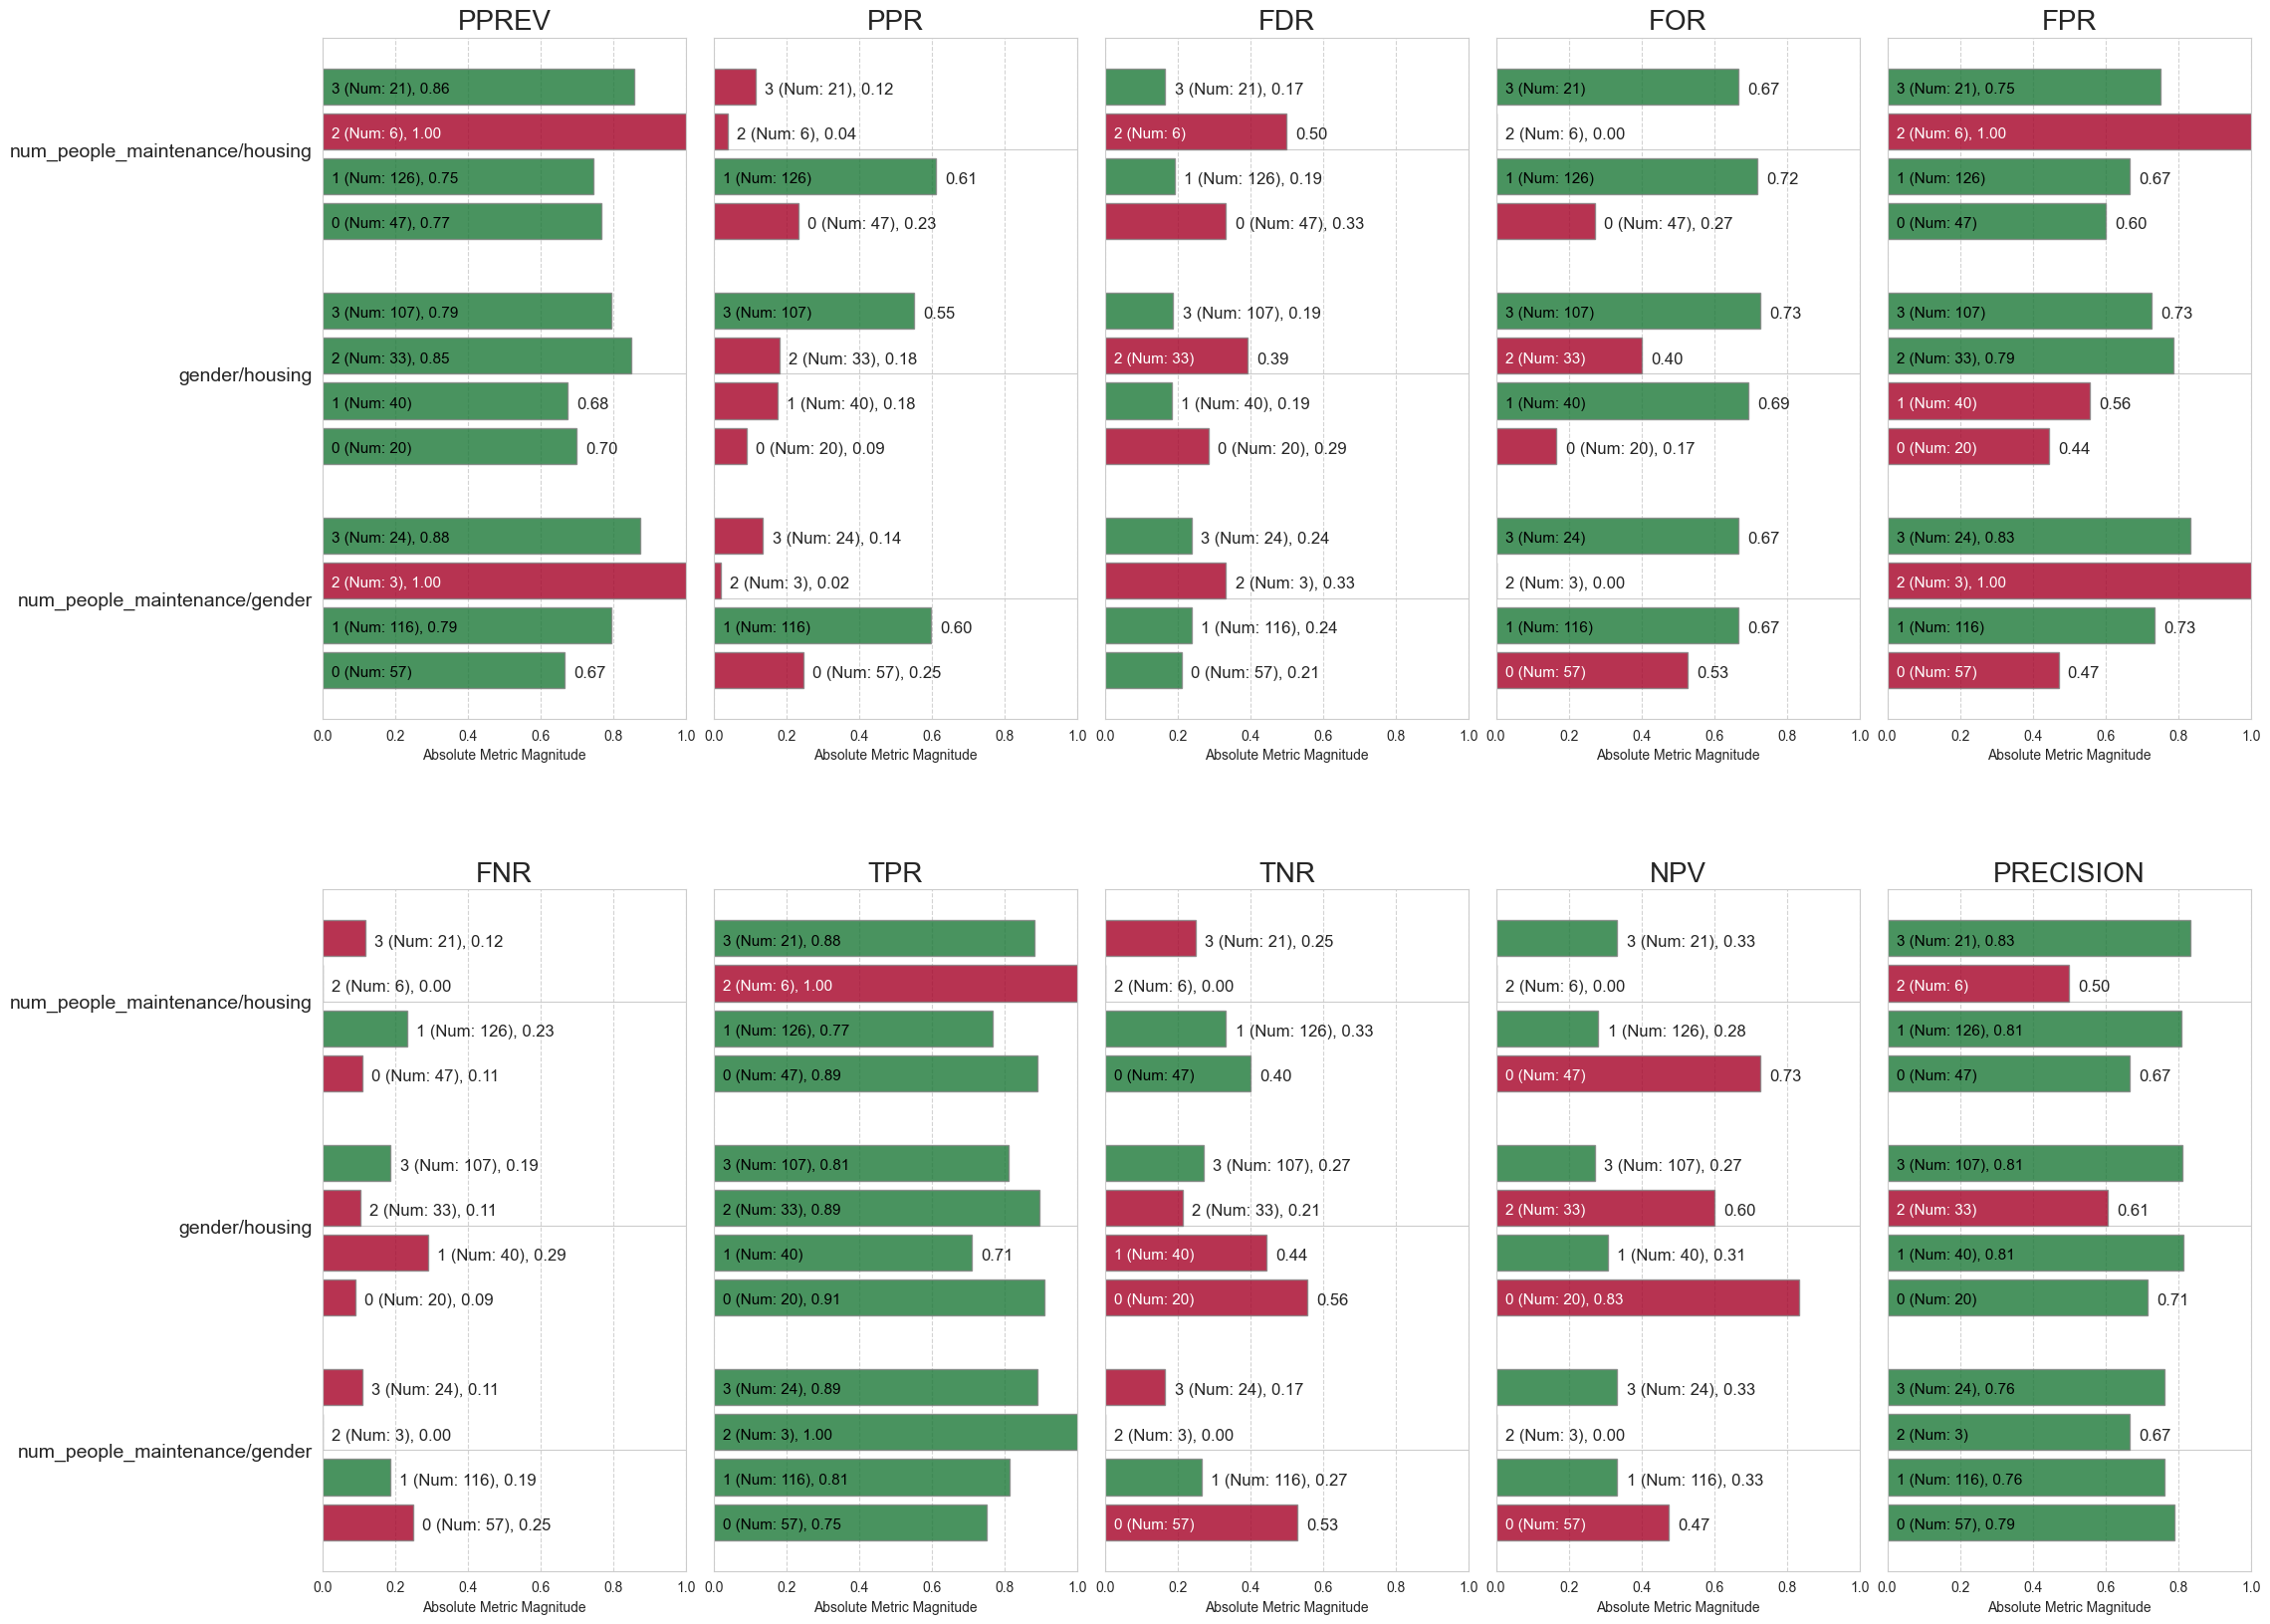

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False          False       False       False       False   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False        True       False       False              True   
2       False       False       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

[INFO] 2024-11-22 18:44:01 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


[INFO] 2024-11-22 18:44:01 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


[INFO] 2024-11-22 18:44:01 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.linear_model.LogisticRegression
Accuracy score training:
0.6650
Accuracy score test:
0.6300
Classification report for model: sklearn.linear_model.LogisticRegression : 
               precision    recall  f1-score   support

           0       0.38      0.56      0.45        54
           1       0.80      0.66      0.72       146

    accuracy                           0.63       200
   macro avg       0.59      0.61      0.58       200
weighted avg       0.69      0.63      0.65       200



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.68  0.68  0.71   
1    num_people_maintenance/gender               1      0.58  0.62  0.47   
2    num_people_maintenance/gender               2      0.33  0.50  0.00   
3    num_people_maintenance/gender               3      0.79  0.83  0.67   
4                   gender/housing               0      0.75  0.82  0.67   
5                   gender/housing               1      0.62  0.61  0.67   
6                   gender/housing               2      0.55  0.63  0.43   
7                   gender/housing               3      0.64  0.66  0.55   
8   num_people_maintenance/housing               0      0.64  0.70  0.55   
9   num_people_maintenance/housing               1      0.60  0.62  0.56   
10  num_people_maintenance/housing               2      0.50  0.67  0.33   
11  num_people_maintenance/housing               3      0.81  0.82  0.75   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.52  0.16  0.29  0.32  0.48       0.84  0.27   0.56  0.70  
1   0.70  0.23  0.53  0.38  0.30       0.77  0.57   0.59  0.74  
2   1.00  0.50  1.00  0.50  0.00       0.50  0.02   0.67  0.67  
3   0.43  0.12  0.33  0.17  0.57       0.88  0.14   0.71  0.75  
4   0.25  0.25  0.33  0.18  0.75       0.75  0.10   0.60  0.55  
5   0.67  0.14  0.33  0.39  0.33       0.86  0.18   0.55  0.78  
6   0.54  0.40  0.57  0.37  0.46       0.60  0.17   0.61  0.58  
7   0.71  0.15  0.45  0.34  0.29       0.85  0.55   0.62  0.79  
8   0.42  0.32  0.45  0.30  0.58       0.68  0.23   0.60  0.57  
9   0.72  0.16  0.44  0.38  0.28       0.84  0.61   0.58  0.79  
10  0.50  0.50  0.67  0.33  0.50       0.50  0.03   0.67  0.50  
11  0.50  0.07  0.25  0.18  0.50       0.93  0.12   0.71  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.67   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           2.16   
3    num_people_maintenance/gender               3           0.51   
4                   gender/housing               0           1.65   
5                   gender/housing               1           0.90   
6                   gender/housing               2           2.64   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.96   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           3.04   
11  num_people_maintenance/housing               3           0.41   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.85           0.74           0.55           1.61           0.46   
1            1.00           1.00           1.00           1.00           1.00   
2            1.30           1.42           1.88           0.00           0.03   
3            0.43           0.61           0.62           1.92           0.25   
4            0.53           0.35           0.73           2.56           0.18   
5            1.13           0.94           0.73           1.14           0.33   
6            1.08           0.76           1.26           1.58           0.30   
7            1.00           1.00           1.00           1.00           1.00   
8            0.77           0.59           1.01           2.05           0.38   
9            1.00           1.00           1.00           1.00           1.00   
10           0.87           0.70           1.50           1.77           0.05   
11           0.46           0.70           0.56           1.77           0.21   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.94                 1.10           1.51           1.10  
1              1.00                 1.00           1.00           1.00  
2              1.12                 0.65           0.00           0.81  
3              1.19                 1.15           1.43           1.35  
4              0.97                 0.88           1.22           1.24  
5              0.89                 1.02           1.22           0.93  
6              0.98                 0.71           0.79           0.96  
7              1.00                 1.00           1.00           1.00  
8              1.03                 0.81           0.99           1.14  
9              1.00                 1.00           1.00           1.00  
10             1.15                 0.60           0.60           1.08  
11             1.23                 1.12           1.35           1.34

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        0.860000       0.923333       1.016667
gender/housing                       0.913333       0.683333       0.906667
num_people_maintenance/housing       0.700000       0.663333       1.023333
Overall average for fnr_disparity:  0.824
Overall average for for_disparity:  0.757
Overall average for fpr_disparity:  0.982


<Figure size 640x480 with 0 Axes>

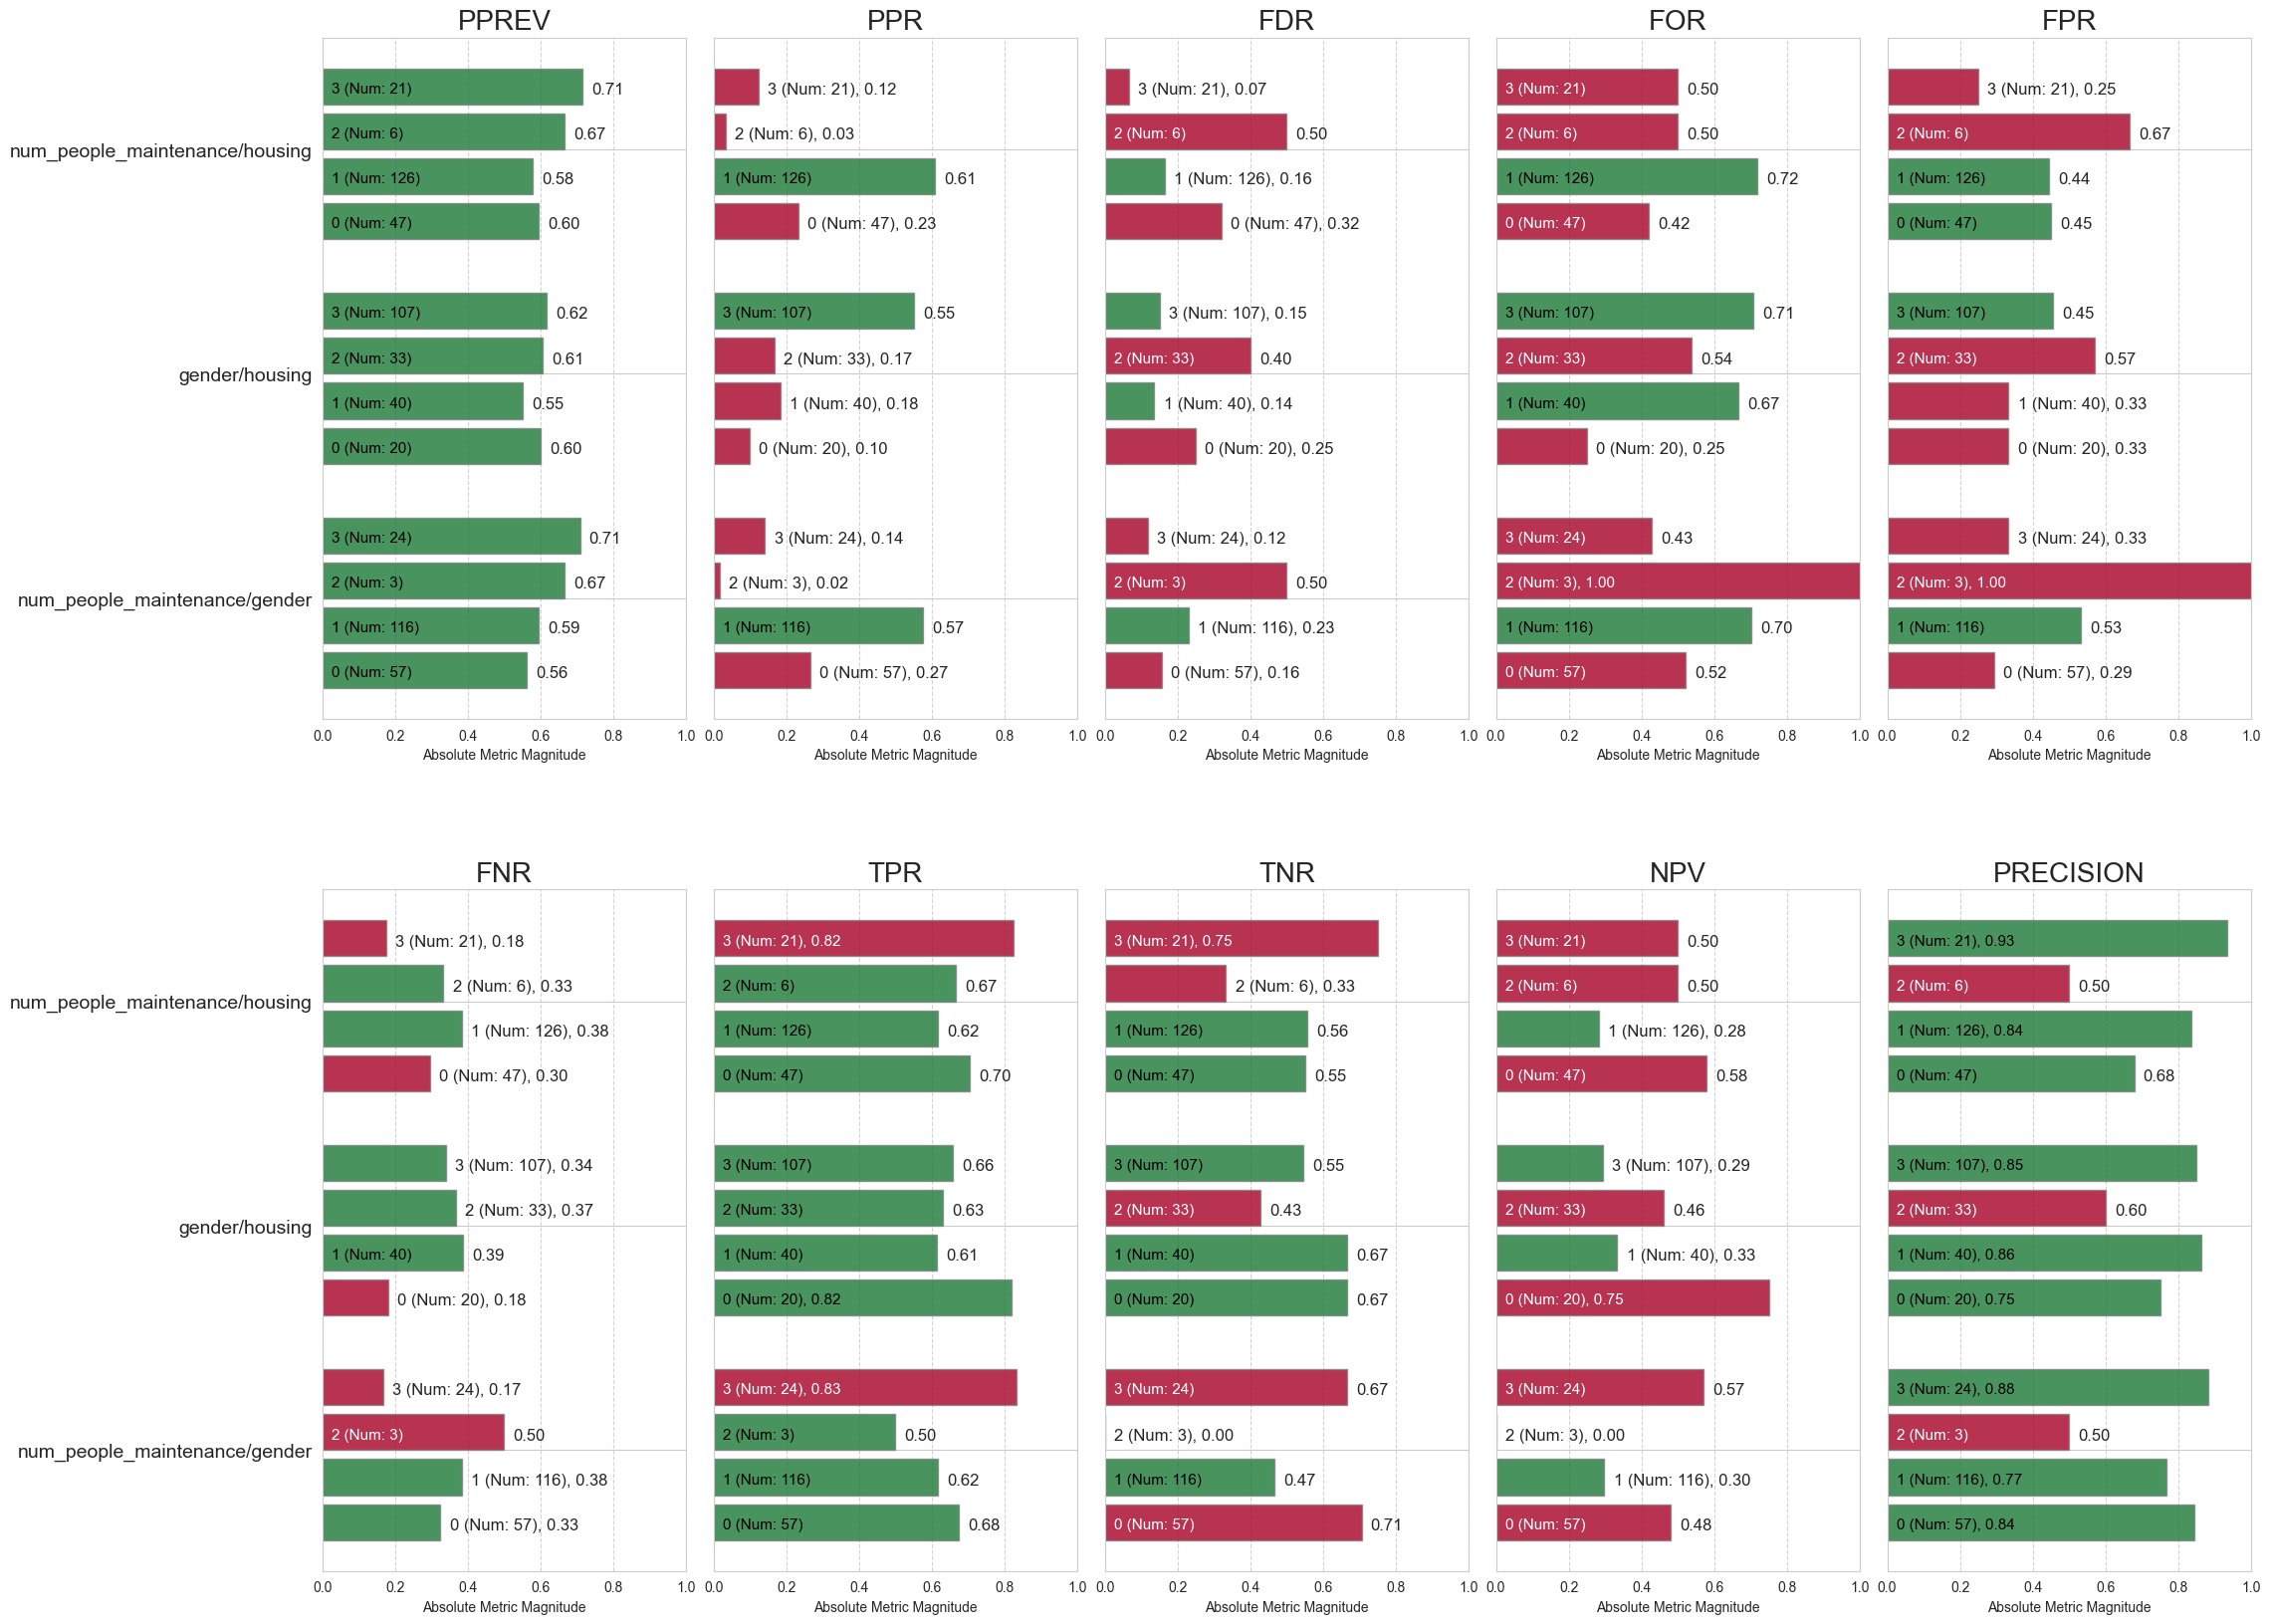

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False       False       False       False             False   
2       False       False       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [120]:
from aequitas.flow.methods.inprocessing import FairlearnClassifier
'''
In-processing: Fair learn classifier 
'''
data_to_transform = df_num_int.copy()
models = ["sklearn.linear_model.LogisticRegression"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, protected_attributes_int[0], models[0], metrics_dict,target)
df_test_transformed_fl1 =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int,list_of_disparities,priv, display_disp=True)

data_to_transform = df_num_int.copy()
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, protected_attributes_int[1], models[0], metrics_dict,target)
df_test_transformed_fl2 =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int, list_of_disparities,priv, display_disp=True)

data_to_transform = df_num_int.copy()

x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, protected_attributes_int[2], models[0], metrics_dict,target)
df_test_transformed_fl3 =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int,list_of_disparities,priv, display_disp=True)


{'num_people_maintenance/gender': [1], 'gender/housing': [3], 'num_people_maintenance/housing': [1]}
---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.51, random_state=42, solver='liblinear')
[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:09 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.4900


attribute_name attribute_value  accuracy   tpr   tnr   for  \
0  num_people_maintenance/gender               0      0.68  0.70  0.65  0.52   
1  num_people_maintenance/gender               1      0.56  0.51  0.70  0.67   
2  num_people_maintenance/gender               2      0.33  0.00  1.00  0.67   
3  num_people_maintenance/gender               3      0.88  0.94  0.67  0.20   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.18  0.35  0.30  0.48       0.82  0.32   0.60  0.70  
1  0.17  0.30  0.49  0.33       0.83  0.50   0.46  0.74  
2   NaN  0.00  1.00  0.33        NaN  0.00   0.00  0.67  
3  0.11  0.33  0.06  0.80       0.89  0.18   0.79  0.75

Majority class for:  num_people_maintenance/gender  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0  num_people_maintenance/gender               0           1.04   
1  num_people_maintenance/gender               1           1.00   
2  num_people_maintenance/gender               2            NaN   
3  num_people_maintenance/gender               3           0.62   

   fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.61           0.78           1.18           1.43           0.64   
1           1.00           1.00           1.00           1.00           1.00   
2           2.05           1.00           0.00           1.00           0.00   
3           0.11           0.30           1.11           2.40           0.36   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             1.31                 0.99           0.92           1.37  
1             1.00                 1.00           1.00           1.00  
2             0.00                  NaN           1.43           0.00  
3             1.73                 1.08           0.95           1.85

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        0.923333       0.693333       0.763333
gender/housing                            NaN            NaN            NaN
num_people_maintenance/housing            NaN            NaN            NaN
Overall average for fnr_disparity:  0.923
Overall average for for_disparity:  0.693
Overall average for fpr_disparity:  0.763


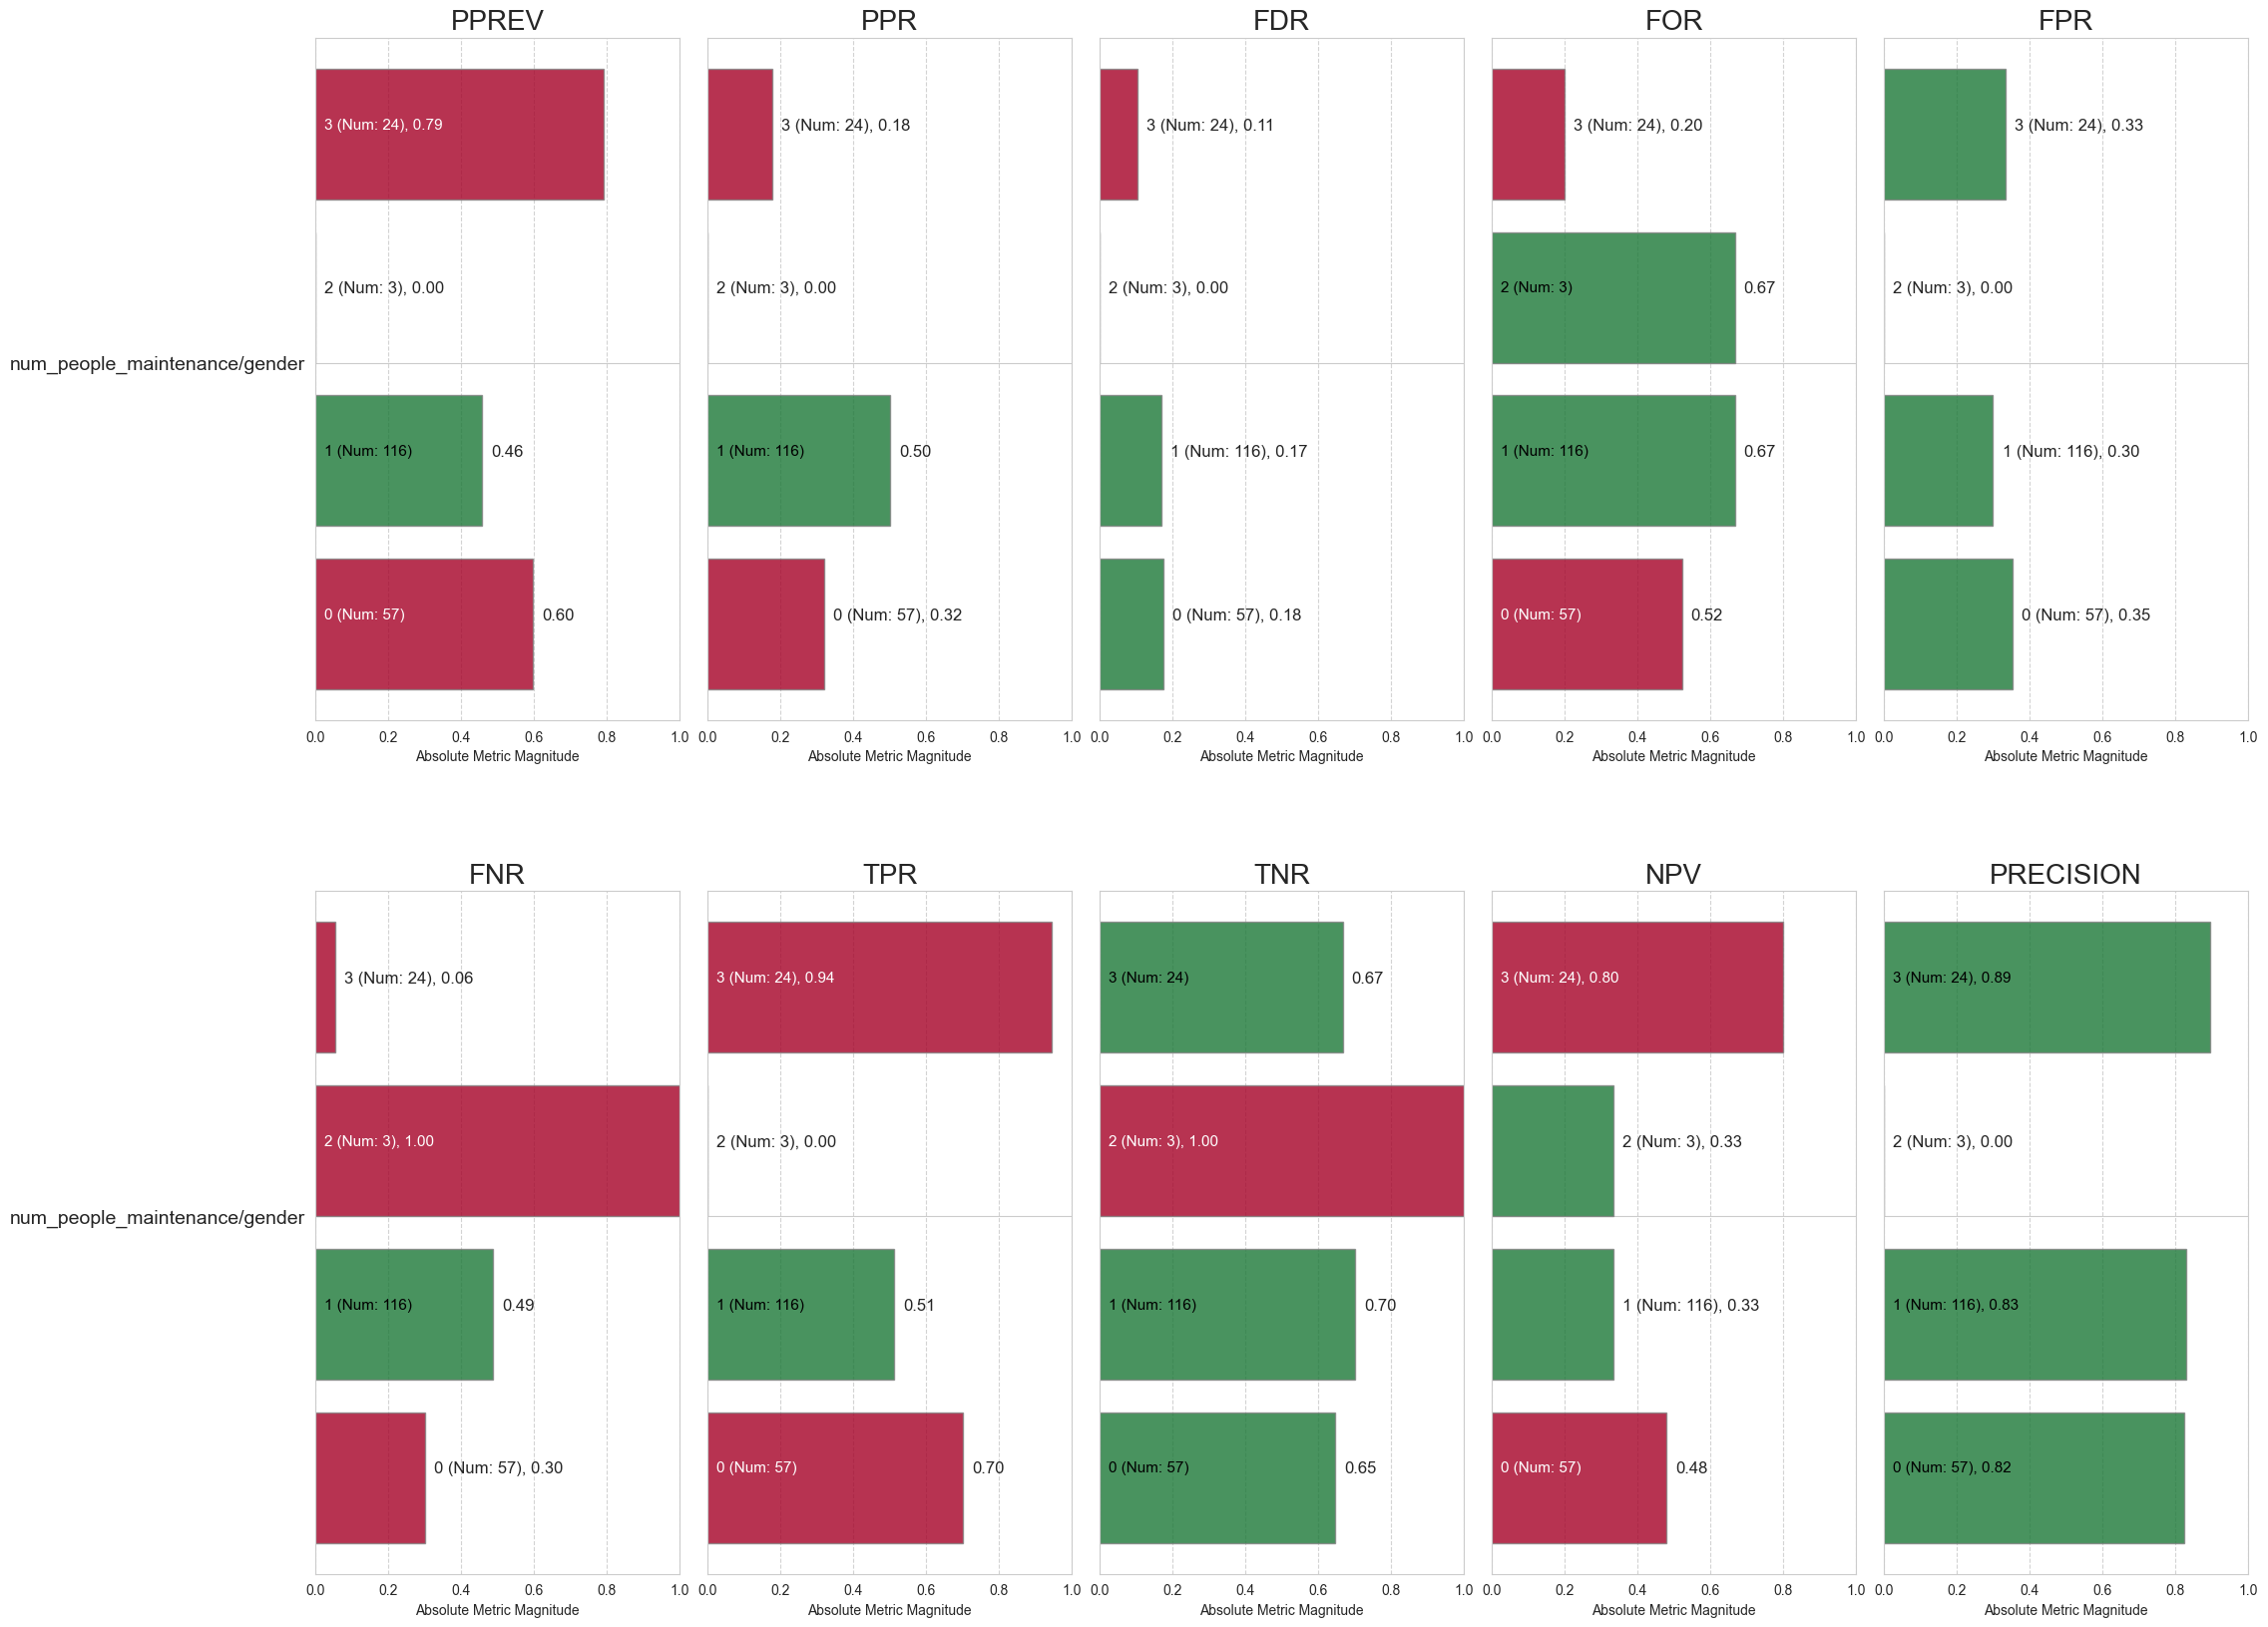

model_id score_threshold                 attribute_name  \
0         0      binary 0/1  num_people_maintenance/gender   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False       False       False              True   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   

   Supervised Fairness  
0                False

{'num_people_maintenance/gender': [1], 'gender/housing': [3], 'num_people_maintenance/housing': [1]}
---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.51, random_state=42, solver='liblinear')
[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:10 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.5600


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0  gender/housing               0      0.70  0.82  0.56  0.29  0.31  0.44   
1  gender/housing               1      0.55  0.55  0.56  0.74  0.19  0.44   
2  gender/housing               2      0.61  0.58  0.64  0.47  0.31  0.36   
3  gender/housing               3      0.62  0.60  0.68  0.69  0.12  0.32   

    fnr   npv  precision   ppr  pprev  prev  
0  0.18  0.71       0.69  0.12   0.65  0.55  
1  0.45  0.26       0.81  0.19   0.52  0.78  
2  0.42  0.53       0.69  0.15   0.48  0.58  
3  0.40  0.31       0.88  0.54   0.54  0.79

Majority class for:  gender/housing  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0  gender/housing               0           2.55           0.45   
1  gender/housing               1           1.58           1.13   
2  gender/housing               2           2.59           1.05   
3  gender/housing               3           1.00           1.00   

   for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.41           1.40           2.33           0.22   
1           1.06           1.40           0.86           0.36   
2           0.68           1.12           1.73           0.28   
3           1.00           1.00           1.00           1.00   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             1.20                 0.79           0.81           1.36  
1             0.97                 0.92           0.81           0.91  
2             0.89                 0.78           0.94           0.96  
3             1.00                 1.00           1.00           1.00

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender             NaN            NaN            NaN
gender/housing                       0.876667       0.716667       1.306667
num_people_maintenance/housing            NaN            NaN            NaN
Overall average for fnr_disparity:  0.877
Overall average for for_disparity:  0.717
Overall average for fpr_disparity:  1.307


<Figure size 640x480 with 0 Axes>

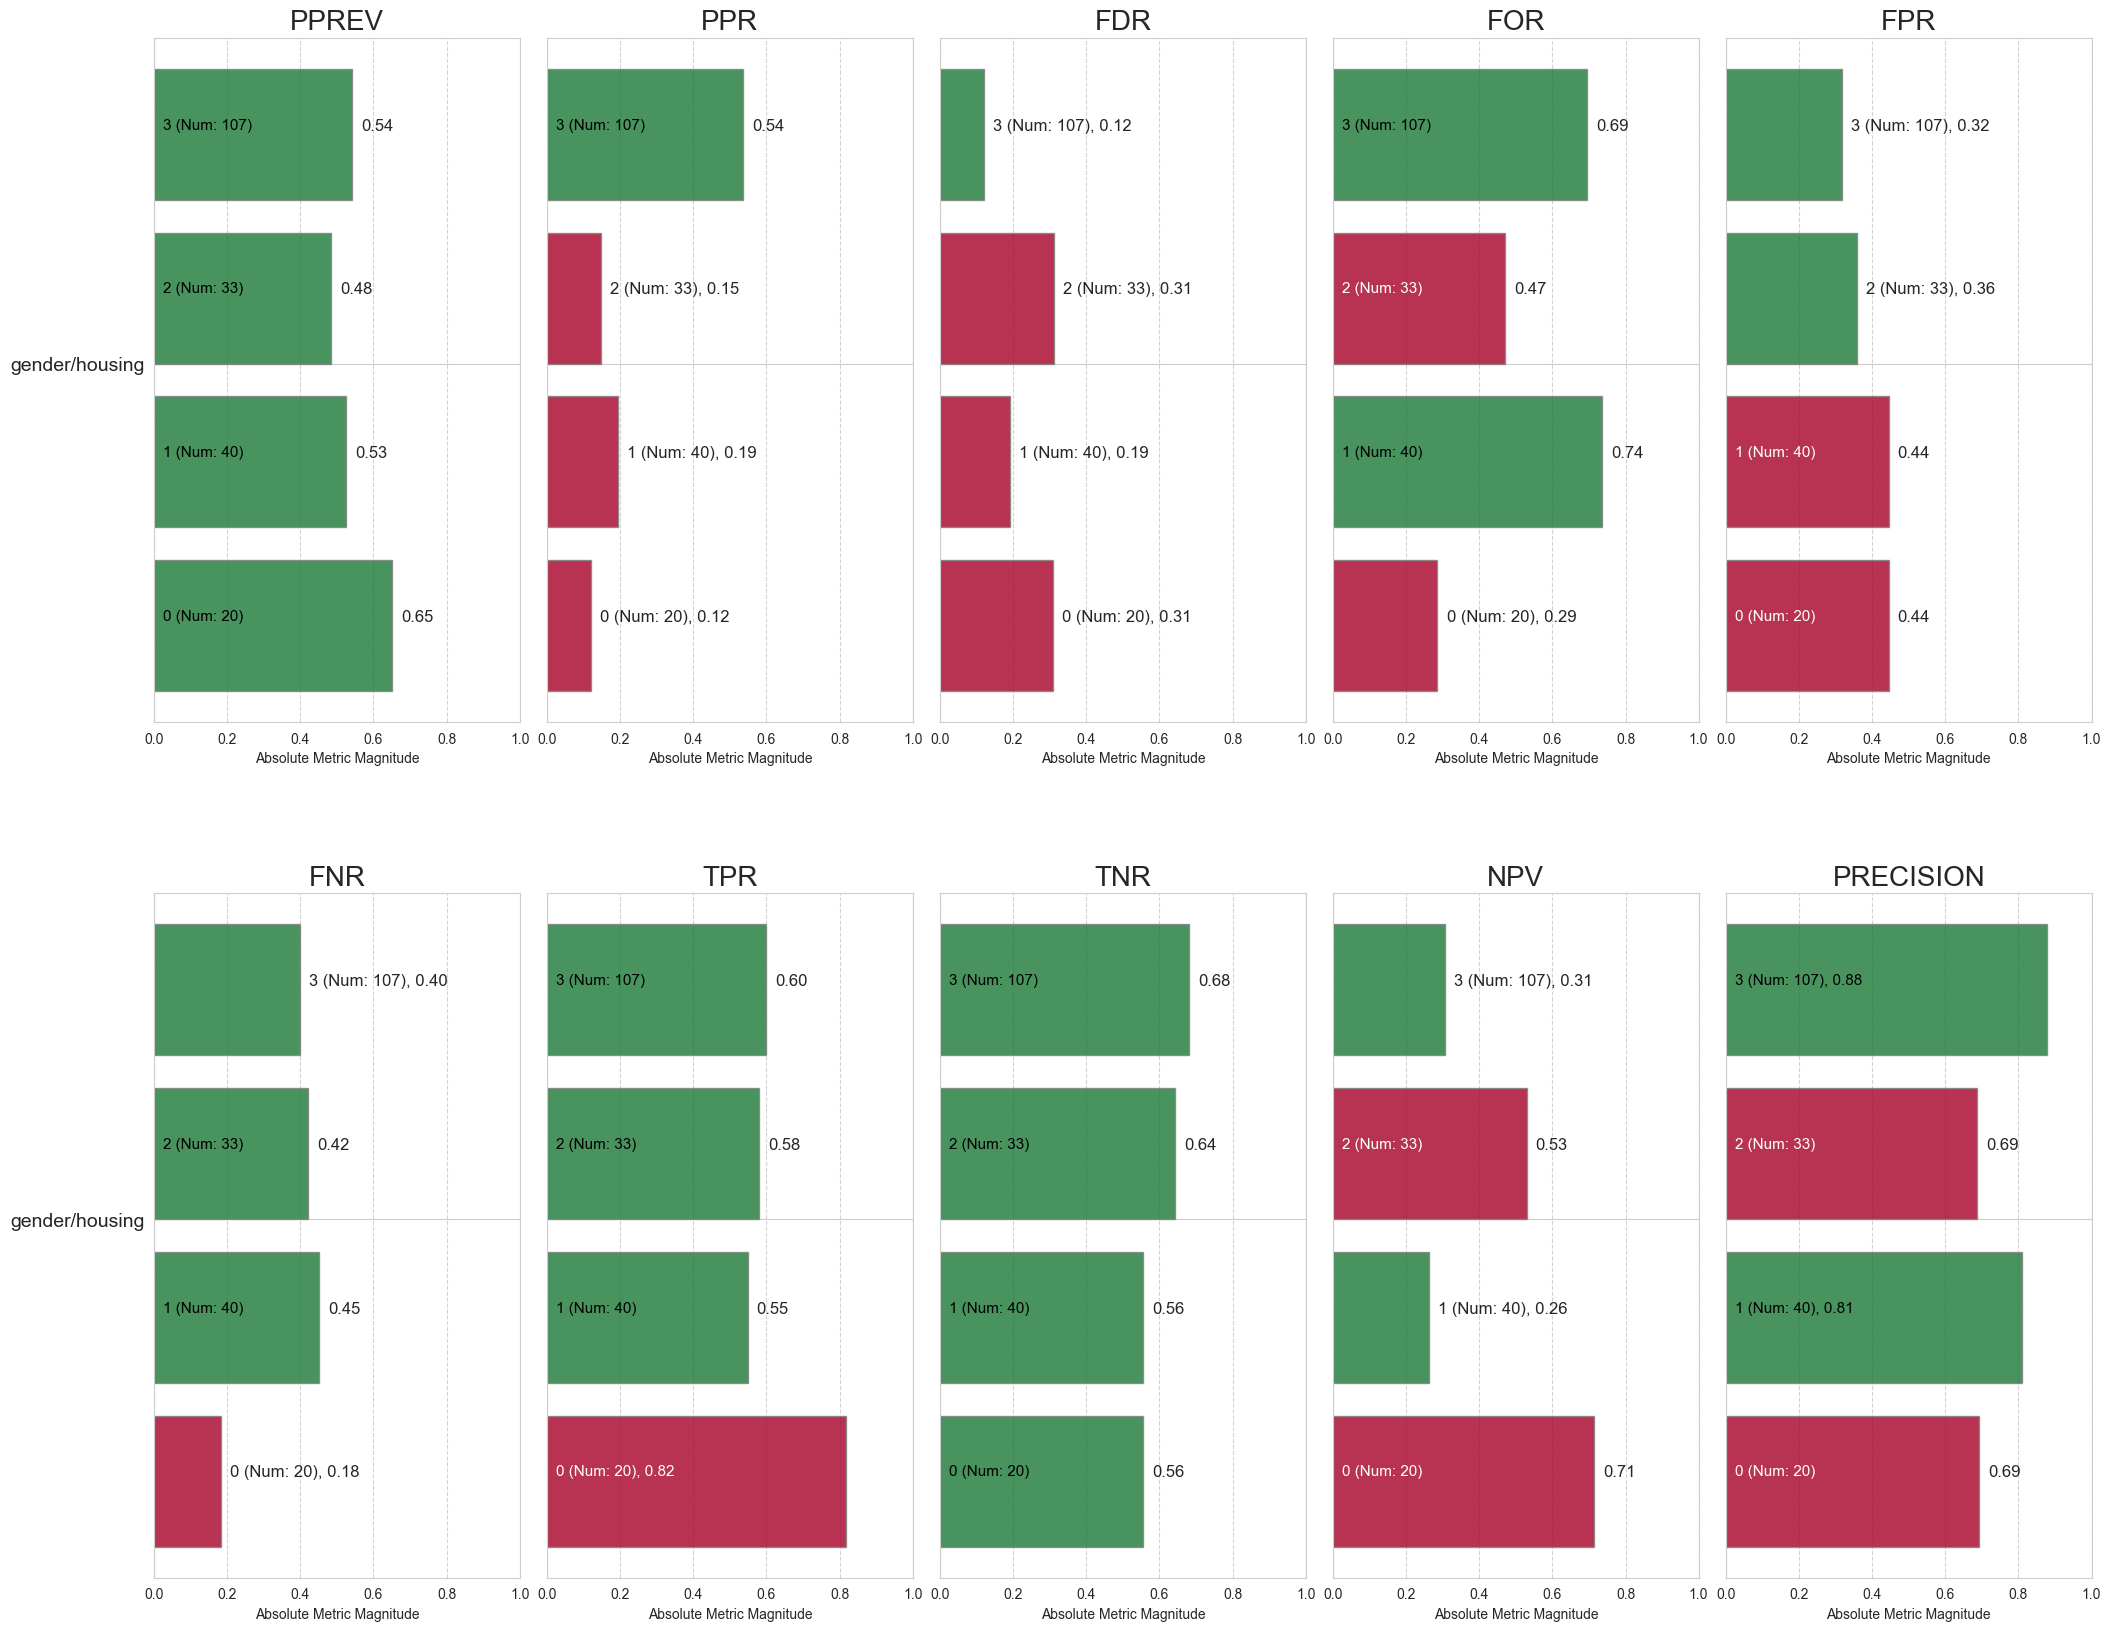

model_id score_threshold  attribute_name  Statistical Parity  \
0         0      binary 0/1  gender/housing               False   

   Impact Parity  FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  \
0           True       False       False       False       False       False   

   TNR Parity  NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  \
0        True       False             False         False          False   

   Equalized Odds  Unsupervised Fairness  Supervised Fairness  
0           False                  False                False

{'num_people_maintenance/gender': [1], 'gender/housing': [3], 'num_people_maintenance/housing': [1]}
---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.51, random_state=42, solver='liblinear')
[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-22 18:47:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.5050


attribute_name attribute_value  accuracy   tpr   tnr   for  \
0  num_people_maintenance/housing               0      0.64  0.70  0.55  0.42   
1  num_people_maintenance/housing               1      0.56  0.52  0.74  0.71   
2  num_people_maintenance/housing               2      0.67  1.00  0.33  0.00   
3  num_people_maintenance/housing               3      0.76  0.76  0.75  0.57   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.32  0.45  0.30  0.58       0.68  0.27   0.60  0.57  
1  0.12  0.26  0.48  0.29       0.88  0.55   0.46  0.79  
2  0.40  0.67  0.00  1.00       0.60  0.05   0.83  0.50  
3  0.07  0.25  0.24  0.43       0.93  0.13   0.67  0.81

Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0  num_people_maintenance/housing               0           2.66   
1  num_people_maintenance/housing               1           1.00   
2  num_people_maintenance/housing               2           3.31   
3  num_people_maintenance/housing               3           0.59   

   fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.61           0.60           1.74           1.97           0.48   
1           1.00           1.00           1.00           1.00           1.00   
2           0.00           0.00           2.57           3.40           0.09   
3           0.49           0.81           0.96           1.46           0.24   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             1.29                 0.77           0.74           1.37  
1             1.00                 1.00           1.00           1.00  
2             1.81                 0.68           0.45           1.94  
3             1.45                 1.06           1.01           1.48

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender             NaN            NaN            NaN
gender/housing                            NaN            NaN            NaN
num_people_maintenance/housing       0.366667           0.47       1.756667
Overall average for fnr_disparity:  0.367
Overall average for for_disparity:  0.470
Overall average for fpr_disparity:  1.757


<Figure size 640x480 with 0 Axes>

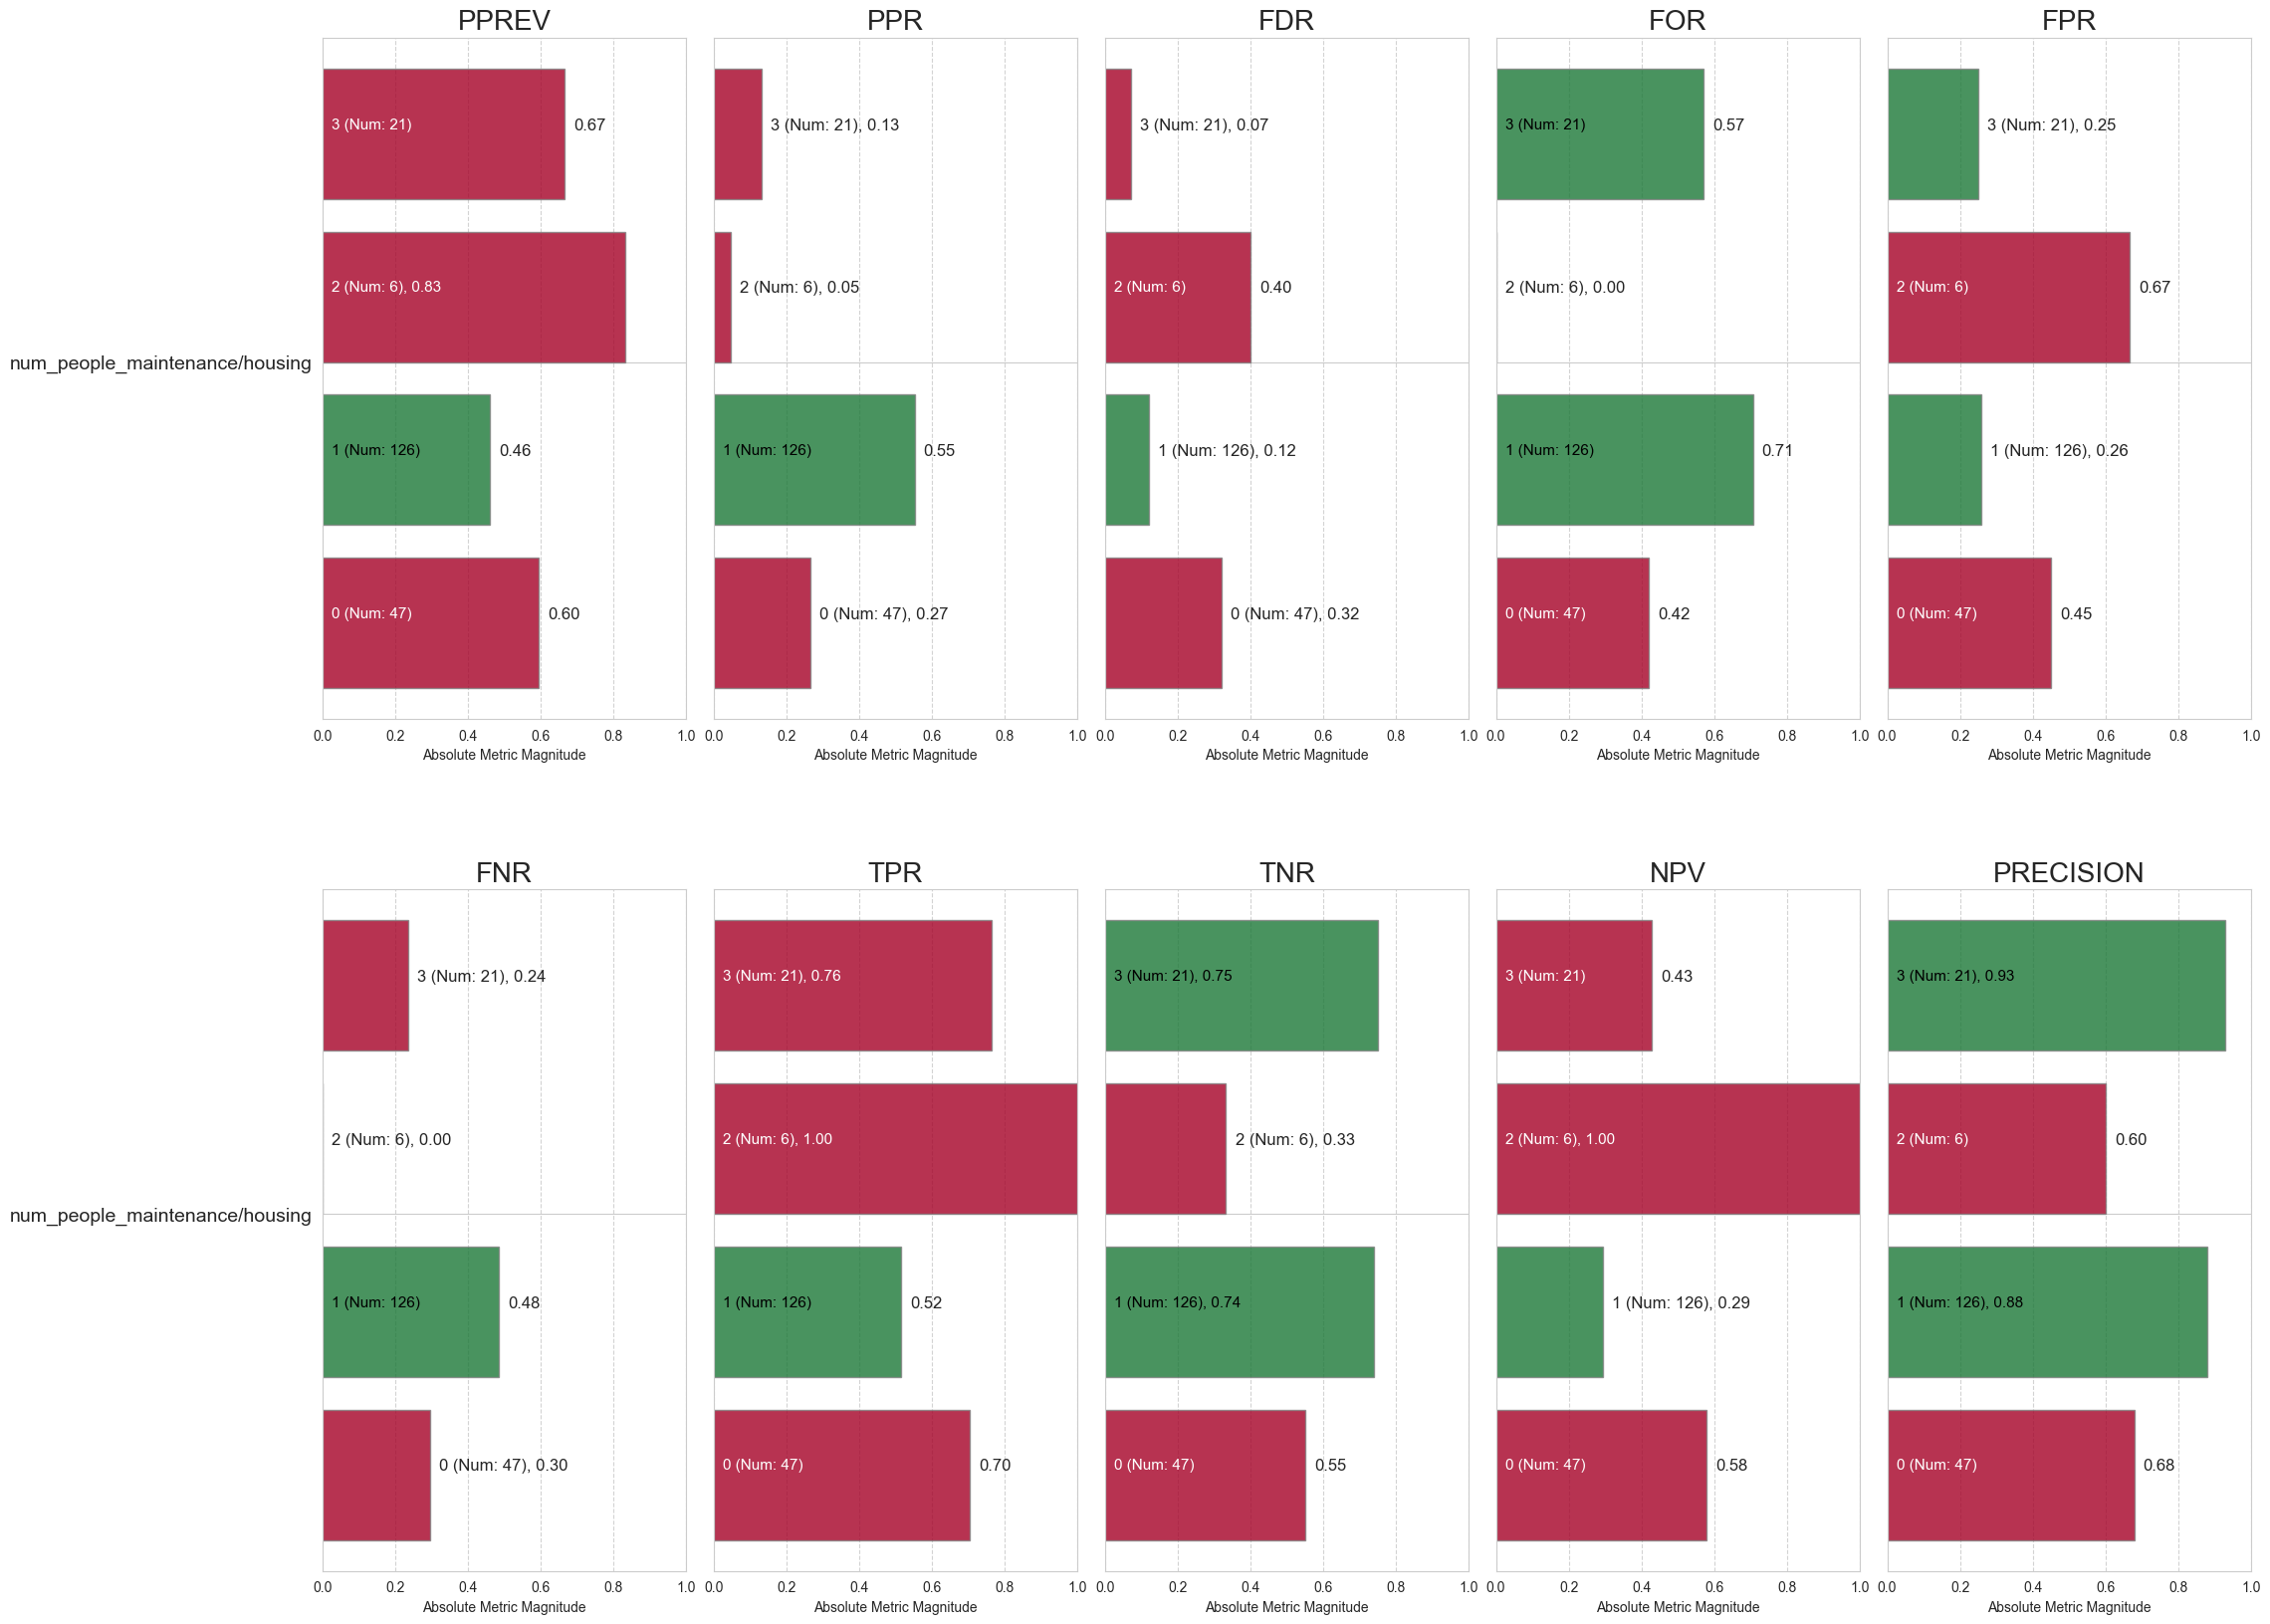

model_id score_threshold                  attribute_name  \
0         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   

   Supervised Fairness  
0                False

<Figure size 640x480 with 0 Axes>

In [121]:
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, protected_attributes_int[0], target,list_of_disparities,priv,"LogisticRegression")
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int,  protected_attributes_int[1], target,list_of_disparities,priv,"LogisticRegression")
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int,  protected_attributes_int[2], target,list_of_disparities,priv,"LogisticRegression")

---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.51, random_state=42, solver='liblinear')
Accuracy score test corrected:
0.5650


attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.49  0.45  0.59   
1    num_people_maintenance/gender               1      0.58  0.53  0.70   
2    num_people_maintenance/gender               2      0.33  0.00  1.00   
3    num_people_maintenance/gender               3      0.71  0.72  0.67   
4                   gender/housing               0      0.40  0.27  0.56   
5                   gender/housing               1      0.52  0.48  0.67   
6                   gender/housing               2      0.64  0.63  0.64   
7                   gender/housing               3      0.59  0.55  0.73   
8   num_people_maintenance/housing               0      0.51  0.44  0.60   
9   num_people_maintenance/housing               1      0.56  0.53  0.70   
10  num_people_maintenance/housing               2      0.83  1.00  0.67   
11  num_people_maintenance/housing               3      0.62  0.59  0.75   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.69  0.28  0.41  0.55  0.31       0.72  0.26   0.44  0.70  
1   0.66  0.16  0.30  0.47  0.34       0.84  0.58   0.47  0.74  
2   0.67   NaN  0.00  1.00  0.33        NaN  0.00   0.00  0.67  
3   0.56  0.13  0.33  0.28  0.44       0.87  0.16   0.62  0.75  
4   0.62  0.57  0.44  0.73  0.38       0.43  0.07   0.35  0.55  
5   0.73  0.17  0.33  0.52  0.27       0.83  0.19   0.45  0.78  
6   0.44  0.29  0.36  0.37  0.56       0.71  0.18   0.52  0.58  
7   0.70  0.11  0.27  0.45  0.30       0.89  0.56   0.50  0.79  
8   0.56  0.40  0.40  0.56  0.44       0.60  0.21   0.43  0.57  
9   0.71  0.13  0.30  0.47  0.29       0.87  0.63   0.48  0.79  
10  0.00  0.25  0.33  0.00  1.00       0.75  0.04   0.67  0.50  
11  0.70  0.09  0.25  0.41  0.30       0.91  0.12   0.52  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.71   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2            NaN   
3    num_people_maintenance/gender               3           0.81   
4                   gender/housing               0           5.05   
5                   gender/housing               1           1.47   
6                   gender/housing               2           2.60   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           3.00   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           1.88   
11  num_people_maintenance/housing               3           0.68   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.18           1.05           1.37           0.91           0.45   
1            1.00           1.00           1.00           1.00           1.00   
2            2.15           1.02           0.00           0.97           0.00   
3            0.60           0.85           1.11           1.29           0.27   
4            1.63           0.87           1.63           1.30           0.13   
5            1.15           1.03           1.22           0.92           0.34   
6            0.82           0.62           1.31           1.90           0.32   
7            1.00           1.00           1.00           1.00           1.00   
8            1.17           0.78           1.35           1.54           0.33   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00           0.00           1.12           3.47           0.07   
11           0.87           0.98           0.84           1.04           0.18   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.93                 0.86           0.84           0.84  
1              1.00                 1.00           1.00           1.00  
2              0.00                  NaN           1.43           0.00  
3              1.32                 1.04           0.95           1.35  
4              0.71                 0.48           0.76           0.49  
5              0.91                 0.94           0.92           0.88  
6              1.04                 0.80           0.88           1.14  
7              1.00                 1.00           1.00           1.00  
8              0.89                 0.69           0.85           0.85  
9              1.00                 1.00           1.00           1.00  
10             1.40                 0.87           0.95           1.90  
11             1.10                 1.05           1.07           1.12

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender            1.31       0.973333       0.826667
gender/housing                           1.20       0.840000       1.386667
num_people_maintenance/housing           0.68       0.586667       1.103333
Overall average for fnr_disparity:  1.063
Overall average for for_disparity:  0.800
Overall average for fpr_disparity:  1.106


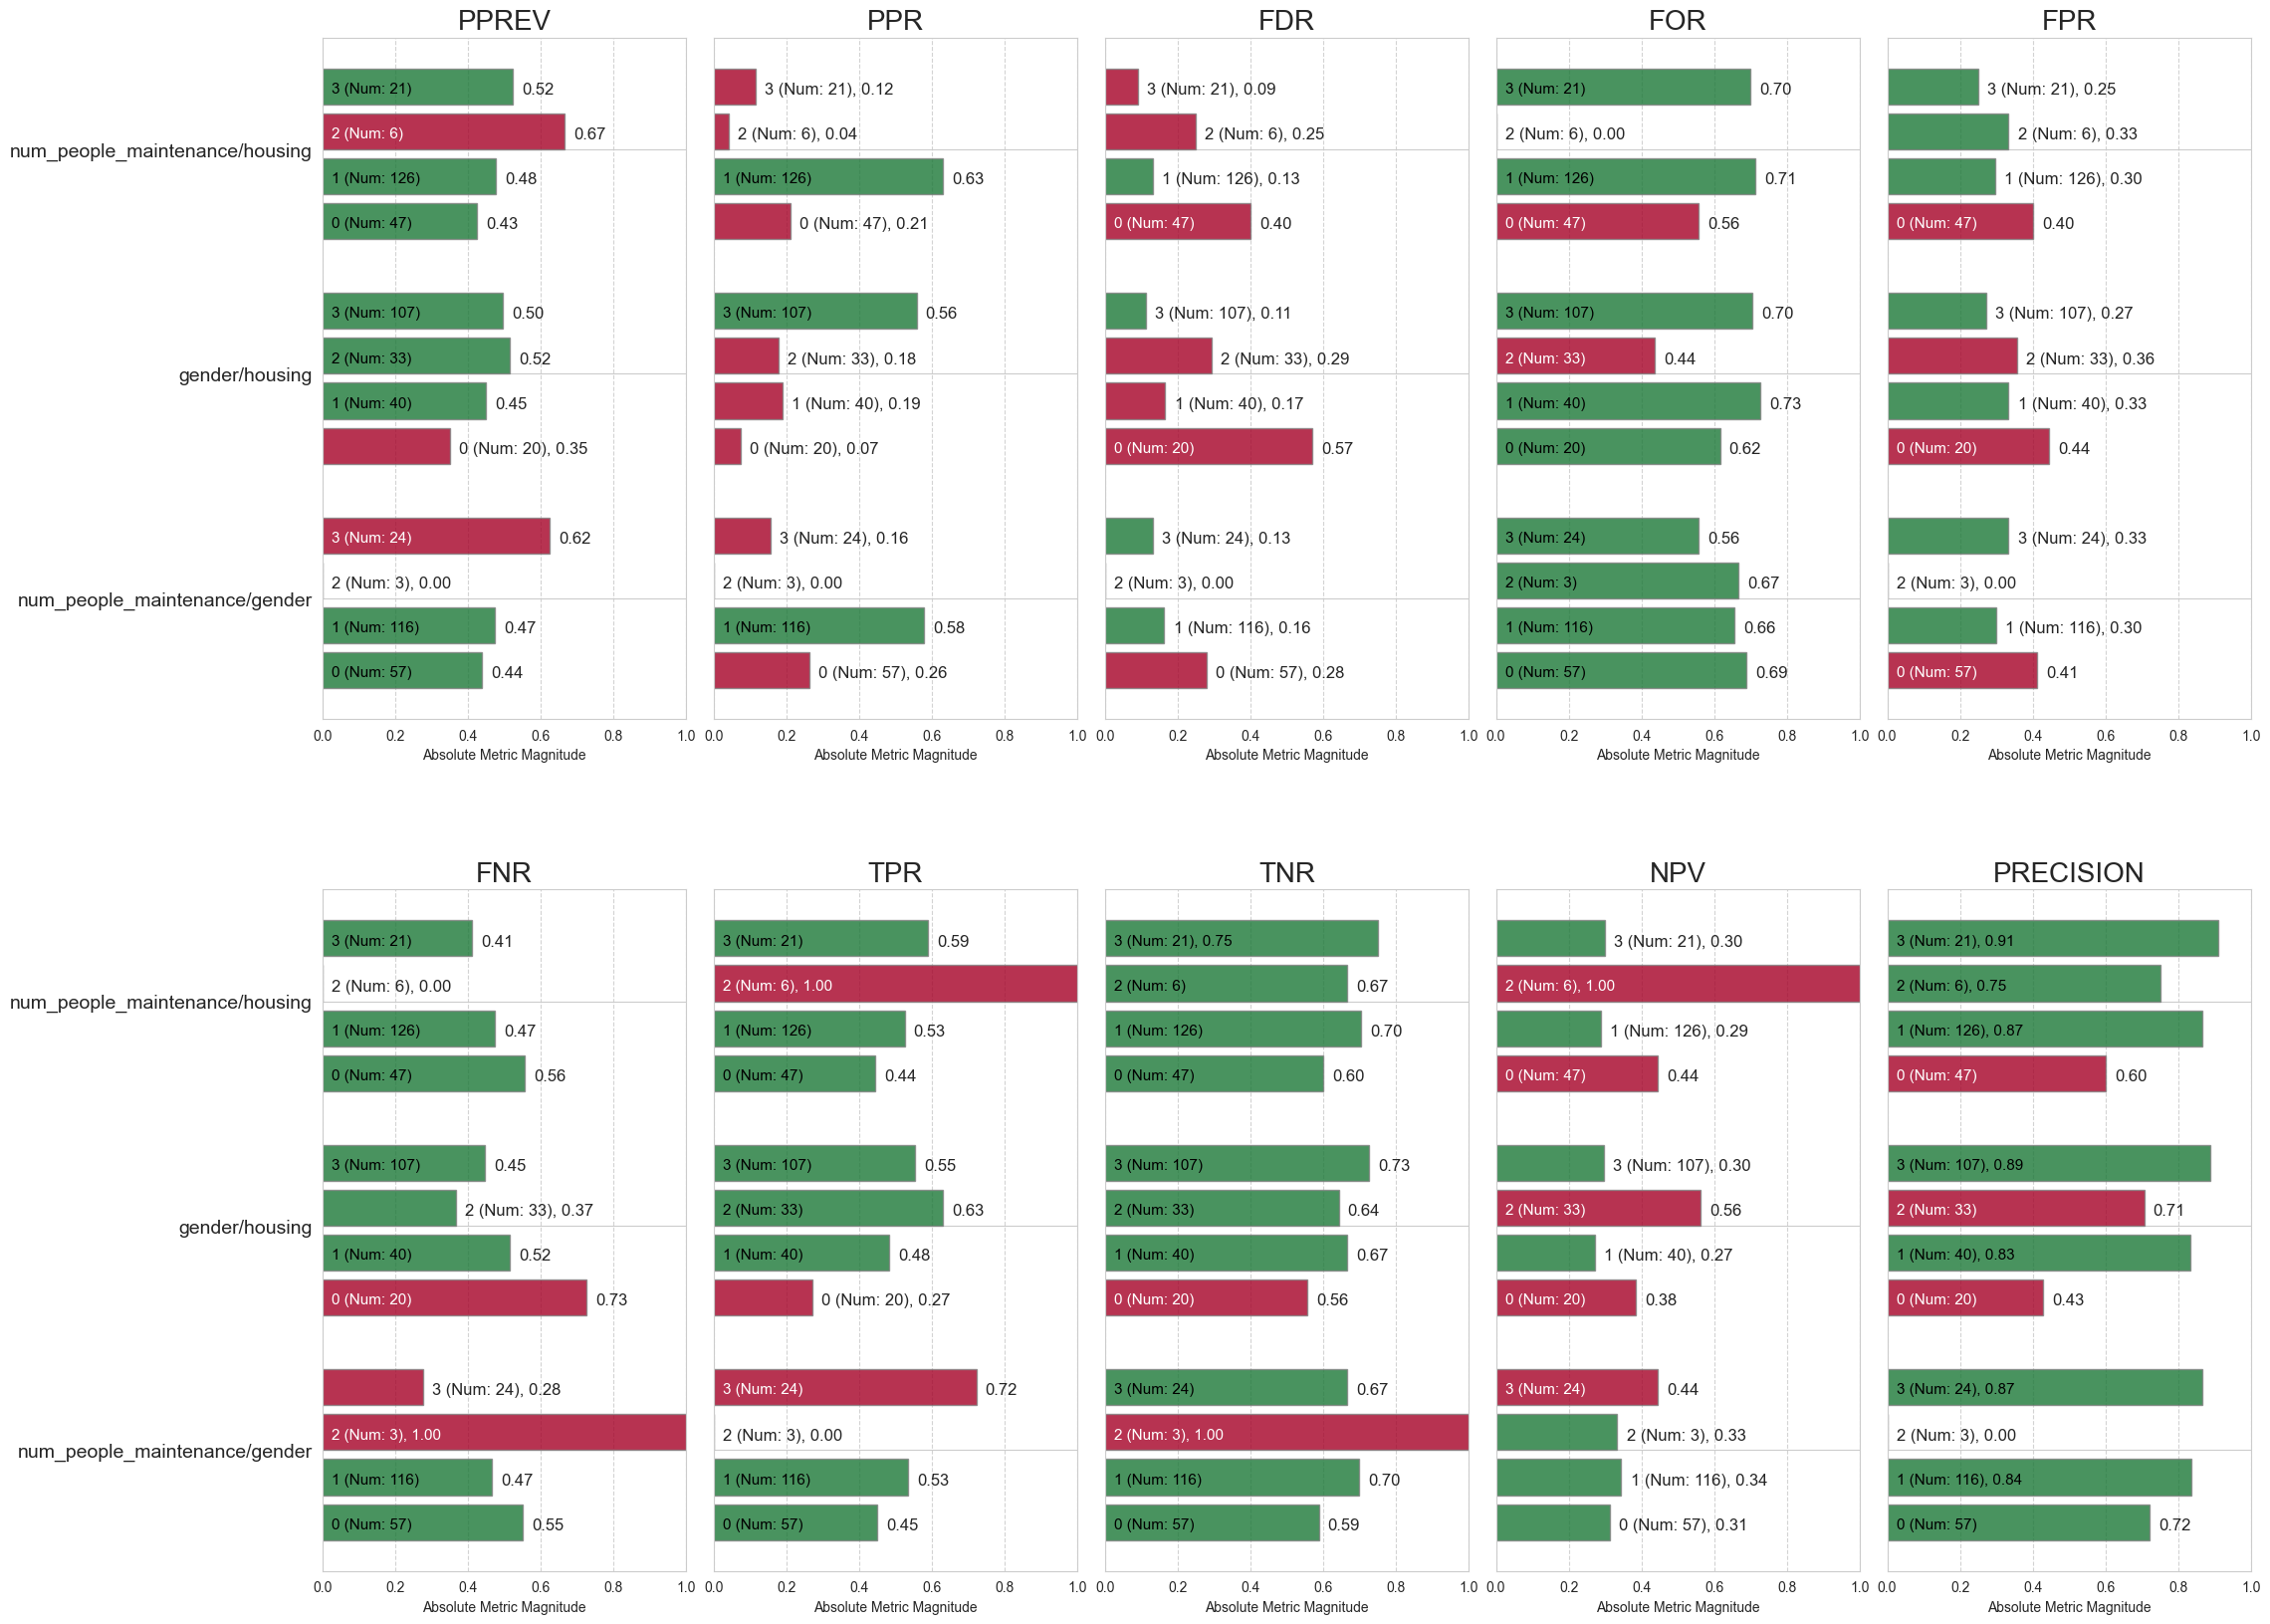

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False          False       False       False        True   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False       False       False             False   
1       False       False       False       False              True   
2       False       False        True       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

score  label_value num_people_maintenance/gender gender/housing  \
795    1.0            1                             1              3   
489    1.0            0                             0              0   
299    1.0            1                             0              0   
986    1.0            1                             1              2   
385    1.0            1                             3              3   
..     ...          ...                           ...            ...   
740    0.0            0                             3              2   
738    0.0            1                             0              1   
576    0.0            1                             1              3   
252    0.0            1                             1              3   
150    0.0            1                             0              0   

    num_people_maintenance/housing  rank_abs  rank_pct  binary_score  \
795                              1         1     0.005             1   
489                              0         2     0.010             1   
299                              0         3     0.015             1   
986                              0         4     0.020             1   
385                              3         5     0.025             1   
..                             ...       ...       ...           ...   
740                              2       196     0.980             0   
738                              1       197     0.985             0   
576                              1       198     0.990             0   
252                              1       199     0.995             0   
150                              0       200     1.000             0   

     binary_fpr  binary_fnr  binary_tnr  binary_precision  binary_ppr  \
795         0.0         NaN         0.0               0.0           1   
489         1.0         NaN         1.0               1.0           1   
299         0.0         NaN         0.0               0.0           1   
986         0.0         NaN         0.0               0.0           1   
385         0.0         NaN         0.0               0.0           1   
..          ...         ...         ...               ...         ...   
740         NaN         0.0         NaN               NaN           0   
738         NaN         1.0         NaN               NaN           0   
576         NaN         1.0         NaN               NaN           0   
252         NaN         1.0         NaN               NaN           0   
150         NaN         1.0         NaN               NaN           0   

     binary_pprev  binary_tpr  binary_fdr  binary_for  binary_npv  
795             1         NaN         0.0         NaN         NaN  
489             1         NaN         1.0         NaN         NaN  
299             1         NaN         0.0         NaN         NaN  
986             1         NaN         0.0         NaN         NaN  
385             1         NaN         0.0         NaN         NaN  
..            ...         ...         ...         ...         ...  
740             0         0.0         NaN         0.0         0.0  
738             0         1.0         NaN         1.0         1.0  
576             0         1.0         NaN         1.0         1.0  
252             0         1.0         NaN         1.0         1.0  
150             0         1.0         NaN         1.0         1.0  

[200 rows x 18 columns]

<Figure size 640x480 with 0 Axes>

In [124]:
post_process_group_threshold_fairlearn(data=df_num_int,attributes=protected_attributes_int,target=target, list_of_disparities=list_of_disparities,priv=priv,model="LogisticRegression",to_encode=to_encode)

---------- Model name:  LogisticRegression ----------

Best estimator: LogisticRegression(C=0.51, random_state=42, solver='liblinear')
Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Accuracy score test corrected:
0.7600


attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.75  0.98  0.24   
1    num_people_maintenance/gender               1      0.75  0.95  0.17   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.83  1.00  0.33   
4                   gender/housing               0      0.70  1.00  0.33   
5                   gender/housing               1      0.78  0.97  0.11   
6                   gender/housing               2      0.64  0.89  0.29   
7                   gender/housing               3      0.80  0.98  0.14   
8   num_people_maintenance/housing               0      0.66  0.93  0.30   
9   num_people_maintenance/housing               1      0.79  0.97  0.11   
10  num_people_maintenance/housing               2      0.67  1.00  0.33   
11  num_people_maintenance/housing               3      0.86  1.00  0.25   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.20  0.25  0.76  0.02  0.80       0.75  0.28   0.91  0.70  
1   0.44  0.23  0.83  0.05  0.56       0.77  0.58   0.92  0.74  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3   0.00  0.18  0.67  0.00  1.00       0.82  0.12   0.92  0.75  
4   0.00  0.35  0.67  0.00  1.00       0.65  0.09   0.85  0.55  
5   0.50  0.21  0.89  0.03  0.50       0.79  0.21   0.95  0.78  
6   0.33  0.37  0.71  0.11  0.67       0.63  0.15   0.82  0.58  
7   0.40  0.19  0.86  0.02  0.60       0.81  0.55   0.95  0.79  
8   0.25  0.36  0.70  0.07  0.75       0.64  0.21   0.83  0.57  
9   0.50  0.20  0.89  0.03  0.50       0.80  0.65   0.95  0.79  
10  0.00  0.40  0.67  0.00  1.00       0.60  0.03   0.83  0.50  
11  0.00  0.15  0.75  0.00  1.00       0.85  0.11   0.95  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.07   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.43   
3    num_people_maintenance/gender               3           0.78   
4                   gender/housing               0           1.89   
5                   gender/housing               1           1.13   
6                   gender/housing               2           1.99   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.79   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.00   
11  num_people_maintenance/housing               3           0.75   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.54           0.45           0.92           1.44           0.49   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.20            NaN           0.03   
3            0.00           0.00           0.80           1.80           0.21   
4            0.00           0.00           0.77           1.67           0.17   
5            1.37           1.25           1.03           0.83           0.37   
6            4.47           0.83           0.83           1.11           0.26   
7            1.00           1.00           1.00           1.00           1.00   
8            2.44           0.50           0.79           1.50           0.32   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00           0.00           0.75           2.00           0.04   
11           0.00           0.00           0.84           2.00           0.17   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.99                 0.98           1.41           1.02  
1              1.00                 1.00           1.00           1.00  
2              1.08                 0.87           0.00           1.05  
3              0.99                 1.07           2.00           1.05  
4              0.89                 0.80           2.44           1.02  
5              1.00                 0.97           0.81           0.99  
6              0.86                 0.77           2.10           0.92  
7              1.00                 1.00           1.00           1.00  
8              0.87                 0.80           2.70           0.95  
9              1.00                 1.00           1.00           1.00  
10             0.88                 0.75           3.00           1.03  
11             1.00                 1.06           2.25           1.03

dict_keys(['num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing'])
                                fnr_disparity  for_disparity  fpr_disparity
num_people_maintenance/gender        0.180000       0.225000       0.973333
gender/housing                       1.946667       0.693333       0.876667
num_people_maintenance/housing       0.813333       0.166667       0.793333
Overall average for fnr_disparity:  0.980
Overall average for for_disparity:  0.362
Overall average for fpr_disparity:  0.881


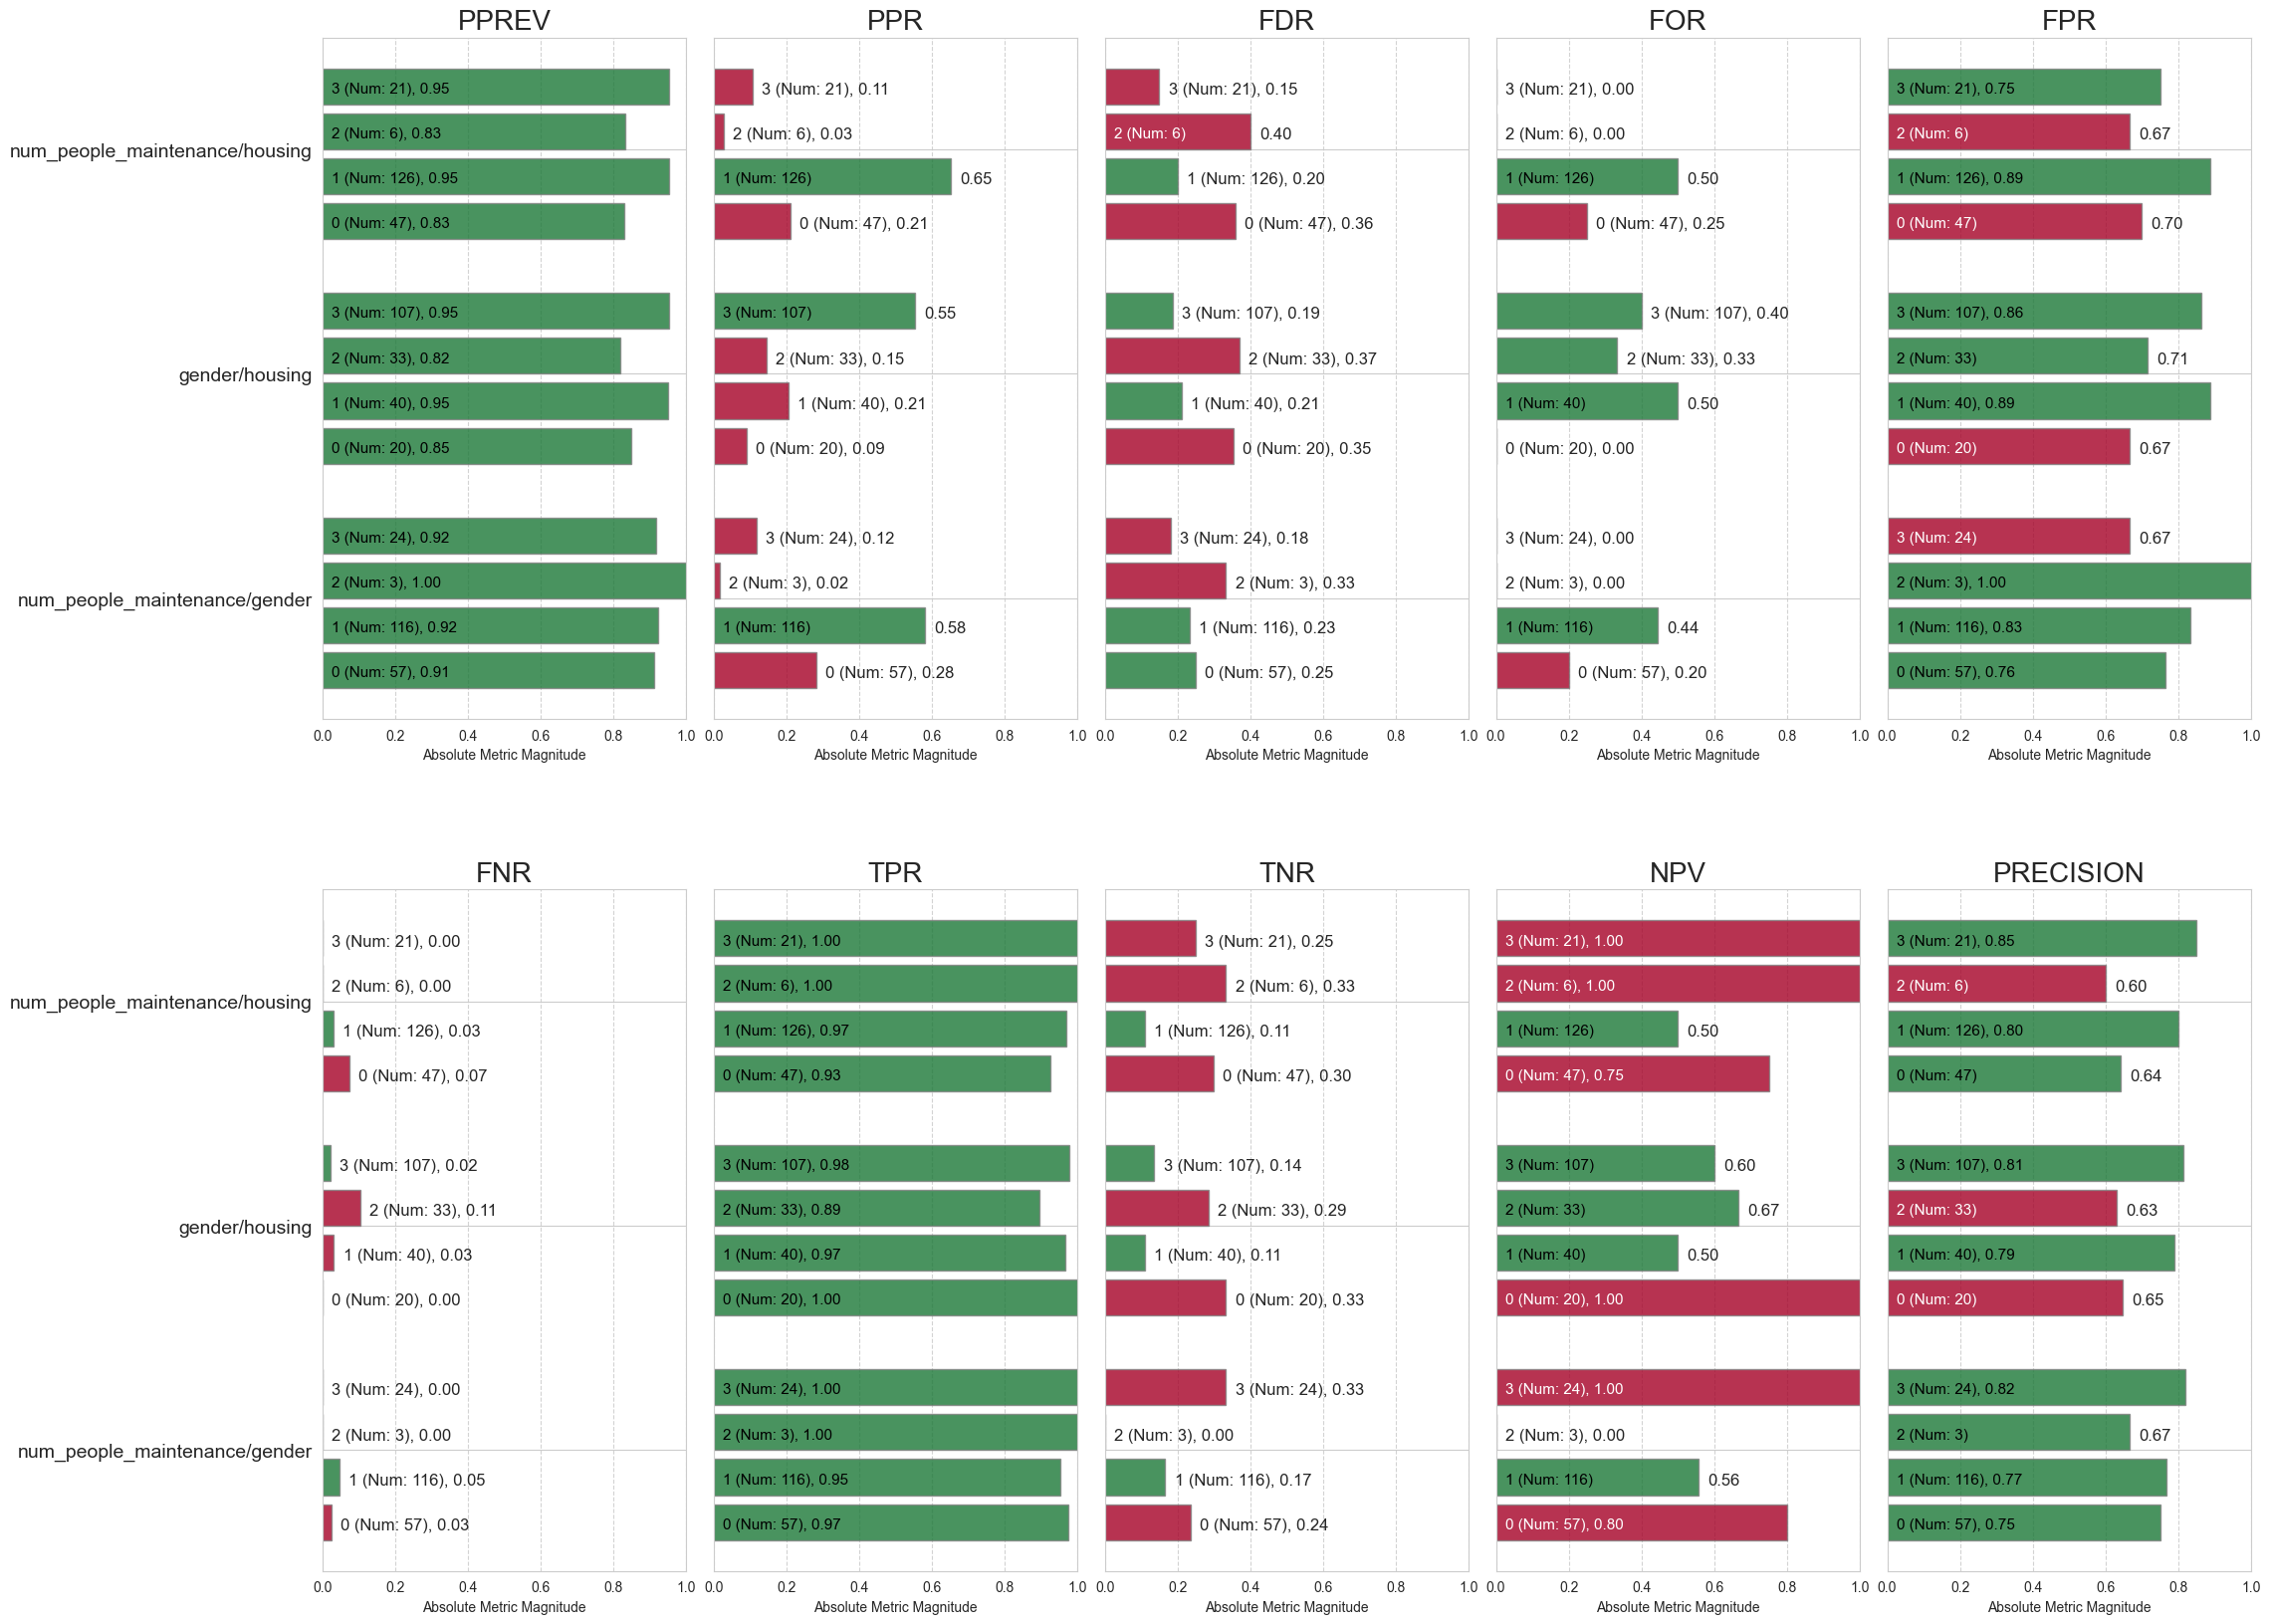

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False        True       False       False              True   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

score  label_value num_people_maintenance/gender gender/housing  \
993    1.0            1                             0              1   
753    1.0            1                             1              3   
946    1.0            1                             1              2   
60     1.0            1                             3              2   
372    1.0            0                             0              1   
..     ...          ...                           ...            ...   
630    0.0            0                             3              3   
483    0.0            0                             1              2   
312    0.0            0                             0              0   
395    0.0            1                             1              2   
485    0.0            0                             3              2   

    num_people_maintenance/housing  rank_abs  rank_pct  binary_score  \
993                              1         1     0.005             1   
753                              1         2     0.010             1   
946                              0         3     0.015             1   
60                               2         4     0.020             1   
372                              1         5     0.025             1   
..                             ...       ...       ...           ...   
630                              3       196     0.980             0   
483                              0       197     0.985             0   
312                              0       198     0.990             0   
395                              0       199     0.995             0   
485                              2       200     1.000             0   

     binary_fpr  binary_fnr  binary_tnr  binary_precision  binary_ppr  \
993         0.0         NaN         0.0               0.0           1   
753         0.0         NaN         0.0               0.0           1   
946         0.0         NaN         0.0               0.0           1   
60          0.0         NaN         0.0               0.0           1   
372         1.0         NaN         1.0               1.0           1   
..          ...         ...         ...               ...         ...   
630         NaN         0.0         NaN               NaN           0   
483         NaN         0.0         NaN               NaN           0   
312         NaN         0.0         NaN               NaN           0   
395         NaN         1.0         NaN               NaN           0   
485         NaN         0.0         NaN               NaN           0   

     binary_pprev  binary_tpr  binary_fdr  binary_for  binary_npv  
993             1         NaN         0.0         NaN         NaN  
753             1         NaN         0.0         NaN         NaN  
946             1         NaN         0.0         NaN         NaN  
60              1         NaN         0.0         NaN         NaN  
372             1         NaN         1.0         NaN         NaN  
..            ...         ...         ...         ...         ...  
630             0         0.0         NaN         0.0         0.0  
483             0         0.0         NaN         0.0         0.0  
312             0         0.0         NaN         0.0         0.0  
395             0         1.0         NaN         1.0         1.0  
485             0         0.0         NaN         0.0         0.0  

[200 rows x 18 columns]

<Figure size 640x480 with 0 Axes>

In [125]:
post_process_eq_ods(data=df_num_int, attributes=protected_attributes_int, target=target,list_of_disparities=list_of_disparities,priv=priv,model="LogisticRegression")